In [1]:
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 
import kagglehub
import pandas as pd
import warnings

warnings.filterwarnings( "ignore", category=UserWarning)

KAGGLE_TOKEN = "KGAT_0afafa0d8410555d77602e569d9f47bf"

c:\Users\gavro\OneDrive\Desktop\aravalli\kaggle-env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Ideas
 * For CPR, you estimate what the historical CPR is for loans that are no longer current. For current loans, you can esimtate what the future CPR will be. 
 * You can figure out what the "turnover", that is, full prepayment before end of loan term by looking at loans that fully paid before the last scheduled payment (or some threshold where some % of the UPB was still outstanding)
 * You can see how much of the fully paid loans were delinquent at some point for helping with the recovery matrix

# Load Data

In [2]:
input_df = pd.read_csv(r'C:\Users\gavro\OneDrive\Desktop\aravalli\data-check\accepted_2007_to_2018Q4.csv')

C:\Users\gavro\AppData\Local\Temp\ipykernel_13456\1715079881.py:1: DtypeWarning: Columns (0: id, 1: desc, 2: next_pymnt_d, 3: verification_status_joint, 4: sec_app_earliest_cr_line, 5: hardship_type, 6: hardship_reason, 7: hardship_status, 8: hardship_start_date, 9: hardship_end_date, 10: payment_plan_start_date, 11: hardship_loan_status, 12: debt_settlement_flag_date, 13: settlement_status, 14: settlement_date) have mixed types. Specify dtype option on import or set low_memory=False.
  input_df = pd.read_csv(r'C:\Users\gavro\OneDrive\Desktop\aravalli\data-check\accepted_2007_to_2018Q4.csv')


In [3]:
for c in input_df.columns: 
    print(c)

id
member_id
loan_amnt
funded_amnt
funded_amnt_inv
term
int_rate
installment
grade
sub_grade
emp_title
emp_length
home_ownership
annual_inc
verification_status
issue_d
loan_status
pymnt_plan
url
desc
purpose
title
zip_code
addr_state
dti
delinq_2yrs
earliest_cr_line
fico_range_low
fico_range_high
inq_last_6mths
mths_since_last_delinq
mths_since_last_record
open_acc
pub_rec
revol_bal
revol_util
total_acc
initial_list_status
out_prncp
out_prncp_inv
total_pymnt
total_pymnt_inv
total_rec_prncp
total_rec_int
total_rec_late_fee
recoveries
collection_recovery_fee
last_pymnt_d
last_pymnt_amnt
next_pymnt_d
last_credit_pull_d
last_fico_range_high
last_fico_range_low
collections_12_mths_ex_med
mths_since_last_major_derog
policy_code
application_type
annual_inc_joint
dti_joint
verification_status_joint
acc_now_delinq
tot_coll_amt
tot_cur_bal
open_acc_6m
open_act_il
open_il_12m
open_il_24m
mths_since_rcnt_il
total_bal_il
il_util
open_rv_12m
open_rv_24m
max_bal_bc
all_util
total_rev_hi_lim
inq_fi
to

In [4]:
cols = [
    "id",
    "purpose",
    "issue_d",
    "int_rate", 
    "term",
    "addr_state",
    "zip_code",
    "loan_status",
    "loan_amnt",
    "funded_amnt",
    "funded_amnt_inv",
    "application_type",
    "annual_inc",
    "annual_inc_joint",
    "dti",
    "dti_joint",
    "fico_range_high",
    "fico_range_low",
    "grade",
    "sub_grade",
    "last_credit_pull_d",
    "last_fico_range_high",
    "last_fico_range_low",
    "last_pymnt_amnt",
    "installment",
    "last_pymnt_d",
    "next_pymnt_d",
    "out_prncp",
    "out_prncp_inv",
    "total_pymnt",
    "total_pymnt_inv",
    "total_rec_prncp",
    "total_rec_int",
    "total_rec_late_fee",
    "total_bal_il",
    "tot_cur_bal",
    "mths_since_last_record",
    "pymnt_plan",
    "mths_since_last_delinq",
    "open_acc",
    "recoveries"
]

#loan_df = input_df[cols]
loan_df = input_df.copy()

In [5]:
# threshold for missingness
missing_threshold = 0.98

# fraction of missing values per column
missing_frac = loan_df.isna().mean()

# columns to drop
cols_to_drop = missing_frac[missing_frac >= missing_threshold].index.tolist()

# drop them
loan_df = loan_df.drop(columns=cols_to_drop)

# (optional) inspect what was dropped
cols_to_drop

['member_id',
 'sec_app_mths_since_last_major_derog',
 'hardship_type',
 'hardship_reason',
 'hardship_status',
 'deferral_term',
 'hardship_amount',
 'hardship_start_date',
 'hardship_end_date',
 'payment_plan_start_date',
 'hardship_length',
 'hardship_dpd',
 'hardship_loan_status',
 'orig_projected_additional_accrued_interest',
 'hardship_payoff_balance_amount',
 'hardship_last_payment_amount',
 'debt_settlement_flag_date',
 'settlement_status',
 'settlement_date',
 'settlement_amount',
 'settlement_percentage',
 'settlement_term']

In [6]:
# ------------------------------------------------------------------------------
# 1) Drop non-loan rows (IDs that are not numeric)
#    These are typically summary / policy rows in LC exports
# ------------------------------------------------------------------------------
loan_df = loan_df.copy()

loan_df["id"] = pd.to_numeric(loan_df["id"], errors="coerce")
loan_df = loan_df.loc[loan_df["id"].notna()].copy()
loan_df["id"] = loan_df["id"].astype("int64")

# ------------------------------------------------------------------------------
# 2) Interest rate: convert from percent to decimal
# ------------------------------------------------------------------------------
loan_df["int_rate"] = pd.to_numeric(loan_df["int_rate"], errors="coerce") / 100.0

# ------------------------------------------------------------------------------
# 3) Issue date cleanup
#    LC stores issue_d like "Dec-2011"
# ------------------------------------------------------------------------------
loan_df["issue_d"] = pd.to_datetime(loan_df["issue_d"], errors="coerce")

loan_df["issue_month_year"] = loan_df["issue_d"].dt.strftime("%b-%Y")
loan_df["issue_quarter"] = loan_df["issue_d"].dt.to_period("Q").astype(str)

# ------------------------------------------------------------------------------
# 4) Term: extract numeric months (handles "36 months", "60 months", numeric)
# ------------------------------------------------------------------------------
loan_df["term_months"] = (
    loan_df["term"]
    .astype(str)
    .str.extract(r"(\d+)", expand=False)
    .astype("Int64")
)

# ------------------------------------------------------------------------------
# 5) Parse other date columns if present
# ------------------------------------------------------------------------------
date_cols = [
    c for c in [
        "last_pymnt_d",
        "last_credit_pull_d",
        "next_pymnt_d",
    ]
    if c in loan_df.columns
]

for c in date_cols:
    loan_df[c] = pd.to_datetime(loan_df[c], errors="coerce")

# ------------------------------------------------------------------------------
# 6) Maturity month (issue month + term)
# ------------------------------------------------------------------------------
loan_df["maturity_month"] = (
    loan_df["issue_d"].dt.to_period("M")
    + loan_df["term_months"]
)

loan_df.head()

,id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,...,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,hardship_flag,disbursement_method,debt_settlement_flag,issue_month_year,issue_quarter,term_months,maturity_month
0,68407277,3600.0,3600.0,3600.0,36 months,0.1399,123.03,C,C4,leadman,...,NaN,NaN,NaN,N,Cash,N,Dec-2015,2015Q4,36,2018-12
1,68355089,24700.0,24700.0,24700.0,36 months,0.1199,820.28,C,C1,Engineer,...,NaN,NaN,NaN,N,Cash,N,Dec-2015,2015Q4,36,2018-12
2,68341763,20000.0,20000.0,20000.0,60 months,0.1078,432.66,B,B4,truck driver,...,NaN,NaN,NaN,N,Cash,N,Dec-2015,2015Q4,60,2020-12
3,66310712,35000.0,35000.0,35000.0,60 months,0.1485,829.90,C,C5,Information Systems Officer,...,NaN,NaN,NaN,N,Cash,N,Dec-2015,2015Q4,60,2020-12
4,68476807,10400.0,10400.0,10400.0,60 months,0.2245,289.91,F,F1,Contract Specialist,...,NaN,NaN,NaN,N,Cash,N,Dec-2015,2015Q4,60,2020-12


# Clean and Parse Data
Important observations about the data
 * This data is not a time series data set. Each loan only has one record, which is presumably the most recent record.
 * For each record, we have up to three periods of data. Data from origination (like funded amnt), the previous period (like last payment amount) and data from this period (like outstanding UPB)
 * Broadly, there are active loans (both current and late) and inactive loans (fully paid off and charged off). 
 * Given the different types of loans (acitve vs inactive, or more specifically, defined by loan_status), each type of loan provides different useful information. 
    * Ex.) A current loan is useful for looking at the most recent CPR or the WAC of loans eligble for purpose. A charged off loan is useful for default and recovery rates. 

# Approach
Because the loan_status field is critical for understanding at which point in the loan's life we are looking at it, I will start with cleaning the data by loan_status to set us up for subsequent calculations. 
 * First, will seperate the loans based on status then identify/correct any inconsistencies. 
 * Second, will compute the various credit and performance metrics by strata/spec.  

 - COMFORTABLE WITH THE CURRENT AND FULLY PAID, NOW JUST NEED TO MAKE SURE LATE AND CHARGED OFF LOOKS GOOD AND THAT THE COLUMN VALUES LIKE DTI AND FICO LOOKS GOOD

I would like to note that given the large amount of data in this dataset and the lack of resources available to find information about this data, I may be more inclined to drop data where in other circumstances I would research more how to fix it. With that said, I did find some resources online that provide information: 
 - [INSERT DATA HERE]  
  
# Assumptions  
There are a couple critical assumptions I am making after playing around with the data set and determining what is solvable versus not solvable 
 - For loan status, I can infer a few things:
  - Each loan started as current. 
  - Current loans have always been current because I cannot see historical cashflows. I tried doing things like calculting expected UPB and expected monthly payment to compare to the data in the data set, but I ultimately decided this was not reliable and introduced too many complications. 
  - Loans that are not longer current went through the life cycle of status: Current -> in grace period -> Late 1 -> late 2 -> default -> charged off

## Loan Status

In [7]:
# First check the various types of loan status
loan_df['loan_status'].unique()

<StringArray>
[                                         'Fully Paid',
                                             'Current',
                                         'Charged Off',
                                     'In Grace Period',
                                  'Late (31-120 days)',
                                   'Late (16-30 days)',
                                             'Default',
  'Does not meet the credit policy. Status:Fully Paid',
 'Does not meet the credit policy. Status:Charged Off']
Length: 9, dtype: str

In [8]:
status_summary = (
    loan_df["loan_status"]
    .value_counts(dropna=False)
    .rename("count")
    .to_frame()
)

status_summary["percent"] = status_summary["count"] / status_summary["count"].sum() * 100

status_summary

,count,percent
loan_status,,
Fully Paid,1076751,47.629771
Current,878317,38.852100
Charged Off,268559,11.879630
Late (31-120 days),21467,0.949587
In Grace Period,8436,0.373164
Late (16-30 days),4349,0.192377
Does not meet the credit policy. Status:Fully Paid,1988,0.087939
Does not meet the credit policy. Status:Charged Off,761,0.033663
Default,40,0.001769


I looked into the 'Does not meet the credit policy...' loans; other users think these are loans that not longer would be approved by LC.  
Regardless, they are not investable since they are charged off or fully paid, and they are less than 0.3% of all outstanding loans.  
Thus, I will drop these loans. 

In [9]:
loan_df = loan_df[~loan_df['loan_status'].isin(["Does not meet the credit policy. Status:Fully Paid", "Does not meet the credit policy. Status:Charged Off"])]
loan_df['loan_status'].value_counts()

loan_status
Fully Paid            1076751
Current                878317
Charged Off            268559
Late (31-120 days)      21467
In Grace Period          8436
Late (16-30 days)        4349
Default                    40
Name: count, dtype: int64

In [10]:
loan_df.shape[0]

2257919

Now, will check to see if there are any `loan_status` that appear to be inaccurate. 

### All Loans  
There are a couple data fields that are necessary for analyzing this loan data and/or have to make sense for all loans: int_rate, issue_d, term, last_pymnt_d  
DO ALL THE NUMBER AND OTHER CHECKS HERE   
All the little findings you have that you are not sure about and decide to leave alone should be pointed out as something that should be monitored in the future or would be asked about to the data vendor. 
  
Value Checks 
 - out_prncp, total_rec_late_fee, total_prncp_rec, total_int_rec, dti, fico, etc cannot have negative values. These should be replaced with 0. 
 - loans without last payment dates need to be dropped. 
 - columns that have different values for individual and joint need to be consolidated, and a flag added
  
Findings  
 - There are 2415 loans with no last payment date. 

Actions  
 - Drop loans with no last payment date, there is no way to figure out what it was. 

In [11]:
# def clean_numeric_cols(
#     df: pd.DataFrame,
#     near_zero_bound: float = 1.0,
#     negative_cutoff: float = -1.0,
#     verbose: bool = True,
# ):
#     """
#     Cleans numeric columns by:
#       1) Identifying all numeric columns
#       2) Setting values with abs(x) < near_zero_bound to 0
#       3) Dropping rows where any numeric column has x < negative_cutoff

#     Returns
#     -------
#     cleaned_df : pd.DataFrame
#     report : dict
#     """

#     df = df.copy()

#     # ------------------------------------------------------------------
#     # Identify numeric columns
#     # ------------------------------------------------------------------
#     numeric_cols = df.select_dtypes(include="number").columns.tolist()

#     # ------------------------------------------------------------------
#     # Identify erroneous rows BEFORE modification
#     # ------------------------------------------------------------------
#     negative_mask = (df[numeric_cols] < negative_cutoff).any(axis=1)
#     num_erroneous_rows = int(negative_mask.sum())

#     # ------------------------------------------------------------------
#     # Drop erroneous rows
#     # ------------------------------------------------------------------
#     cleaned_df = df.loc[~negative_mask].copy()

#     # ------------------------------------------------------------------
#     # Zero out near-zero values
#     # ------------------------------------------------------------------
#     near_zero_mask = cleaned_df[numeric_cols].abs() <= near_zero_bound 
#     cleaned_df.loc[:, numeric_cols] = cleaned_df[numeric_cols].mask(
#         near_zero_mask, 0.0
#     )

#     # ------------------------------------------------------------------
#     # Build report
#     # ------------------------------------------------------------------
#     report = {
#         "numeric_columns": numeric_cols,
#         "num_numeric_columns": len(numeric_cols),
#         "rows_dropped_negative_lt_cutoff": num_erroneous_rows,
#         "near_zero_bound": near_zero_bound,
#         "negative_cutoff": negative_cutoff,
#     }

#     if verbose:
#         print("Numeric columns identified:")
#         for c in numeric_cols:
#             print(f"  - {c}")

#         print(f"\nRows dropped (any value < {negative_cutoff}): {num_erroneous_rows}")
#         print(f"Values with abs(x) < {near_zero_bound} set to 0")

#     return cleaned_df, report

# loan_df, report = clean_numeric_cols(loan_df)

In [12]:
last_pymnt_before_issue = loan_df[ (loan_df['last_pymnt_d'] < loan_df['issue_d']) ]

no_last_pymnt_d = loan_df[ loan_df['last_pymnt_d'].isna() ]

no_int_rate = loan_df[loan_df['int_rate'].isna()]

no_issue_d = loan_df[loan_df['issue_d'].isna()]

no_term = loan_df[loan_df['term'].isna()]

print("last payment before issue: ", last_pymnt_before_issue.shape[0])
print("no last payment date: ", no_last_pymnt_d.shape[0])
print("no interest rate: ", no_int_rate.shape[0])
print("no issue date: ", no_issue_d.shape[0])
print("no term rate: ", no_term.shape[0])

last payment before issue:  0
no last payment date:  2415
no interest rate:  0
no issue date:  0
no term rate:  0


In [13]:
no_last_pymnt_d['next_pymnt_d'].value_counts() # some of the no last pymnt d have next one, but most of them are NA

next_pymnt_d
2019-04-01    102
Name: count, dtype: int64

In [14]:
# apply above changed 
loan_df2 = loan_df[ ~ loan_df['last_pymnt_d'].isna() ]
loan_df2.shape[0] 

2255504

In [15]:
loan_df2[loan_df2['loan_status'] != "Charged Off"]['recoveries'].describe()

count    1989258.0
mean           0.0
std            0.0
min            0.0
25%            0.0
50%            0.0
75%            0.0
max            0.0
Name: recoveries, dtype: float64

Doing my own amortization calculations to see if there are any loans that may have been modified during their lifetime

In [16]:
# Amortization calculations for loan portfolio analysis

def calc_monthly_payment(principal: np.ndarray, 
                         annual_rate: np.ndarray, 
                         term_months: np.ndarray) -> np.ndarray:
    """
    Vectorized calculation of fixed monthly payment for fully amortizing loans.
    
    Formula: PMT = P * [r(1+r)^n] / [(1+r)^n - 1]
    """
    monthly_rate = annual_rate / 12.0
    
    # Handle zero interest rate
    zero_rate_mask = monthly_rate == 0
    
    # Calculate for non-zero rates
    numerator = monthly_rate * (1 + monthly_rate) ** term_months
    denominator = (1 + monthly_rate) ** term_months - 1
    
    # Avoid division by zero
    with np.errstate(divide='ignore', invalid='ignore'):
        payment = principal * (numerator / denominator)
    
    # For zero rates, payment is simple division
    payment[zero_rate_mask] = principal[zero_rate_mask] / term_months[zero_rate_mask]
    
    return payment


def calc_balance(principal: np.ndarray,
                 annual_rate: np.ndarray,
                 monthly_payment: np.ndarray,
                 payments_made: np.ndarray) -> tuple:
    """
    Vectorized calculation of remaining balance after specified payments.
    """
    monthly_rate = annual_rate / 12.0
    
    # Initialize arrays (ensure float64)
    remaining_balance = principal.copy().astype(np.float64)
    total_principal_paid = np.zeros_like(principal, dtype=np.float64)
    total_interest_paid = np.zeros_like(principal, dtype=np.float64)
    
    # For loans with no payments, return initial values
    no_payments_mask = payments_made == 0
    
    # For loans with payments, calculate iteratively
    max_payments = int(np.max(payments_made)) if len(payments_made) > 0 else 0
    
    for payment_num in range(1, max_payments + 1):
        # Mask for loans that have made at least this many payments
        active_mask = payments_made >= payment_num
        
        if not active_mask.any():
            break
        
        # Calculate interest for this period
        interest = remaining_balance * monthly_rate
        
        # Calculate principal payment
        principal_pmt = monthly_payment - interest
        
        # Handle final payment (may be less than regular payment)
        principal_pmt = np.minimum(principal_pmt, remaining_balance)
        
        # Update only for active loans
        remaining_balance[active_mask] -= principal_pmt[active_mask]
        total_principal_paid[active_mask] += principal_pmt[active_mask]
        total_interest_paid[active_mask] += interest[active_mask]
    
    # Ensure no negative balances
    remaining_balance = np.maximum(remaining_balance, 0.0)
    
    return remaining_balance, total_principal_paid, total_interest_paid


def calc_payment_num(start_dates: pd.Series, 
                     end_dates: pd.Series) -> np.ndarray:
    """
    Vectorized calculation of months between two date series.
    """
    # Calculate month difference
    months = (end_dates.dt.year - start_dates.dt.year) * 12 + \
             (end_dates.dt.month - start_dates.dt.month)
    
    # Convert to numpy and handle NaN/negative
    months = months.fillna(0).values
    months = np.maximum(months, 0)
    
    return months.astype(int)


def calc_amort(df: pd.DataFrame,
               principal_col: str = 'funded_amnt',
               rate_col: str = 'int_rate',
               term_col: str = 'term_months',
               issue_date_col: str = 'issue_d',
               as_of_date_col: str = 'last_pymnt_d',
               verbose: bool = False) -> pd.DataFrame:
    """
    Calculate expected monthly payment and balance as of last_pymnt_d for each loan.
    
    OPTIMIZED for large datasets (2M+ loans) using vectorized operations.
    
    Returns:
    --------
    df_with_schedule : pd.DataFrame
        Original dataframe with added columns (all rounded to 2 decimals):
        
        ORIGINAL AMORTIZATION (orig_exp_*):
        - orig_exp_monthly_payment: Expected fixed monthly payment from origination
        - orig_exp_payments_made: Number of payments made
        - orig_exp_balance: Expected remaining balance
        - orig_exp_principal_paid: Expected cumulative principal paid
        - orig_exp_interest_paid: Expected cumulative interest paid
        - orig_exp_monthly_principal: Expected principal portion at last_pymnt_d
        - orig_exp_monthly_interest: Expected interest portion at last_pymnt_d
        - orig_exp_balance_diff: Actual out_prncp - orig_exp_balance
        - orig_exp_installment_diff: installment - orig_exp_monthly_payment
        
        LAST PAYMENT ANALYSIS (last_pmt_*):
        - last_pmt_beginning_balance: UPB before last payment
        - last_pmt_interest: Interest portion of last payment
        - last_pmt_actual_principal: Actual principal paid in last payment
        - last_pmt_scheduled_principal: Expected principal (from installment)
        - last_pmt_unscheduled_principal: Prepayment amount
        - last_pmt_smm: Single Monthly Mortality
        - last_pmt_cpr: Conditional Prepayment Rate (annualized)
        
        NEXT PAYMENT PROJECTION (next_pmt_*):
        - next_pmt_principal: Principal portion of next payment
        - next_pmt_interest: Interest portion of next payment
        - updated_remaining_term: Remaining months based on current balance
        - updated_maturity_date: Projected maturity date
    """
    
    df_sched = df.copy()
    
    # Validate required columns
    required_cols = [principal_col, rate_col, term_col, issue_date_col, as_of_date_col]
    missing_cols = [col for col in required_cols if col not in df_sched.columns]
    if missing_cols:
        raise ValueError(f"Missing required columns: {missing_cols}")
    
    # Convert dates to datetime if needed
    if df_sched[issue_date_col].dtype == 'object':
        df_sched[issue_date_col] = pd.to_datetime(df_sched[issue_date_col], errors='coerce')
    if df_sched[as_of_date_col].dtype == 'object':
        df_sched[as_of_date_col] = pd.to_datetime(df_sched[as_of_date_col], errors='coerce')
    
    # Check if rate is percentage or decimal and convert if needed
    sample_rate = df_sched[rate_col].dropna().iloc[0] if len(df_sched) > 0 else 0
    if sample_rate > 1:
        df_sched[rate_col] = df_sched[rate_col] / 100.0
    
    # Extract numpy arrays for vectorized operations
    principal = df_sched[principal_col].values
    annual_rate = df_sched[rate_col].fillna(0).values
    term_months = df_sched[term_col].fillna(0).values.astype(int)
    monthly_rate = annual_rate / 12.0
    
    # =========================================================================
    # PART 1: ORIGINAL AMORTIZATION (exp_* columns)
    # =========================================================================
    
    # Step 1: Calculate expected monthly payment (vectorized)
    monthly_payment = calc_monthly_payment(principal, annual_rate, term_months)
    df_sched['orig_exp_monthly_payment'] = np.round(monthly_payment, 2)
    
    # Step 2: Calculate number of payments made (vectorized)
    payments_made = calc_payment_num(
        df_sched[issue_date_col], 
        df_sched[as_of_date_col]
    )
    payments_made = np.minimum(payments_made, term_months)
    df_sched['orig_exp_payments_made'] = payments_made
    
    # Step 3: Calculate expected balance (vectorized)
    remaining_balance, principal_paid, interest_paid = calc_balance(
        principal, annual_rate, monthly_payment, payments_made
    )
    
    df_sched['orig_exp_balance'] = np.round(remaining_balance, 2)
    df_sched['orig_exp_principal_paid'] = np.round(principal_paid, 2)
    df_sched['orig_exp_interest_paid'] = np.round(interest_paid, 2)
    
    # Step 4: Calculate principal/interest split for last payment made
    has_payments_mask = payments_made > 0
    
    balance_before_last, _, _ = calc_balance(
        principal, annual_rate, monthly_payment, np.maximum(payments_made - 1, 0)
    )
    
    exp_monthly_interest = balance_before_last * monthly_rate
    exp_monthly_principal = monthly_payment - exp_monthly_interest
    exp_monthly_principal = np.minimum(exp_monthly_principal, balance_before_last)
    exp_monthly_interest = monthly_payment - exp_monthly_principal
    
    exp_monthly_principal[~has_payments_mask] = 0.0
    exp_monthly_interest[~has_payments_mask] = 0.0
    
    df_sched['orig_exp_monthly_principal'] = np.round(exp_monthly_principal, 2)
    df_sched['orig_exp_monthly_interest'] = np.round(exp_monthly_interest, 2)
    
    # Step 5: Calculate differences
    if 'out_prncp' in df_sched.columns:
        df_sched['orig_exp_balance_diff'] = np.round(
            df_sched['out_prncp'] - df_sched['orig_exp_balance'], 2
        )
    
    if 'installment' in df_sched.columns:
        df_sched['orig_exp_installment_diff'] = np.round(
            df_sched['installment'] - df_sched['orig_exp_monthly_payment'], 2
        )
    
    # =========================================================================
    # PART 2: LAST PAYMENT ANALYSIS (last_pmt_* columns)
    # Using actual data: out_prncp, last_pymnt_amnt, installment, int_rate
    # =========================================================================
    
    if 'out_prncp' in df_sched.columns and 'last_pymnt_amnt' in df_sched.columns and 'installment' in df_sched.columns:
        
        current_upb = df_sched['out_prncp'].values
        last_payment = df_sched['last_pymnt_amnt'].values
        installment = df_sched['installment'].values
        
        # Has payment mask
        has_last_payment = (last_payment > 0) & (payments_made > 0)
        
        # Calculate beginning balance (before last payment)
        # Formula: beginning_balance = (current_upb + last_payment) / (1 + monthly_rate)
        with np.errstate(divide='ignore', invalid='ignore'):
            beginning_balance = (current_upb + last_payment) / (1 + monthly_rate)
        
        df_sched['last_pmt_beginning_balance'] = np.round(beginning_balance, 2)
        
        # Calculate interest portion of last payment
        last_pmt_interest = beginning_balance * monthly_rate
        df_sched['last_pmt_interest'] = np.round(last_pmt_interest, 2)
        
        # Calculate actual principal paid in last payment
        last_pmt_actual_principal = last_payment - last_pmt_interest
        df_sched['last_pmt_actual_principal'] = np.round(last_pmt_actual_principal, 2)
        
        # Calculate scheduled principal (from installment)
        last_pmt_scheduled_principal = installment - last_pmt_interest
        df_sched['last_pmt_scheduled_principal'] = np.round(last_pmt_scheduled_principal, 2)
        
        # Calculate unscheduled principal (prepayment)
        last_pmt_unscheduled_principal = last_pmt_actual_principal - last_pmt_scheduled_principal
        df_sched['last_pmt_unscheduled_principal'] = np.round(last_pmt_unscheduled_principal, 2)
        
        # Calculate SMM (Single Monthly Mortality)
        # SMM = unscheduled_principal / (beginning_balance - scheduled_principal)
        with np.errstate(divide='ignore', invalid='ignore'):
            denominator = beginning_balance - last_pmt_scheduled_principal
            smm = last_pmt_unscheduled_principal / denominator
            smm = np.where(denominator > 0, smm, 0)
            smm = np.where(has_last_payment, smm, 0)
        
        df_sched['last_pmt_smm'] = np.round(smm, 6)
        
        # Calculate CPR (Conditional Prepayment Rate)
        # CPR = 1 - (1 - SMM)^12
        cpr = 1 - (1 - smm) ** 12
        cpr = np.where(has_last_payment, cpr, 0)
        
        df_sched['last_pmt_cpr'] = np.round(cpr, 6)
    
    # =========================================================================
    # PART 3: NEXT PAYMENT PROJECTION (next_pmt_* columns)
    # Using current balance and installment to project forward
    # =========================================================================
    
    if 'out_prncp' in df_sched.columns and 'installment' in df_sched.columns:
        
        current_balance = df_sched['out_prncp'].values
        actual_payment = df_sched['installment'].values
        
        has_balance_mask = current_balance > 0
        
        # Calculate interest for next payment
        next_pmt_interest = current_balance * monthly_rate
        
        # Calculate principal for next payment
        next_pmt_principal = actual_payment - next_pmt_interest
        next_pmt_principal = np.minimum(next_pmt_principal, current_balance)
        
        # For loans with no balance, set to zero
        next_pmt_principal[~has_balance_mask] = 0.0
        next_pmt_interest[~has_balance_mask] = 0.0
        
        df_sched['next_pmt_principal'] = np.round(next_pmt_principal, 2)
        df_sched['next_pmt_interest'] = np.round(next_pmt_interest, 2)
        
        # Calculate remaining term
        # Formula: n = -ln(1 - r*P/PMT) / ln(1+r)
        with np.errstate(divide='ignore', invalid='ignore'):
            ratio = (monthly_rate * current_balance) / actual_payment
            ratio = np.minimum(ratio, 0.9999)  # Prevent issues when payment < interest
            
            remaining_term = -np.log(1 - ratio) / np.log(1 + monthly_rate)
            
            # Handle zero rate case
            zero_rate_mask = monthly_rate == 0
            remaining_term[zero_rate_mask] = current_balance[zero_rate_mask] / actual_payment[zero_rate_mask]
            
            # Round up to nearest whole month
            remaining_term = np.ceil(remaining_term)
        
        # Set to 0 for loans with no balance
        remaining_term[~has_balance_mask] = 0
        
        # Cap at reasonable maximum
        max_reasonable_term = 600  # 50 years
        remaining_term = np.minimum(remaining_term, max_reasonable_term)
        
        df_sched['updated_remaining_term'] = remaining_term.astype(int)
        
        # Calculate updated maturity date using period addition
        df_sched['updated_maturity_date'] = (
            df_sched[as_of_date_col].dt.to_period("M")
            + df_sched['updated_remaining_term']
        ).dt.to_timestamp()
    
    if verbose:
        print(f"Calculated amortization schedule for {len(df_sched):,} loans")
        print(f"Mean expected payment: ${df_sched['orig_exp_monthly_payment'].mean():.2f}")
        print(f"Total expected balance: ${df_sched['orig_exp_balance'].sum():,.2f}")
    
    return df_sched

loan_df3 = calc_amort(loan_df2)

### Current Loans
Key characteristics:  
 - Should have made payments recently
 - Should have outstanding UPB
 - Cannot make assumptions about past status of the loan, just that it was originated and it is now current. 

In [19]:
current = loan_df3[loan_df3['loan_status'] == "Current"]
current.shape # 878k current loans

(878317, 153)

#### UPB Check  
Findings   
 - Outstanding princpal of 0 means funded amount equals total principal recieved.
 - Outstanding principal equals funded amount minus total principal recieved.

Results 
 - Change the 4k loans that are paid off to Fully Paid 

In [20]:
current[current['funded_amnt'] == current['total_rec_prncp']].shape

(4537, 153)

In [21]:
current[current['out_prncp'] == 0].shape

(4537, 153)

In [22]:
(current[current['funded_amnt'] == current['total_rec_prncp']]['id'] == current[current['out_prncp'] == 0]['id']).sum()

np.int64(4537)

In [23]:
current['out_prncp_check'] = round( current['funded_amnt'] - current['total_rec_prncp'], 2 )
current[ current['out_prncp'] != current['out_prncp_check'] ]   # out_prncp = funded_amnt - total_rec_prncp

,id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,...,last_pmt_actual_principal,last_pmt_scheduled_principal,last_pmt_unscheduled_principal,last_pmt_smm,last_pmt_cpr,next_pmt_principal,next_pmt_interest,updated_remaining_term,updated_maturity_date,out_prncp_check


In [24]:
current[ current['out_prncp'] == 0 ]['last_pymnt_d'].value_counts() # looks like they are at or near most recent date, so safe to say they are paid off
current[ current['out_prncp'] == 0 ]['next_pymnt_d'].value_counts()

next_pymnt_d
2019-04-01    4284
2019-03-01     252
2018-08-01       1
Name: count, dtype: int64

In [25]:
# change loans that are still current adn have outstanding prncp of 0 to fully paid
mask = (loan_df3['loan_status'] == "Current") & (loan_df3['out_prncp'] == 0)
mask.sum()

np.int64(4537)

In [26]:
loan_df3.loc[mask, "loan_status"] = "Fully Paid"

#### Last Payment Check   
Findings 
 - 1.1k loans where last payment was less than the installment
 - Of the 1.1k, 256 have upb greater than the expected upb
  
Actions
 - Although it seems like these could be labeled late, I am not sure if they were modified at any point. Not going to touch them. 

In [27]:
current = loan_df3[loan_df3['loan_status'] == "Current"]

In [28]:
small_pymnt = current[current['last_pymnt_amnt'] < current['installment']] # could be the case that they are ahead of schedule 
small_pymnt.shape[0]

1149

In [50]:
small_pymnt[small_pymnt['orig_exp_balance_diff'] > 10 ] # Posiitve expected balance means they have either been modified or they are late on some UPB. Given such small population, will just leave alone.

,id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,...,last_pmt_interest,last_pmt_actual_principal,last_pmt_scheduled_principal,last_pmt_unscheduled_principal,last_pmt_smm,last_pmt_cpr,next_pmt_principal,next_pmt_interest,updated_remaining_term,updated_maturity_date
29209,66622406,30000.0,30000.0,30000.0,60 months,0.1199,667.19,C,C1,Regional manager,...,146.82,0.01,520.37,-520.36,-0.036712,-0.541330,520.37,146.82,25,2021-04-01
30256,66492043,30000.0,30000.0,30000.0,60 months,0.1259,676.32,C,C2,Manager,...,155.64,0.01,520.68,-520.67,-0.036374,-0.535318,520.68,155.64,26,2021-05-01
67326,64822882,18000.0,18000.0,18000.0,60 months,0.1999,476.79,E,E4,P&D DRIVER,...,156.11,0.01,320.68,-320.67,-0.035430,-0.518622,320.68,156.11,25,2021-04-01
67984,64862329,18000.0,18000.0,18000.0,60 months,0.1318,411.22,C,C3,Marketing,...,94.83,0.01,316.39,-316.38,-0.038037,-0.565147,316.39,94.83,24,2021-03-01
76361,63176541,22875.0,22875.0,22875.0,60 months,0.1786,579.14,D,D5,Respiratory Care,...,172.88,0.01,406.26,-406.25,-0.036242,-0.532967,406.26,172.88,24,2021-03-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2238970,91180398,9600.0,9600.0,9350.0,36 months,0.1139,316.07,B,B3,Distribution Control and Receiving,...,31.19,0.01,284.88,-284.87,-0.094903,-1.968306,284.88,31.19,11,2020-02-01
2243551,91152156,24000.0,24000.0,24000.0,60 months,0.1449,564.56,C,C4,Radiology Manager,...,193.80,0.01,370.76,-370.75,-0.023646,-0.323729,370.76,193.80,36,2022-03-01
2247992,91304534,6000.0,6000.0,6000.0,36 months,0.1399,205.04,C,C3,overnight stocker,...,24.62,6.93,180.42,-173.49,-0.089812,-1.806837,180.50,24.54,11,2020-02-01
2250082,91290454,8400.0,8400.0,8400.0,36 months,0.1559,293.63,C,C5,Server,...,35.54,3.36,258.09,-254.73,-0.102828,-2.236623,258.14,35.49,10,2020-01-01


#### Date Check  
Findings
 - 52k loans that probably havent recieved payment yet for March. Still consider these current. 
 - 58 loans that have last payment of Feb but didnt make full last payment and have an acutal balance greater than expect balance should be late. 
  
Actions  
 - Dont touch loans that paid in Feb, they may still be expected to pay in March. 
 - Drop loans that have earlier last payments, small number anyways 

In [51]:
current = loan_df3[loan_df3['loan_status'] == "Current"]
current.shape 

(873780, 153)

In [52]:
print(current['last_pymnt_d'].value_counts()) #52k loans with last payment of Feb. These probably havent made their payment / been updated for Feb payment yet. 
print(current['next_pymnt_d'].value_counts())

last_pymnt_d
2019-03-01    821603
2019-02-01     52171
2018-07-01         2
2019-01-01         2
2018-10-01         1
2018-02-01         1
Name: count, dtype: int64
next_pymnt_d
2019-04-01    873663
2019-05-01        96
2019-03-01        17
2018-09-01         2
2018-12-01         1
2018-02-01         1
Name: count, dtype: int64


In [53]:
current_date = current[(current['last_pymnt_d'] == "2019-03-01") & (current['next_pymnt_d'] == "2019-04-01")] 
print(current_date.shape) # 825k loans that have most recent payment dates

(821517, 153)


In [55]:
feb_current = current[current['last_pymnt_d'] == "2019-02-01"]
print(feb_current['next_pymnt_d'].value_counts()) # interesting, most of them do have next payment date of April. 
(feb_current['orig_exp_balance_diff'] > 0).sum() # i dont think they made their last payment. They may still be in the grace period. Going to trust LC status here.  

next_pymnt_d
2019-04-01    52144
2019-05-01       23
2019-03-01        4
Name: count, dtype: int64


np.int64(7138)

In [56]:
feb_late = feb_current[feb_current['installment'] > feb_current['last_pymnt_amnt']]
feb_late.shape[0]

58

In [57]:
may_next = current[current['next_pymnt_d'] == "2019-05-01"]
print(may_next['last_pymnt_d'].value_counts())  # Even though may is next payment, perhaps they are ahead of schedule. Leaving as is. 
may_next[may_next['installment'] > may_next['last_pymnt_amnt']] # no loans where last payment amount is less than the expected payment

last_pymnt_d
2019-03-01    73
2019-02-01    23
Name: count, dtype: int64


,id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,...,last_pmt_interest,last_pmt_actual_principal,last_pmt_scheduled_principal,last_pmt_unscheduled_principal,last_pmt_smm,last_pmt_cpr,next_pmt_principal,next_pmt_interest,updated_remaining_term,updated_maturity_date


#### Recoveries
 - I think it is reasoable to assume that the total received late fee column is specific to this loan (not all loans on the borrower account) because the other payment features are specific to this account. 
 - Will see if current loans paid late fees, if they did will make a flag that they were late at some point, a late fee means they paid past the grace period

In [58]:
curr_late_fee = current[current['total_rec_late_fee'] > 0]
curr_late_fee.shape

(18431, 153)

In [59]:
print(curr_late_fee['total_rec_late_fee'].describe()) # the value near 0 should be 0. Then, add flag that it was late at some point
curr_late_fee[(curr_late_fee['total_rec_late_fee'] > 0) & (curr_late_fee['total_rec_late_fee'] < 1)].shape # After reseraching online, the late fee is 15 bucks. Anything less than that ill make 0 (10 loans)

count    1.843100e+04
mean     4.072231e+01
std      4.736526e+01
min      1.000000e-10
25%      1.529000e+01
50%      2.782000e+01
75%      4.500000e+01
max      9.028800e+02
Name: total_rec_late_fee, dtype: float64


(8, 153)

#### Edits to these loans

In [60]:
mask = ( ( loan_df3['last_pymnt_d'] != "2019-03-01" ) & (loan_df3['last_pymnt_d'] != "2019-02-01") & (loan_df3['loan_status'] == "Current") )
mask.sum() # only 6 current loans where last payment date is not feb or march. So small it probably doesnt matter, but going to drop anyways. 

np.int64(6)

In [61]:
loan_df4 = loan_df3.loc[~mask, :]
loan_df4.shape

(2255498, 153)

In [62]:
mask2 = (loan_df4['loan_status'] == "Current") & (loan_df4['total_rec_late_fee'] > 0) & (loan_df4['total_rec_late_fee'] < 15)
loan_df4.loc[mask2, "total_rec_late_fee"] = 0.0

In [63]:
mask3 = (loan_df4['loan_status'] == "Current") & (loan_df4['total_rec_late_fee'] > 0)
loan_df4['current_late_fee_flag'] = np.where(mask3, 1, 0)
loan_df4['current_late_fee_flag'].sum()

np.int64(18419)

## Late Loans 
Key Characteristics:  
 - Should have UPB outstanding. 
 - Should not have last payment date recently. 
 - In grace period loans should have payment dates most recently, then late 1, then late 2. 
  
Actions 
 - The grace period loans that have been fully paid should be labeled fully paid, however going to make a seperate flag for these since it will be useful information for the transition matrix.
 - Should look to see how close these things are to final payment. use term months and exp payments made to get months remaining
 - can also use received late fee to see if the loans were ever late 

In [64]:
grace = loan_df4[loan_df4['loan_status'] == "In Grace Period"]
grace.shape

(8436, 154)

In [65]:
grace['last_pymnt_d'].value_counts() # interesting, they are all recent

last_pymnt_d
2019-02-01    4605
2019-03-01    3830
2018-12-01       1
Name: count, dtype: int64

In [66]:
grace['out_prncp'].describe() # some with outstanding prncp of 0

count     8436.000000
mean     10910.901081
std       8380.833104
min          0.000000
25%       4297.732500
50%       8936.110000
75%      15730.540000
max      39091.640000
Name: out_prncp, dtype: float64

In [67]:
grace_paid = grace[grace['out_prncp'] == 0]
(grace_paid['last_pymnt_amnt'] - grace['installment']).describe() # Looks like a lot of them prepaid heavily while they were late.

count      107.000000
mean      5302.171121
std       7412.802135
min      -1071.620000
25%          2.735000
50%       1370.000000
75%       8477.560000
max      30149.300000
dtype: float64

In [68]:
grace_paid['recoveries'].describe() # No recoveries, so these should be labeled fully paid. 

count    107.0
mean       0.0
std        0.0
min        0.0
25%        0.0
50%        0.0
75%        0.0
max        0.0
Name: recoveries, dtype: float64

In [69]:
late1 = loan_df4[loan_df4['loan_status'] == 'Late (16-30 days)']
late2 = loan_df4[loan_df4['loan_status'] == 'Late (31-120 days)']
print(late1.shape)
print(late2.shape)

(4349, 154)
(21365, 154)


In [70]:
late1['last_pymnt_d'].value_counts()

last_pymnt_d
2019-02-01    3495
2019-03-01     832
2019-01-01      22
Name: count, dtype: int64

In [71]:
late2['last_pymnt_d'].value_counts()

last_pymnt_d
2019-01-01    7109
2018-12-01    5125
2018-11-01    3938
2019-03-01    3137
2019-02-01    2038
2018-10-01      17
2018-07-01       1
Name: count, dtype: int64

In [72]:
late1_paid = late1[late1['out_prncp'] == 0]
late2_paid = late2[late2['out_prncp'] == 0]

In [73]:
print((late1_paid['last_pymnt_amnt'] - late1_paid['installment']).describe()) # Like grace loans, these should be flagged as fully paid in another column
print((late2_paid['last_pymnt_amnt'] - late2_paid['installment']).describe()) 

count       35.000000
mean      5299.203143
std       7587.080653
min       -471.710000
25%         41.580000
50%       1309.140000
75%       8117.195000
max      23127.660000
dtype: float64
count       26.000000
mean      4518.039615
std       6568.849071
min       -250.490000
25%         34.165000
50%       1747.295000
75%       3856.595000
max      23135.210000
dtype: float64


In [74]:
print((late1['last_pymnt_amnt'] - late1['installment']).describe())

count     4349.000000
mean        93.780154
std       1143.056634
min      -1246.270000
25%          0.000000
50%          0.000000
75%          0.000000
max      32215.760000
dtype: float64


In [77]:
print((grace['term_months'] - grace['orig_exp_payments_made']).describe())
print((late1['term_months'] - late1['orig_exp_payments_made']).describe())
print((late2['term_months'] - late2['orig_exp_payments_made']).describe())

count       8436.0
mean     25.492413
std      14.654546
min            0.0
25%           15.0
50%           24.0
75%           34.0
max           58.0
dtype: Float64
count       4349.0
mean     26.472292
std      14.922923
min            0.0
25%           16.0
50%           25.0
75%           36.0
max           58.0
dtype: Float64
count      21365.0
mean     27.259162
std      14.723727
min            0.0
25%           17.0
50%           26.0
75%           38.0
max           59.0
dtype: Float64


In [78]:
mask_grace = ((loan_df4['loan_status'] == "In Grace Period") & (loan_df4['out_prncp'] == 0))
mask_late1 = ((loan_df4['loan_status'] == 'Late (16-30 days)') & (loan_df4['out_prncp'] == 0))
mask_late2 = ((loan_df4['loan_status'] == 'Late (31-120 days)') & (loan_df4['out_prncp'] == 0))

In [128]:
loan_df5 = loan_df4.copy()
loan_df5['grace_to_paid_flag'] = np.where(mask_grace, 1, 0)
loan_df5['late1_to_paid_flag'] = np.where(mask_late1, 1, 0)
loan_df5['late2_to_paid_flag'] = np.where(mask_late2, 1, 0)

### Default / Charged Off Loans

In [129]:
default = loan_df5[loan_df5['loan_status'] == "Default"]
charged = loan_df5[loan_df5['loan_status'] == "Charged Off"]

In [130]:
default['last_pymnt_d'].value_counts()

last_pymnt_d
2019-03-01    34
2018-11-01     4
2018-10-01     2
Name: count, dtype: int64

In [131]:
default['out_prncp'].describe() # So defualt does have outstanding principal 

count       40.000000
mean      9573.327250
std       8206.771397
min        468.010000
25%       2791.262500
50%       7710.875000
75%      15155.715000
max      28222.010000
Name: out_prncp, dtype: float64

In [132]:
default['next_pymnt_d'].value_counts()

next_pymnt_d
2019-04-01    40
Name: count, dtype: int64

In [133]:
default['orig_exp_balance_diff'].describe() # usually has upb more than expected upb

count      40.0000
mean     1119.2870
std      2080.3401
min     -7068.1600
25%       267.9975
50%       837.2300
75%      1422.6525
max      7110.9800
Name: orig_exp_balance_diff, dtype: float64

In [134]:
(default['last_pymnt_amnt'] - default['installment']).describe()

count      40.000000
mean      273.214000
std       424.542083
min         0.000000
25%        14.685000
50%        73.150000
75%       328.960000
max      2043.440000
dtype: float64

In [135]:
default['recoveries'].describe() # defaults are important cause we can estimate expected recovery based on charged off data

count    40.0
mean      0.0
std       0.0
min       0.0
25%       0.0
50%       0.0
75%       0.0
max       0.0
Name: recoveries, dtype: float64

In [136]:
print(charged['last_pymnt_d'].value_counts())
print(charged['next_pymnt_d'].value_counts()) # no next payment d 

last_pymnt_d
2018-08-01    7385
2017-08-01    7201
2018-10-01    7184
2017-03-01    6982
2018-07-01    6921
              ... 
2008-07-01       4
2008-06-01       4
2008-05-01       4
2008-11-01       1
2008-03-01       1
Name: count, Length: 132, dtype: int64
Series([], Name: count, dtype: int64)


In [137]:
charged['out_prncp'].describe() # charged off has no outstanding principle 

count    266246.0
mean          0.0
std           0.0
min           0.0
25%           0.0
50%           0.0
75%           0.0
max           0.0
Name: out_prncp, dtype: float64

In [138]:
charged['recoveries'].describe() # recoveries are exclusive to charged off loans

count    266246.000000
mean       1207.522872
std        1840.846907
min           0.000000
25%           0.000000
50%         592.405000
75%        1722.162500
max       39859.550000
Name: recoveries, dtype: float64

In [139]:
charged.head() # need to create a LGD/severity column, which should be (funded amnt - total rec prncp) - recoveries = principal lost. can also get more complicated by seeing what the total return was including interest payments to see if it was a loss or a gain on invesment 

,id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,...,last_pmt_smm,last_pmt_cpr,next_pmt_principal,next_pmt_interest,updated_remaining_term,updated_maturity_date,current_late_fee_flag,grace_to_paid_flag,late1_to_paid_flag,late2_to_paid_flag
13,66624733,18000.0,18000.0,18000.0,60 months,0.1948,471.70,E,E2,Software Manager,...,0.0,0.0,0.0,0.0,0,2017-05-01,0,0,0,0
25,67849662,4225.0,4225.0,4225.0,36 months,0.1485,146.16,C,C5,mechanic,...,0.0,0.0,0.0,0.0,0,2017-04-01,0,0,0,0
30,67715283,16000.0,16000.0,16000.0,36 months,0.1288,538.18,C,C2,"Owner, Fee Appraiser",...,1.0,1.0,0.0,0.0,0,2018-11-01,0,0,0,0
31,68341789,24250.0,24250.0,24250.0,60 months,0.2424,701.01,F,F3,hvac technician,...,0.0,0.0,0.0,0.0,0,2016-07-01,0,0,0,0
33,68415473,25000.0,25000.0,25000.0,60 months,0.1399,581.58,C,C4,Executive Assistant,...,0.0,0.0,0.0,0.0,0,2018-02-01,0,0,0,0


In [140]:
charged['upb_lost'] = (charged['funded_amnt'] - charged['total_rec_prncp'] - charged['recoveries'])
charged['upb_lost'].describe()

count    266246.000000
mean       9928.420305
std        7100.186079
min       -7790.580000
25%        4332.070000
50%        8395.230000
75%       13920.082500
max       39990.000000
Name: upb_lost, dtype: float64

In [142]:
pos_recov = charged[charged['upb_lost'] > 0]
pos_recov[ pos_recov['tot_coll_amt'] == 0 ] # most of the positive loss given default dont have collateral amount. Not sure how they received recovery amounts greater than outstaning principal 

,id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,...,last_pmt_cpr,next_pmt_principal,next_pmt_interest,updated_remaining_term,updated_maturity_date,current_late_fee_flag,grace_to_paid_flag,late1_to_paid_flag,late2_to_paid_flag,upb_lost
25,67849662,4225.0,4225.0,4225.0,36 months,0.1485,146.16,C,C5,mechanic,...,0.0,0.0,0.0,0,2017-04-01,0,0,0,0,2319.73
31,68341789,24250.0,24250.0,24250.0,60 months,0.2424,701.01,F,F3,hvac technician,...,0.0,0.0,0.0,0,2016-07-01,0,0,0,0,22917.31
41,68566951,10000.0,10000.0,10000.0,60 months,0.1797,253.78,D,D4,Educator,...,0.0,0.0,0.0,0,2017-11-01,0,0,0,0,7312.85
60,68584507,16000.0,16000.0,16000.0,60 months,0.1344,367.67,C,C3,Merchandise Manager,...,0.0,0.0,0.0,0,2017-01-01,0,0,0,0,13593.71
63,68475450,35000.0,35000.0,35000.0,60 months,0.1288,794.21,C,C2,Lieutenant,...,0.0,0.0,0.0,0,2017-11-01,0,0,0,0,19117.52
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2260673,88959570,32000.0,32000.0,32000.0,60 months,0.1399,744.42,C,C3,Assistant Director,...,0.0,0.0,0.0,0,2016-12-01,0,0,0,0,24276.27
2260677,89968033,11200.0,11200.0,11200.0,60 months,0.1349,257.66,C,C2,Sr. Photo Producer,...,0.0,0.0,0.0,0,2018-10-01,0,0,0,0,7593.34
2260685,89007204,36400.0,36400.0,36400.0,60 months,0.1449,856.24,C,C4,NaN,...,0.0,0.0,0.0,0,2017-01-01,0,0,0,0,35134.71
2260691,89996426,32000.0,32000.0,32000.0,60 months,0.1449,752.74,C,C4,Sales Manager,...,0.0,0.0,0.0,0,2017-03-01,0,0,0,0,30123.53


In [143]:
mask = (loan_df5['loan_status'] == "Charged Off")
loan_df5['upb_lost'] = np.where(mask, -(loan_df5['funded_amnt'] - loan_df5['total_rec_prncp'] - loan_df5['recoveries']), 0)

In [144]:
loan_df5.head()

,id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,...,last_pmt_cpr,next_pmt_principal,next_pmt_interest,updated_remaining_term,updated_maturity_date,current_late_fee_flag,grace_to_paid_flag,late1_to_paid_flag,late2_to_paid_flag,upb_lost
0,68407277,3600.0,3600.0,3600.0,36 months,0.1399,123.03,C,C4,leadman,...,0.0,0.00,0.00,0,2019-01-01,0,0,0,0,0.0
1,68355089,24700.0,24700.0,24700.0,36 months,0.1199,820.28,C,C1,Engineer,...,1.0,0.00,0.00,0,2016-06-01,0,0,0,0,0.0
2,68341763,20000.0,20000.0,20000.0,60 months,0.1078,432.66,B,B4,truck driver,...,1.0,0.00,0.00,0,2017-06-01,0,0,0,0,0.0
3,66310712,35000.0,35000.0,35000.0,60 months,0.1485,829.90,C,C5,Information Systems Officer,...,0.0,633.17,196.73,22,2020-12-01,0,0,0,0,0.0
4,68476807,10400.0,10400.0,10400.0,60 months,0.2245,289.91,F,F1,Contract Specialist,...,1.0,0.00,0.00,0,2016-07-01,0,0,0,0,0.0


### Cleaning final data set
Now that I have made an intial pass and cleaning obviously erroneous records, I will further clean pertinent columns to make sure that data looks good for the credit metrics calcs. 

In [49]:
# def loan_status_diagnostics(df: pd.DataFrame, loan_status: str) -> None:
#     """
#     Filters df to rows where loan_status matches, then prints:
#       - full value_counts for last_pymnt_d and next_pymnt_d
#       - count/% of rows with out_prncp == 0
#       - describe() of (last_pymnt_amnt - installment)
#       - describe() of total_rec_late_fee
#     """
#     required_cols = [
#         "loan_status",
#         "last_pymnt_d",
#         "next_pymnt_d",
#         "out_prncp",
#         "last_pymnt_amnt",
#         "installment",
#         "total_rec_late_fee",
#     ]
#     missing = [c for c in required_cols if c not in df.columns]
#     if missing:
#         raise KeyError(f"Missing required columns: {missing}")

#     # 1) Filter by loan_status
#     dff = df.loc[df["loan_status"] == loan_status]
#     n = len(dff)

#     print("=" * 80)
#     print(f"Diagnostics for loan_status = '{loan_status}'")
#     print(f"Rows: {n:,}")
#     print("=" * 80)

#     if n == 0:
#         print("No rows match this loan_status.")
#         return

#     # 2) Full value_counts (include NaN)
#     print("\n[last_pymnt_d] value_counts (all values)")
#     print(dff["last_pymnt_d"].value_counts(dropna=False))

#     print("\n[next_pymnt_d] value_counts (all values)")
#     print(dff["next_pymnt_d"].value_counts(dropna=False))

#     # 3) out_prncp == 0
#     out0_mask = dff["out_prncp"].eq(0)
#     out0_count = int(out0_mask.sum())
#     print("\n[out_prncp == 0]")
#     print(f"Count: {out0_count:,}")
#     print(f"Percent: {out0_count / n:.2%}")

#     # 4) last_pymnt_amnt - installment describe
#     diff = dff["last_pymnt_amnt"] - dff["installment"]
#     print("\n[last_pymnt_amnt - installment] describe()")
#     print(diff.describe())

#     # 5) total_rec_late_fee describe
#     print("\n[total_rec_late_fee] describe()")
#     print(dff["total_rec_late_fee"].describe())

#     print("\nDone.")

# # for status in loan_df['loan_status'].unique(): 
# #     loan_status_diagnostics(loan_df, status)

In [145]:
loan_df6 = loan_df5.copy()

In [146]:
# add joint application flag 
loan_df6['joint_app_flag'] = np.where(loan_df6['application_type'] != "Individual", 1, 0 )
# dti and annual income have joint values 
loan_df6['dti_clean'] = np.where(loan_df6['joint_app_flag'] == 0, loan_df6['dti'], loan_df6['dti_joint'])
loan_df6['annual_inc_clean'] = np.where(loan_df6['joint_app_flag'] == 0, loan_df6['annual_inc'], loan_df6['annual_inc_joint'])

In [147]:
# create one fico column, for both og and last 
loan_df6['original_fico'] = (loan_df6['fico_range_high'] + loan_df6['fico_range_low']) / 2
loan_df6['latest_fico'] =  (loan_df6['last_fico_range_high'] + loan_df6['last_fico_range_low']) / 2

In [148]:
numeric_cols = loan_df6.select_dtypes(include="number").columns.tolist()
for c in numeric_cols: 
    print(c)

id
loan_amnt
funded_amnt
funded_amnt_inv
int_rate
installment
annual_inc
dti
delinq_2yrs
fico_range_low
fico_range_high
inq_last_6mths
mths_since_last_delinq
mths_since_last_record
open_acc
pub_rec
revol_bal
revol_util
total_acc
out_prncp
out_prncp_inv
total_pymnt
total_pymnt_inv
total_rec_prncp
total_rec_int
total_rec_late_fee
recoveries
collection_recovery_fee
last_pymnt_amnt
last_fico_range_high
last_fico_range_low
collections_12_mths_ex_med
mths_since_last_major_derog
policy_code
annual_inc_joint
dti_joint
acc_now_delinq
tot_coll_amt
tot_cur_bal
open_acc_6m
open_act_il
open_il_12m
open_il_24m
mths_since_rcnt_il
total_bal_il
il_util
open_rv_12m
open_rv_24m
max_bal_bc
all_util
total_rev_hi_lim
inq_fi
total_cu_tl
inq_last_12m
acc_open_past_24mths
avg_cur_bal
bc_open_to_buy
bc_util
chargeoff_within_12_mths
delinq_amnt
mo_sin_old_il_acct
mo_sin_old_rev_tl_op
mo_sin_rcnt_rev_tl_op
mo_sin_rcnt_tl
mort_acc
mths_since_recent_bc
mths_since_recent_bc_dlq
mths_since_recent_inq
mths_since_recen

In [149]:
check_cols = ['loan_amnt', 
                'funded_amnt', 
                'funded_amnt_inv', 
                'int_rate',
                'installment',
                'out_prncp',
                'out_prncp_inv',
                'total_pymnt',
                'total_pymnt_inv',
                'total_rec_prncp',
                'total_rec_int',
                'total_rec_late_fee',
                'recoveries',
                'collection_recovery_fee',
                'last_pymnt_amnt',
                'fico_range_low', 
                'fico_range_high', 
                'last_fico_range_high',
                'last_fico_range_low',
                'dti_clean',
                'annual_inc_clean']


for c in check_cols:
    if c not in loan_df6.columns:
        continue

    s = loan_df6[c]

    na_count = s.isna().sum()

    neg_count = (s < 0).sum()
    zero_to_one_count = ((s > 0) & (s < 1)).sum()

    # Percentile ignores NaN by default in numpy
    p90 = np.nanpercentile(s.to_numpy(), 90)
    above_p90_count = (s > p90).sum()

    if (
        na_count == 0
        and neg_count == 0
        and zero_to_one_count == 0
        and above_p90_count == 0
    ):
        continue

    print(f"\nColumn: {c}")
    if na_count > 0:
        print(f"  NA values:             {na_count:,}")
    if neg_count > 0:
        print(f"  values < 0:            {neg_count:,}")
    if zero_to_one_count > 0:
        print(f"  values between 0–1:    {zero_to_one_count:,}")
    if above_p90_count > 0:
        print(f"  values > 90th pctile:  {above_p90_count:,}")


Column: loan_amnt
  values > 90th pctile:  170,570

Column: funded_amnt
  values > 90th pctile:  170,412

Column: funded_amnt_inv
  values between 0–1:    21
  values > 90th pctile:  170,335

Column: int_rate
  values between 0–1:    2,255,498
  values > 90th pctile:  224,538

Column: installment
  values > 90th pctile:  225,532

Column: out_prncp
  values between 0–1:    469
  values > 90th pctile:  225,550

Column: out_prncp_inv
  values between 0–1:    469
  values > 90th pctile:  225,550

Column: total_pymnt
  values > 90th pctile:  225,550

Column: total_pymnt_inv
  values between 0–1:    1
  values > 90th pctile:  225,550

Column: total_rec_prncp
  values between 0–1:    1
  values > 90th pctile:  225,231

Column: total_rec_int
  values between 0–1:    285
  values > 90th pctile:  225,549

Column: total_rec_late_fee
  values < 0:            8
  values between 0–1:    120
  values > 90th pctile:  86,823

Column: recoveries
  values between 0–1:    2,360
  values > 90th pctile:  1

In [150]:
print(loan_df6[ loan_df6['total_rec_late_fee'] < 0 ][['loan_status', 'total_rec_late_fee']]) # all basically 0, make them 0 
loan_df6.loc[ (loan_df6['total_rec_late_fee'] < 0), 'total_rec_late_fee' ] = 0

               loan_status  total_rec_late_fee
26167          Charged Off       -2.000000e-10
156754             Current       -9.500000e-09
302725         Charged Off       -5.100000e-09
376033         Charged Off       -1.800000e-09
684019         Charged Off       -2.000000e-09
1056255  Late (16-30 days)       -3.900000e-09
1239543            Current       -5.000000e-10
1298937            Current       -7.000000e-10


In [151]:
print(loan_df6[ loan_df6['dti_clean'] < 0 ][['loan_status', 'dti_clean']]) # make 0 
loan_df6.loc[ (loan_df6['dti_clean'] < 0), 'dti_clean' ] = 0

        loan_status  dti_clean
1014615  Fully Paid       -1.0


In [152]:
print(loan_df6[ loan_df6['dti_clean'].isna() ][['loan_status', 'dti_clean']]) # if there were more i couldve made a "no doc" category, but such small amount will just drop
mask = ~( loan_df6['dti_clean'].isna() )
loan_df6 = loan_df6[mask]
loan_df6.shape

        loan_status  dti_clean
23850       Current        NaN
62796    Fully Paid        NaN
1039793  Fully Paid        NaN
1055328  Fully Paid        NaN


(2255494, 163)

# Credit Metrics & Other Exploration
Now that the dataset is relatively clean and I have a better understanding of it, I will do some exploration and calculate the credit metrics
 - Need to go back and drop loans without last payment amount

In [153]:
df_clean = loan_df6.copy()

In [154]:
df_clean.head()

,id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,...,current_late_fee_flag,grace_to_paid_flag,late1_to_paid_flag,late2_to_paid_flag,upb_lost,joint_app_flag,dti_clean,annual_inc_clean,original_fico,latest_fico
0,68407277,3600.0,3600.0,3600.0,36 months,0.1399,123.03,C,C4,leadman,...,0,0,0,0,0.0,0,5.91,55000.0,677.0,562.0
1,68355089,24700.0,24700.0,24700.0,36 months,0.1199,820.28,C,C1,Engineer,...,0,0,0,0,0.0,0,16.06,65000.0,717.0,697.0
2,68341763,20000.0,20000.0,20000.0,60 months,0.1078,432.66,B,B4,truck driver,...,0,0,0,0,0.0,1,13.85,71000.0,697.0,702.0
3,66310712,35000.0,35000.0,35000.0,60 months,0.1485,829.90,C,C5,Information Systems Officer,...,0,0,0,0,0.0,0,17.06,110000.0,787.0,677.0
4,68476807,10400.0,10400.0,10400.0,60 months,0.2245,289.91,F,F1,Contract Specialist,...,0,0,0,0,0.0,0,25.37,104433.0,697.0,702.0


In [105]:
print(df_clean['grade'].isna().sum())
print(df_clean['purpose'].isna().sum())
print(df_clean['term_months'].isna().sum())
print(df_clean['addr_state'].isna().sum())
print(df_clean['issue_quarter'].isna().sum())

0
0
0
0
0


In [155]:
(df_clean['last_pymnt_amnt'] == 0).sum()

np.int64(457)

In [156]:
df_clean[df_clean['last_pymnt_amnt'] == 0]['loan_status'].value_counts()

loan_status
Fully Paid     454
Charged Off      3
Name: count, dtype: int64

In [157]:
df_clean[df_clean['last_pymnt_amnt'] == 0]['last_pmt_beginning_balance'].value_counts()

last_pmt_beginning_balance
0.0    457
Name: count, dtype: int64

In [172]:
df_clean['total_rec_late_fee'] = np.round(df_clean['total_rec_late_fee'], 2)
df_clean['total_rec_late_fee'] = np.where(df_clean['total_rec_late_fee'] < 15, 0, df_clean['total_rec_late_fee']) # everything under 15 will be 0 

In [173]:
# lending club has a late fee is the grater of 5% of pmt or 15
was_late = df_clean[(df_clean['loan_status'].isin(['Fully Paid', 'Current'])) & (df_clean['total_rec_late_fee'] > 0)] # add this above later
was_late

,id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,...,current_late_fee_flag,grace_to_paid_flag,late1_to_paid_flag,late2_to_paid_flag,upb_lost,joint_app_flag,dti_clean,annual_inc_clean,original_fico,latest_fico
29,68526883,15000.0,15000.0,15000.0,36 months,0.0532,451.73,A,A1,DEPUTY SHERIFF,...,0,0,0,0,0.0,0,15.34,44000.0,687.0,692.0
64,68525943,20000.0,20000.0,20000.0,36 months,0.1288,672.73,C,C2,President,...,0,0,0,0,0.0,0,12.28,145000.0,697.0,607.0
198,68537513,2000.0,2000.0,2000.0,36 months,0.0849,63.13,B,B1,Dean,...,0,0,0,0,0.0,0,6.78,140000.0,847.5,837.0
224,68616825,20000.0,20000.0,20000.0,36 months,0.0917,637.58,B,B2,NaN,...,0,0,0,0,0.0,0,12.77,130000.0,717.0,632.0
257,68072419,13000.0,13000.0,13000.0,60 months,0.1399,302.42,C,C4,Technician,...,0,0,0,0,0.0,0,9.90,115000.0,702.0,732.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2260538,90327480,20000.0,20000.0,20000.0,36 months,0.1399,683.46,C,C3,Claims,...,0,0,0,0,0.0,0,18.75,80000.0,677.0,647.0
2260571,88673875,35000.0,35000.0,35000.0,60 months,0.1449,823.31,C,C4,Supervisor IT Department,...,1,0,0,0,0.0,1,15.30,136000.0,677.0,737.0
2260664,89937898,25000.0,25000.0,25000.0,60 months,0.0899,518.84,B,B1,owner,...,1,0,0,0,0.0,0,12.64,140000.0,737.0,682.0
2260683,88878506,30000.0,30000.0,30000.0,60 months,0.0949,629.91,B,B2,NaN,...,1,0,0,0,0.0,0,10.20,110000.0,747.0,662.0


In [192]:
mask = ((df_clean['loan_status'].isin(['Fully Paid', 'Current'])) & (df_clean['total_rec_late_fee'] > 0))
df_clean.loc[mask, 'loan_status'].value_counts() # can do more math to try and estimate better how late the loans got, not just assume all were late 1

loan_status
Fully Paid    23950
Current       18419
Name: count, dtype: int64

In [186]:
# add late flag col
df_clean['curr_paid_late1_flag'] = np.where( mask , 1, 0 )
df_clean['curr_paid_late1_flag'].sum() 

np.int64(42369)

In [191]:
df_clean['grace_to_paid_flag'].sum() #these are kina useless, way less than the other ones 

np.int64(107)

In [194]:
"""
Portfolio Analytics Functions - Updated
Calculate credit metrics with improved organization
"""

import pandas as pd
import numpy as np


def calculate_credit_metrics(df: pd.DataFrame,
                            strata_col: str,
                            verbose: bool = True) -> pd.DataFrame:
    """
    Calculate credit metrics for each pool strata.
    
    Parameters:
    -----------
    df : pd.DataFrame
        Loan data with required columns
    strata_col : str
        Column to stratify by (e.g., 'grade', 'term_months', 'purpose', 'addr_state', 'issue_quarter')
    verbose : bool
        Print results (default: True)
    
    Returns:
    --------
    results_df : pd.DataFrame
        Credit metrics by strata
        
    Metrics Calculated:
    -------------------
    ORIGINAL (all loans, weighted by funded_amnt):
    - orig_total_upb_mm: Total original balance (in millions)
    - orig_loan_count: Number of loans
    - orig_wac: Weighted average coupon
    - orig_wam: Weighted average maturity
    - orig_avg_fico: Weighted average FICO
    - orig_avg_dti: Weighted average DTI
    
    CURRENT/ACTIVE (Current + In Grace + Late loans, weighted by out_prncp):
    - curr_total_upb_mm: Total current balance (active loans only, in millions)
    - curr_upb_current_mm: UPB of "Current" loans (in millions)
    - curr_upb_grace_mm: UPB of "In Grace Period" loans (in millions)
    - curr_upb_late_16_30_mm: UPB of "Late (16-30 days)" loans (in millions)
    - curr_upb_late_31_120_mm: UPB of "Late (31-120 days)" loans (in millions)
    - curr_wac: Weighted average coupon (active loans)
    - curr_wam: Weighted average remaining maturity (active loans)
    - curr_wala: Weighted average loan age (active loans)
    - curr_avg_fico: Weighted average FICO (active loans)
    - curr_avg_dti: Weighted average DTI (active loans)
    
    TERMINAL STATUS:
    - upb_fully_paid_mm: Sum of total_rec_prncp for "Fully Paid" loans (in millions)
    - upb_defaulted_mm: Sum of lgd for "Charged Off" loans (in millions)
    - upb_recovered_mm: Sum of recoveries for "Charged Off" loans (in millions)
    """
    
    # Required columns
    required_cols = ['funded_amnt', 'out_prncp', 'int_rate', 'term_months', 
                     'updated_remaining_term', 'orig_exp_payments_made',
                     'original_fico', 'latest_fico', 'dti_clean', 'loan_status',
                     'total_rec_prncp', 'recoveries']
    
    missing_cols = [col for col in required_cols if col not in df.columns]
    if missing_cols:
        raise ValueError(f"Missing required columns: {missing_cols}")
    
    if strata_col not in df.columns:
        raise ValueError(f"Strata column '{strata_col}' not found in dataframe")
    
    results = []
    
    # 1. Calculate aggregate metrics for entire portfolio (strata_value = 'ALL')
    agg_metrics = _calculate_metrics_for_group(
        df, 
        strata_col=strata_col, 
        strata_value='ALL'
    )
    results.append(agg_metrics)
    
    # 2. Calculate metrics for each strata value
    strata_values = df[strata_col].dropna().unique()
    for strata_value in sorted(strata_values):
        strata_df = df[df[strata_col] == strata_value].copy()
        
        strata_metrics = _calculate_metrics_for_group(
            strata_df,
            strata_col=strata_col,
            strata_value=strata_value
        )
        results.append(strata_metrics)
    
    # Combine all results
    results_df = pd.DataFrame(results)
    
    # Convert orig_total_upb to millions
    if 'orig_total_upb' in results_df.columns:
        results_df['orig_total_upb_mm'] = results_df['orig_total_upb'] / 1e6
        results_df = results_df.drop(columns=['orig_total_upb'])
    
    # Convert active_total_upb to millions
    if 'active_total_upb' in results_df.columns:
        results_df['active_total_upb_mm'] = results_df['active_total_upb'] / 1e6
        results_df = results_df.drop(columns=['active_total_upb'])
    
    # Reorder columns for readability
    col_order = [
        'strata_type', 'strata_value',
        'orig_total_upb_mm', 'orig_loan_count', 'orig_wac', 'orig_wam', 'orig_avg_fico', 'orig_avg_dti',
        'active_total_upb_mm', 'active_upb_current_perc', 'active_upb_grace_perc', 'active_upb_late_16_30_perc', 'active_upb_late_31_120_perc',
        'curr_wac', 'curr_wam', 'curr_wala', 'curr_avg_fico', 'curr_avg_dti',
        'upb_fully_paid_perc', 'upb_lost_perc'
    ]
    
    results_df = results_df[col_order]
    
    if verbose:
        print(f"="*120)
        print(f"CREDIT METRICS BY {strata_col.upper()}")
        print(f"="*120)
        
        # Format for display
        display_df = results_df.copy()
        
        # Format percentage columns
        pct_cols = [col for col in display_df.columns if col.endswith('_perc')]
        for col in pct_cols:
            display_df[col] = display_df[col].apply(lambda x: f"{x*100:.2f}%")
        
        # Format WAC columns as percentages
        wac_cols = ['orig_wac', 'curr_wac']
        for col in wac_cols:
            if col in display_df.columns:
                display_df[col] = display_df[col].apply(lambda x: f"{x*100:.2f}%")
        
        print(display_df.to_string(index=False))
    
    return results_df


def _calculate_metrics_for_group(df: pd.DataFrame,
                                 strata_col: str,
                                 strata_value: any) -> dict:
    """
    Helper function to calculate credit metrics for a specific group.
    """
    
    metrics = {
        'strata_type': strata_col,
        'strata_value': strata_value
    }
    
    # =========================================================================
    # ORIGINAL METRICS (all loans, weighted by funded_amnt)
    # =========================================================================
    
    orig_weight = df['funded_amnt'].values
    orig_total_weight = orig_weight.sum()
    
    metrics['orig_total_upb'] = orig_total_weight
    metrics['orig_loan_count'] = len(df)
    
    if orig_total_weight > 0:
        # WAC (Weighted Average Coupon)
        metrics['orig_wac'] = np.average(df['int_rate'].values, weights=orig_weight)
        
        # WAM (Weighted Average Maturity)
        metrics['orig_wam'] = np.average(df['term_months'].values, weights=orig_weight)
        
        # Average FICO (original)
        metrics['orig_avg_fico'] = np.average(df['original_fico'].fillna(0).values, weights=orig_weight)
        
        # Average DTI
        metrics['orig_avg_dti'] = np.average(df['dti_clean'].fillna(0).values, weights=orig_weight)
    else:
        metrics['orig_wac'] = 0
        metrics['orig_wam'] = 0
        metrics['orig_avg_fico'] = 0
        metrics['orig_avg_dti'] = 0
    
    # =========================================================================
    # CURRENT/ACTIVE METRICS (active loans only, weighted by out_prncp)
    # =========================================================================
    
    # Define active statuses
    active_statuses = ['Current', 'In Grace Period', 'Late (16-30 days)', 'Late (31-120 days)']
    active_loans = df[df['loan_status'].isin(active_statuses)].copy()
    
    # Total active UPB
    active_total_upb = active_loans['out_prncp'].sum()
    metrics['active_total_upb'] = active_total_upb
    
    # Breakdown by status (as percentages of active UPB)
    if active_total_upb > 0:
        metrics['active_upb_current_perc'] = active_loans[active_loans['loan_status'] == 'Current']['out_prncp'].sum() / active_total_upb
        metrics['active_upb_grace_perc'] = active_loans[active_loans['loan_status'] == 'In Grace Period']['out_prncp'].sum() / active_total_upb
        metrics['active_upb_late_16_30_perc'] = active_loans[active_loans['loan_status'] == 'Late (16-30 days)']['out_prncp'].sum() / active_total_upb
        metrics['active_upb_late_31_120_perc'] = active_loans[active_loans['loan_status'] == 'Late (31-120 days)']['out_prncp'].sum() / active_total_upb
    else:
        metrics['active_upb_current_perc'] = 0
        metrics['active_upb_grace_perc'] = 0
        metrics['active_upb_late_16_30_perc'] = 0
        metrics['active_upb_late_31_120_perc'] = 0
    
    # Current metrics (weighted by out_prncp for active loans)
    if len(active_loans) > 0 and active_total_upb > 0:
        curr_weight = active_loans['out_prncp'].values
        
        # WAC (current)
        metrics['curr_wac'] = np.average(active_loans['int_rate'].values, weights=curr_weight)
        
        # WAM (current - remaining term)
        metrics['curr_wam'] = np.average(active_loans['updated_remaining_term'].values, weights=curr_weight)
        
        # WALA (current)
        metrics['curr_wala'] = np.average(active_loans['orig_exp_payments_made'].values, weights=curr_weight)
        
        # Average FICO (current)
        metrics['curr_avg_fico'] = np.average(active_loans['latest_fico'].fillna(0).values, weights=curr_weight)
        
        # Average DTI (current)
        metrics['curr_avg_dti'] = np.average(active_loans['dti_clean'].fillna(0).values, weights=curr_weight)
    else:
        metrics['curr_wac'] = 0
        metrics['curr_wam'] = 0
        metrics['curr_wala'] = 0
        metrics['curr_avg_fico'] = 0
        metrics['curr_avg_dti'] = 0
    
    # =========================================================================
    # TERMINAL STATUS METRICS (as percentages of original UPB)
    # =========================================================================
    
    # Fully Paid: Sum of total_rec_prncp as % of original UPB
    fully_paid = df[df['loan_status'] == 'Fully Paid']
    if orig_total_weight > 0:
        metrics['upb_fully_paid_perc'] = fully_paid['total_rec_prncp'].sum() / orig_total_weight
    else:
        metrics['upb_fully_paid_perc'] = 0
    
    # Charged Off: Calculate upb_lost = funded_amnt - total_rec_prncp - recoveries
    charged_off = df[df['loan_status'] == 'Charged Off']
    upb_lost = (charged_off['funded_amnt'] - charged_off['total_rec_prncp'] - charged_off['recoveries']).clip(lower=0).sum()
    
    if orig_total_weight > 0:
        metrics['upb_lost_perc'] = upb_lost / orig_total_weight
    else:
        metrics['upb_lost_perc'] = 0
    
    return metrics


def calculate_performance_metrics(df: pd.DataFrame,
                                  vintage_col: str = 'issue_quarter',
                                  verbose: bool = True) -> pd.DataFrame:
    """
    Calculate performance metrics by vintage.
    
    Parameters:
    -----------
    df : pd.DataFrame
        Loan data with required columns
    vintage_col : str
        Column to group by vintage (default: 'issue_quarter')
    verbose : bool
        Print results (default: True)
    
    Returns:
    --------
    results_df : pd.DataFrame
        Performance metrics by vintage
        
    Metrics Calculated:
    -------------------
    COUNTS & UPB:
    - orig_loan_count: Total number of loans
    - orig_upb_mm: Total original UPB (in millions)
    
    LOAN STATUS PERCENTAGES (% of original loan count):
    - pct_active: % Current + Late loans
    - pct_current: % Current only
    - pct_fully_paid: % Fully Paid
    - pct_charged_off: % Charged Off
    
    DEFAULT METRICS:
    - defaulted_loan_count: Number of charged off loans
    - pct_defaulted_count: % of loans charged off
    - defaulted_upb_mm: Defaulted UPB (in millions)
    - pct_defaulted_upb: % of original UPB defaulted
    
    PREPAYMENT METRICS:
    - pool_cpr_active: CPR for all active loans (Current + Late)
    - pool_cpr_current: CPR for Current loans only
    - pct_prepaid_active: Total prepaid principal / expected principal (active loans only)
    
    LOSS METRICS:
    - loss_severity: lgd / (funded_amnt - total_rec_prncp) for charged off loans
    """
    
    # Required columns
    required_cols = ['funded_amnt', 'out_prncp', 'total_rec_prncp', 'loan_status',
                     'last_pmt_beginning_balance', 'last_pmt_scheduled_principal',
                     'last_pmt_unscheduled_principal', 'orig_exp_principal_paid',
                     'recoveries']
    
    missing_cols = [col for col in required_cols if col not in df.columns]
    if missing_cols:
        raise ValueError(f"Missing required columns: {missing_cols}")
    
    if vintage_col not in df.columns:
        raise ValueError(f"Vintage column '{vintage_col}' not found in dataframe")
    
    results = []
    
    # Get unique vintages
    vintages = df[vintage_col].dropna().unique()
    
    for vintage in sorted(vintages):
        vintage_df = df[df[vintage_col] == vintage].copy()
        
        metrics = {
            'vintage': vintage
        }
        
        # =====================================================================
        # COUNTS & UPB
        # =====================================================================
        
        total_loans = len(vintage_df)
        total_upb = vintage_df['funded_amnt'].sum()
        
        metrics['orig_loan_count'] = total_loans
        metrics['orig_upb_mm'] = total_upb / 1e6  # Convert to millions
        
        # =====================================================================
        # LOAN STATUS PERCENTAGES
        # =====================================================================
        
        # Active loans: Current + Late
        active_statuses = ['Current', 'In Grace Period', 'Late (16-30 days)', 'Late (31-120 days)']
        active_count = len(vintage_df[vintage_df['loan_status'].isin(active_statuses)])
        current_count = len(vintage_df[vintage_df['loan_status'] == 'Current'])
        fully_paid_count = len(vintage_df[vintage_df['loan_status'] == 'Fully Paid'])
        charged_off_count = len(vintage_df[vintage_df['loan_status'] == 'Charged Off'])
        
        metrics['pct_active'] = active_count / total_loans if total_loans > 0 else 0
        metrics['pct_current'] = current_count / total_loans if total_loans > 0 else 0
        metrics['pct_fully_paid'] = fully_paid_count / total_loans if total_loans > 0 else 0
        metrics['pct_charged_off'] = charged_off_count / total_loans if total_loans > 0 else 0
        
        # =====================================================================
        # DEFAULT METRICS
        # =====================================================================
        
        charged_off = vintage_df[vintage_df['loan_status'] == 'Charged Off']
        
        metrics['defaulted_loan_count'] = len(charged_off)
        metrics['pct_defaulted_count'] = len(charged_off) / total_loans if total_loans > 0 else 0
        
        # Defaulted UPB = funded_amnt - total_rec_prncp
        defaulted_upb = (charged_off['funded_amnt'] - charged_off['total_rec_prncp']).sum()
        metrics['defaulted_upb_mm'] = defaulted_upb / 1e6
        metrics['pct_defaulted_upb'] = defaulted_upb / total_upb if total_upb > 0 else 0
        
        # =====================================================================
        # CPR - ACTIVE LOANS (Current + Late)
        # =====================================================================
        
        active_loans = vintage_df[vintage_df['loan_status'].isin(active_statuses)].copy()
        paid_active = active_loans[active_loans['last_pmt_beginning_balance'] > 0].copy()
        
        if len(paid_active) > 0:
            total_beginning_balance = paid_active['last_pmt_beginning_balance'].sum()
            total_scheduled_principal = paid_active['last_pmt_scheduled_principal'].sum()
            total_unscheduled_principal = paid_active['last_pmt_unscheduled_principal'].sum()
            
            denominator = total_beginning_balance - total_scheduled_principal
            if denominator > 0:
                smm_active = total_unscheduled_principal / denominator
                cpr_active = 1 - (1 - smm_active) ** 12
            else:
                cpr_active = 0
        else:
            cpr_active = 0
        
        metrics['pool_cpr_active'] = cpr_active
        
        # =====================================================================
        # CPR - CURRENT LOANS ONLY
        # =====================================================================
        
        current_loans = vintage_df[vintage_df['loan_status'] == 'Current'].copy()
        paid_current = current_loans[current_loans['last_pmt_beginning_balance'] > 0].copy()
        
        if len(paid_current) > 0:
            total_beginning_balance = paid_current['last_pmt_beginning_balance'].sum()
            total_scheduled_principal = paid_current['last_pmt_scheduled_principal'].sum()
            total_unscheduled_principal = paid_current['last_pmt_unscheduled_principal'].sum()
            
            denominator = total_beginning_balance - total_scheduled_principal
            if denominator > 0:
                smm_current = total_unscheduled_principal / denominator
                cpr_current = 1 - (1 - smm_current) ** 12
            else:
                cpr_current = 0
        else:
            cpr_current = 0
        
        metrics['pool_cpr_current'] = cpr_current
        
        # =====================================================================
        # PREPAYMENT - ACTIVE LOANS ONLY
        # =====================================================================
        
        # Calculate prepayment for active loans only
        active_loans['prepaid_principal'] = (
            active_loans['total_rec_prncp'] - active_loans['orig_exp_principal_paid']
        ).clip(lower=0)
        
        total_prepaid_principal = active_loans['prepaid_principal'].sum()
        total_expected_principal = active_loans['orig_exp_principal_paid'].sum()
        
        if total_expected_principal > 0:
            pct_prepaid_active = total_prepaid_principal / total_expected_principal
        else:
            pct_prepaid_active = 0
        
        metrics['pct_prepaid_active'] = pct_prepaid_active
        
        # =====================================================================
        # LOSS SEVERITY & RECOVERY RATE
        # =====================================================================
        
        if len(charged_off) > 0:
            # Create explicit copy to avoid SettingWithCopyWarning
            charged_off_copy = charged_off.copy()
            
            # Calculate upb_lost = funded_amnt - total_rec_prncp - recoveries
            charged_off_copy['upb_lost'] = (
                charged_off_copy['funded_amnt'] - 
                charged_off_copy['total_rec_prncp'] - 
                charged_off_copy['recoveries']
            ).clip(lower=0)
            
            # Calculate exposure = funded_amnt - total_rec_prncp
            charged_off_copy['exposure'] = charged_off_copy['funded_amnt'] - charged_off_copy['total_rec_prncp']
            
            # Only calculate for loans with positive exposure
            valid_mask = charged_off_copy['exposure'] > 0
            
            if valid_mask.sum() > 0:
                # Cap recoveries at exposure (recovery rate can't exceed 100%)
                charged_off_copy['capped_recoveries'] = charged_off_copy[['recoveries', 'exposure']].min(axis=1)
                
                # Recalculate upb_lost with capped recoveries
                charged_off_copy['capped_upb_lost'] = (
                    charged_off_copy['funded_amnt'] - 
                    charged_off_copy['total_rec_prncp'] - 
                    charged_off_copy['capped_recoveries']
                ).clip(lower=0)
                
                # Loss severity = capped_upb_lost / exposure
                total_upb_lost = charged_off_copy.loc[valid_mask, 'capped_upb_lost'].sum()
                total_exposure = charged_off_copy.loc[valid_mask, 'exposure'].sum()
                loss_severity = total_upb_lost / total_exposure if total_exposure > 0 else 0
                
                # Recovery rate = capped_recoveries / exposure
                total_recoveries = charged_off_copy.loc[valid_mask, 'capped_recoveries'].sum()
                recovery_rate = total_recoveries / total_exposure if total_exposure > 0 else 0
            else:
                loss_severity = 0
                recovery_rate = 0
        else:
            loss_severity = 0
            recovery_rate = 0
        
        metrics['loss_severity'] = loss_severity
        metrics['recovery_rate'] = recovery_rate
        
        results.append(metrics)
    
    # Combine all results
    results_df = pd.DataFrame(results)
    
    # Reorder columns
    col_order = [
        'vintage', 'orig_loan_count', 'orig_upb_mm',
        'pct_active', 'pct_current', 'pct_fully_paid', 'pct_charged_off',
        'pct_defaulted_count', 'pct_defaulted_upb',
        'pool_cpr_active', 'pool_cpr_current', 'pct_prepaid_active',
        'loss_severity', 'recovery_rate'
    ]
    results_df = results_df[col_order]
    
    if verbose:
        print(f"="*120)
        print(f"PERFORMANCE METRICS BY VINTAGE")
        print(f"="*120)
        
        # Format for display
        display_df = results_df.copy()
        display_df['pct_active'] = display_df['pct_active'].apply(lambda x: f"{x*100:.2f}%")
        display_df['pct_current'] = display_df['pct_current'].apply(lambda x: f"{x*100:.2f}%")
        display_df['pct_fully_paid'] = display_df['pct_fully_paid'].apply(lambda x: f"{x*100:.2f}%")
        display_df['pct_charged_off'] = display_df['pct_charged_off'].apply(lambda x: f"{x*100:.2f}%")
        display_df['pct_defaulted_count'] = display_df['pct_defaulted_count'].apply(lambda x: f"{x*100:.2f}%")
        display_df['pct_defaulted_upb'] = display_df['pct_defaulted_upb'].apply(lambda x: f"{x*100:.2f}%")
        display_df['pool_cpr_active'] = display_df['pool_cpr_active'].apply(lambda x: f"{x*100:.2f}%")
        display_df['pool_cpr_current'] = display_df['pool_cpr_current'].apply(lambda x: f"{x*100:.2f}%")
        display_df['pct_prepaid_active'] = display_df['pct_prepaid_active'].apply(lambda x: f"{x*100:.2f}%")
        display_df['loss_severity'] = display_df['loss_severity'].apply(lambda x: f"{x*100:.2f}%")
        display_df['recovery_rate'] = display_df['recovery_rate'].apply(lambda x: f"{x*100:.2f}%")
        
        print(display_df.to_string(index=False))
    
    return results_df


def calculate_transition_matrix(df: pd.DataFrame,
                                strata_col: str = None,
                                verbose: bool = True) -> pd.DataFrame:
    """
    Calculate delinquency transition flow showing loan progression through states.
    
    Creates a flow-based transition analysis showing:
    - From Current: Where do loans go?
    - From Grace: What happens to loans that became delinquent?
    - From Late 16-30: Do they cure or progress?
    - From Late 31-120: What's the final outcome?
    
    Key assumption: Loans with curr_paid_late1_flag = 1 reached Late 16-30 and then cured.
    
    States (in order of severity):
    - Current (starting point - 100% of loans)
    - In Grace Period (first delinquency)
    - Late (16-30 days) (late fees charged here)
    - Late (31-120 days) (severe delinquency)
    - Charged Off (terminal - bad)
    - Fully Paid (terminal - good)
    
    Parameters:
    -----------
    df : pd.DataFrame
        Loan data with loan_status and curr_paid_late1_flag columns
    strata_col : str, optional
        Column to stratify by (e.g., 'grade'). If None, calculates for all loans.
    verbose : bool
        Print results (default: True)
    
    Returns:
    --------
    results_df : pd.DataFrame
        Transition flow probabilities for each stage
    """
    
    # Check for required column
    if 'curr_paid_late1_flag' not in df.columns:
        raise ValueError("Column 'curr_paid_late1_flag' not found in dataframe")
    
    results = []
    
    if strata_col is None:
        # Calculate for all loans
        flow = _calculate_transition_flow(df, strata_value='ALL')
        results.append(flow)
    else:
        # Validate strata column
        if strata_col not in df.columns:
            raise ValueError(f"Strata column '{strata_col}' not found in dataframe")
        
        # Calculate for all loans first
        flow_all = _calculate_transition_flow(df, strata_value='ALL')
        results.append(flow_all)
        
        # Calculate for each strata value
        strata_values = df[strata_col].dropna().unique()
        for strata_value in sorted(strata_values):
            strata_df = df[df[strata_col] == strata_value].copy()
            flow = _calculate_transition_flow(strata_df, strata_value=strata_value)
            results.append(flow)
    
    # Combine results
    results_df = pd.DataFrame(results)
    
    # Reorder columns
    col_order = [
        'strata_value', 'total_loans',
        'from_current_to_fully_paid_clean', 'from_current_to_current_clean', 'from_current_to_delinquent',
        'from_grace_still_in_grace', 'from_grace_progressed',
        'from_late16_cured', 'from_late16_still_in_late16', 'from_late16_progressed',
        'from_late31_still_in_late31', 'from_late31_charged_off'
    ]
    
    results_df = results_df[col_order]
    
    if verbose:
        print(f"="*120)
        print(f"DELINQUENCY TRANSITION FLOW")
        print(f"="*120)
        
        # Format for display
        display_df = results_df.copy()
        
        # Format percentages
        pct_cols = [col for col in display_df.columns if col.startswith('from_')]
        for col in pct_cols:
            display_df[col] = display_df[col].apply(lambda x: f"{x*100:.2f}%")
        
        print(display_df.to_string(index=False))
        
        # Print flow summary
        print(f"\n{'='*120}")
        print("FLOW SUMMARY")
        print(f"{'='*120}")
        
        for idx, row in display_df.iterrows():
            strata = row['strata_value']
            print(f"\n{strata}:")
            print(f"  From Current (100%):")
            print(f"    → Fully Paid (clean): {row['from_current_to_fully_paid_clean']}")
            print(f"    → Current (clean): {row['from_current_to_current_clean']}")
            print(f"    → Delinquent: {row['from_current_to_delinquent']}")
            print(f"  From Grace:")
            print(f"    → Still in Grace: {row['from_grace_still_in_grace']}")
            print(f"    → Progressed: {row['from_grace_progressed']}")
            print(f"  From Late 16-30:")
            print(f"    → Cured: {row['from_late16_cured']}")
            print(f"    → Still in Late 16-30: {row['from_late16_still_in_late16']}")
            print(f"    → Progressed: {row['from_late16_progressed']}")
            print(f"  From Late 31-120:")
            print(f"    → Still in Late 31-120: {row['from_late31_still_in_late31']}")
            print(f"    → Charged Off: {row['from_late31_charged_off']}")
    
    return results_df


def _calculate_transition_flow(df: pd.DataFrame, strata_value: any) -> dict:
    """
    Helper function to calculate transition flow for a specific group.
    """
    
    metrics = {
        'strata_value': strata_value,
        'total_loans': len(df)
    }
    
    total_loans = len(df)
    
    # =========================================================================
    # FROM CURRENT (100% of loans start here)
    # =========================================================================
    
    # Clean Fully Paid: Fully Paid with no late fees
    fully_paid_clean = len(df[(df['loan_status'] == 'Fully Paid') & (df['curr_paid_late1_flag'] == 0)])
    
    # Clean Current: Current with no late fees
    current_clean = len(df[(df['loan_status'] == 'Current') & (df['curr_paid_late1_flag'] == 0)])
    
    # Delinquent: Everyone else (Grace + Late 16-30 + Late 31-120 + Charged Off + cured with flag)
    delinquent = total_loans - fully_paid_clean - current_clean
    
    metrics['from_current_to_fully_paid_clean'] = fully_paid_clean / total_loans if total_loans > 0 else 0
    metrics['from_current_to_current_clean'] = current_clean / total_loans if total_loans > 0 else 0
    metrics['from_current_to_delinquent'] = delinquent / total_loans if total_loans > 0 else 0
    
    # =========================================================================
    # FROM GRACE PERIOD (those who became delinquent)
    # =========================================================================
    
    # Total that reached Grace = all delinquent loans
    reached_grace = delinquent
    
    # Still in Grace
    still_in_grace = len(df[df['loan_status'] == 'In Grace Period'])
    
    # Progressed beyond Grace = Late 16-30 + Late 31-120 + Charged Off + cured (flag=1)
    progressed_from_grace = reached_grace - still_in_grace
    
    metrics['from_grace_still_in_grace'] = still_in_grace / reached_grace if reached_grace > 0 else 0
    metrics['from_grace_progressed'] = progressed_from_grace / reached_grace if reached_grace > 0 else 0
    
    # =========================================================================
    # FROM LATE 16-30 (those who progressed beyond Grace)
    # =========================================================================
    
    # Total that reached Late 16-30 = curr_paid_late1_flag=1 + Late 16-30 + Late 31-120 + Charged Off
    cured_from_late16 = len(df[df['curr_paid_late1_flag'] == 1])
    currently_late16 = len(df[df['loan_status'] == 'Late (16-30 days)'])
    currently_late31 = len(df[df['loan_status'] == 'Late (31-120 days)'])
    charged_off = len(df[df['loan_status'] == 'Charged Off'])
    
    reached_late16 = cured_from_late16 + currently_late16 + currently_late31 + charged_off
    
    # Still in Late 16-30
    still_in_late16 = currently_late16
    
    # Progressed beyond Late 16-30 = Late 31-120 + Charged Off
    progressed_from_late16 = currently_late31 + charged_off
    
    metrics['from_late16_cured'] = cured_from_late16 / reached_late16 if reached_late16 > 0 else 0
    metrics['from_late16_still_in_late16'] = still_in_late16 / reached_late16 if reached_late16 > 0 else 0
    metrics['from_late16_progressed'] = progressed_from_late16 / reached_late16 if reached_late16 > 0 else 0
    
    # =========================================================================
    # FROM LATE 31-120 (those who progressed beyond Late 16-30)
    # =========================================================================
    
    # Total that reached Late 31-120 = Late 31-120 + Charged Off
    reached_late31 = currently_late31 + charged_off
    
    # Still in Late 31-120
    still_in_late31 = currently_late31
    
    # Charged Off
    metrics['from_late31_still_in_late31'] = still_in_late31 / reached_late31 if reached_late31 > 0 else 0
    metrics['from_late31_charged_off'] = charged_off / reached_late31 if reached_late31 > 0 else 0
    
    return metrics


if __name__ == "__main__":
    print("Portfolio Analytics Functions - Updated")
    print("="*80)

# Calculate credit metrics by grade
grade_metrics = calculate_credit_metrics(df_clean, strata_col='grade', verbose=True)

# Calculate credit metrics by term
term_metrics = calculate_credit_metrics(df_clean, strata_col='term_months', verbose=True)

# Calculate performance metrics by vintage
vintage_performance = calculate_performance_metrics(df_clean, vintage_col='issue_quarter', verbose=True)

# Calculate delinquency transition matrix
transition_all = calculate_transition_matrix(df_clean, verbose=True)
transition_by_grade = calculate_transition_matrix(df_clean, strata_col='grade', verbose=True)


Portfolio Analytics Functions - Updated
CREDIT METRICS BY GRADE
strata_type strata_value  orig_total_upb_mm  orig_loan_count orig_wac  orig_wam  orig_avg_fico  orig_avg_dti  active_total_upb_mm active_upb_current_perc active_upb_grace_perc active_upb_late_16_30_perc active_upb_late_31_120_perc curr_wac  curr_wam  curr_wala  curr_avg_fico  curr_avg_dti upb_fully_paid_perc upb_lost_perc
      grade          ALL       33943.628525          2255494   13.38% 45.526742     702.811125     18.305712          9508.492787                  95.97%                 0.97%                      0.50%                       2.55%   13.25% 34.487657  13.873652     707.594154     18.470388              45.00%         7.79%
      grade            A        6318.536375           432757    7.07% 37.991042     731.448346     15.809104          2002.578258                  98.88%                 0.31%                      0.16%                       0.65%    7.08% 29.371937  10.335106     740.451468     16.16293

Portfolio Visualization Functions
CREDIT METRICS BY GRADE
strata_type strata_value        loan_status  orig_total_upb  orig_loan_count  orig_wac  orig_wam  orig_wala  orig_avg_fico  orig_avg_dti  curr_total_upb  curr_loan_count  curr_wac  curr_wam  curr_wala  curr_avg_fico  curr_avg_dti
      grade            A                ALL    6318536375.0           432757  0.070707 37.991042  18.252684     731.448346     15.809104    2.002619e+09           196641  0.070761 29.371787  10.335271     740.448742     16.162897
      grade            A        Charged Off     192823000.0            14035  0.073830 37.606859  16.771082     721.085006     16.773472    0.000000e+00                0  0.000000  0.000000   0.000000       0.000000      0.000000
      grade            A            Current    3002365650.0           194366  0.070253 39.192460  13.428964     733.266695     16.093945    1.980167e+09           194366  0.070741 29.395477  10.314533     741.426099     16.171186
      grade           

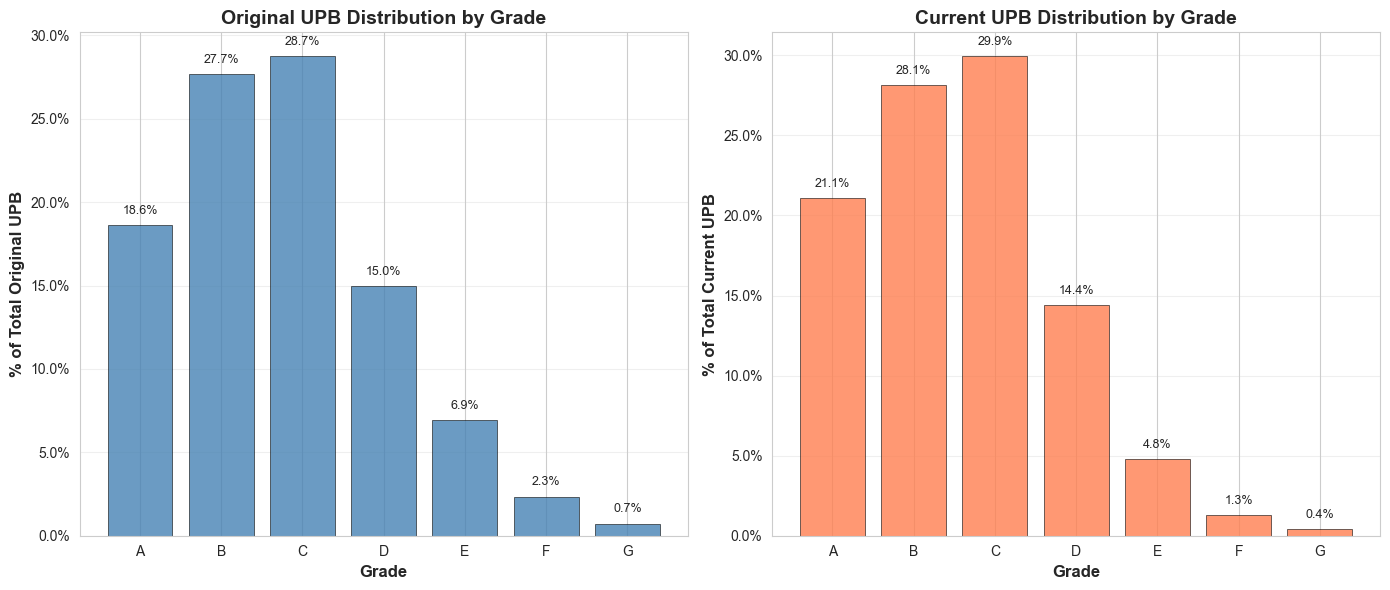

Saved: status_breakdown.png


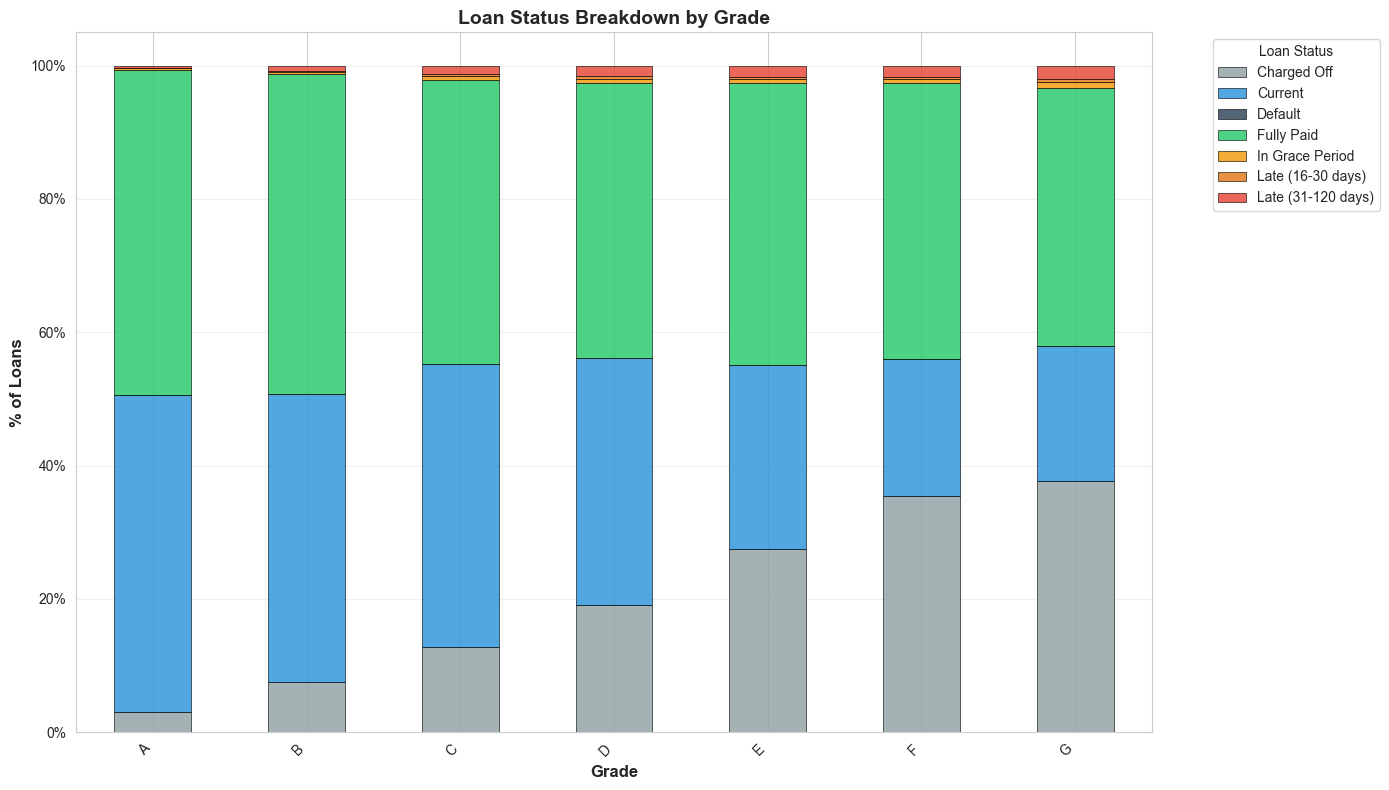

Saved: vintage_performance.png


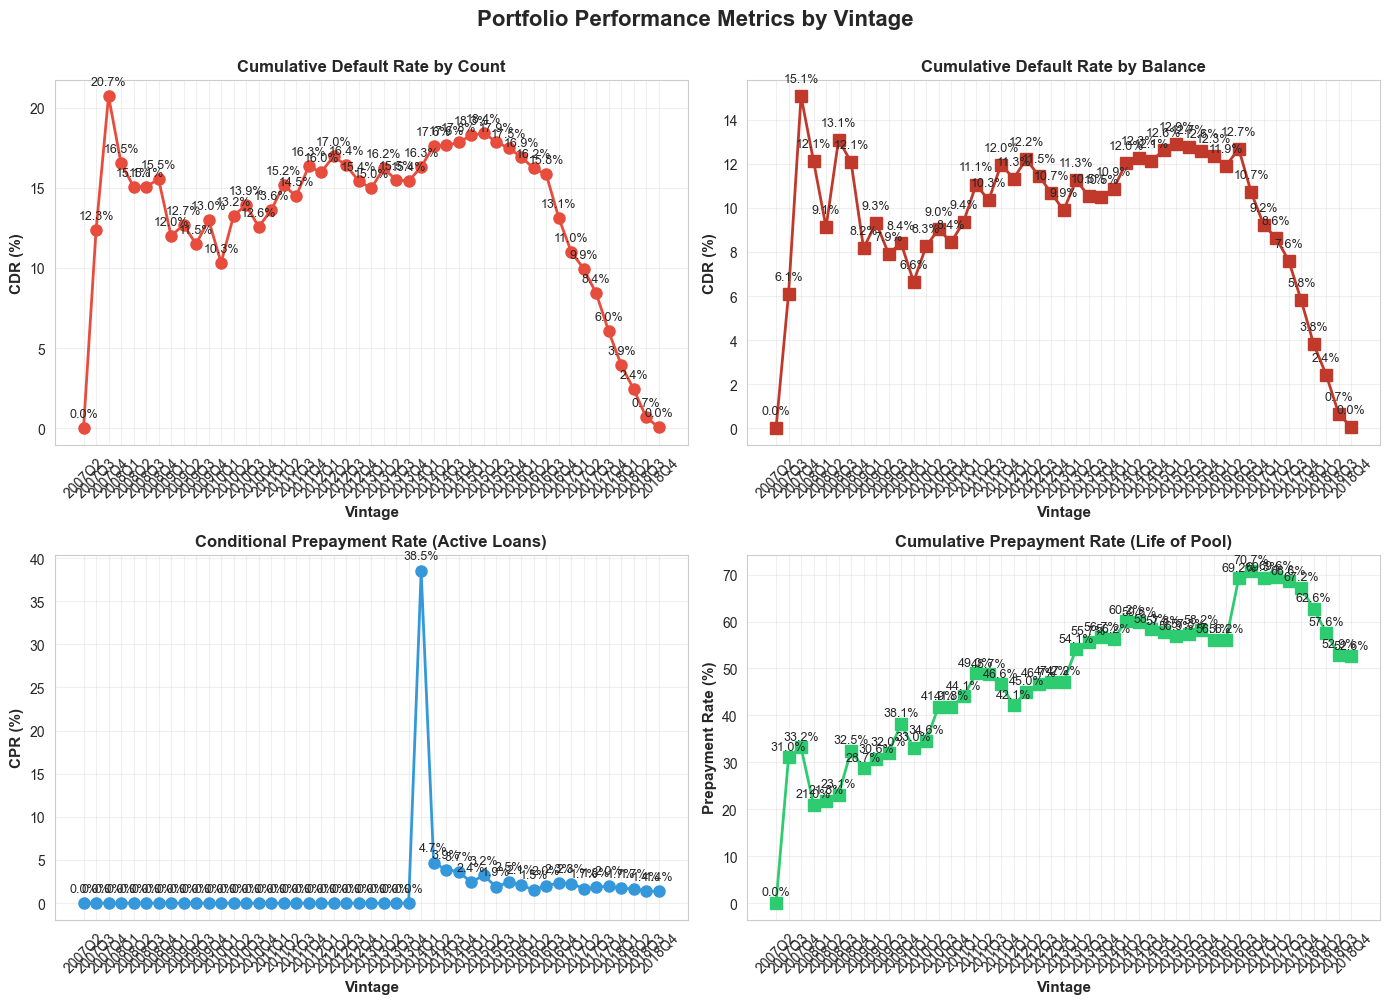

Saved: waterfall.png


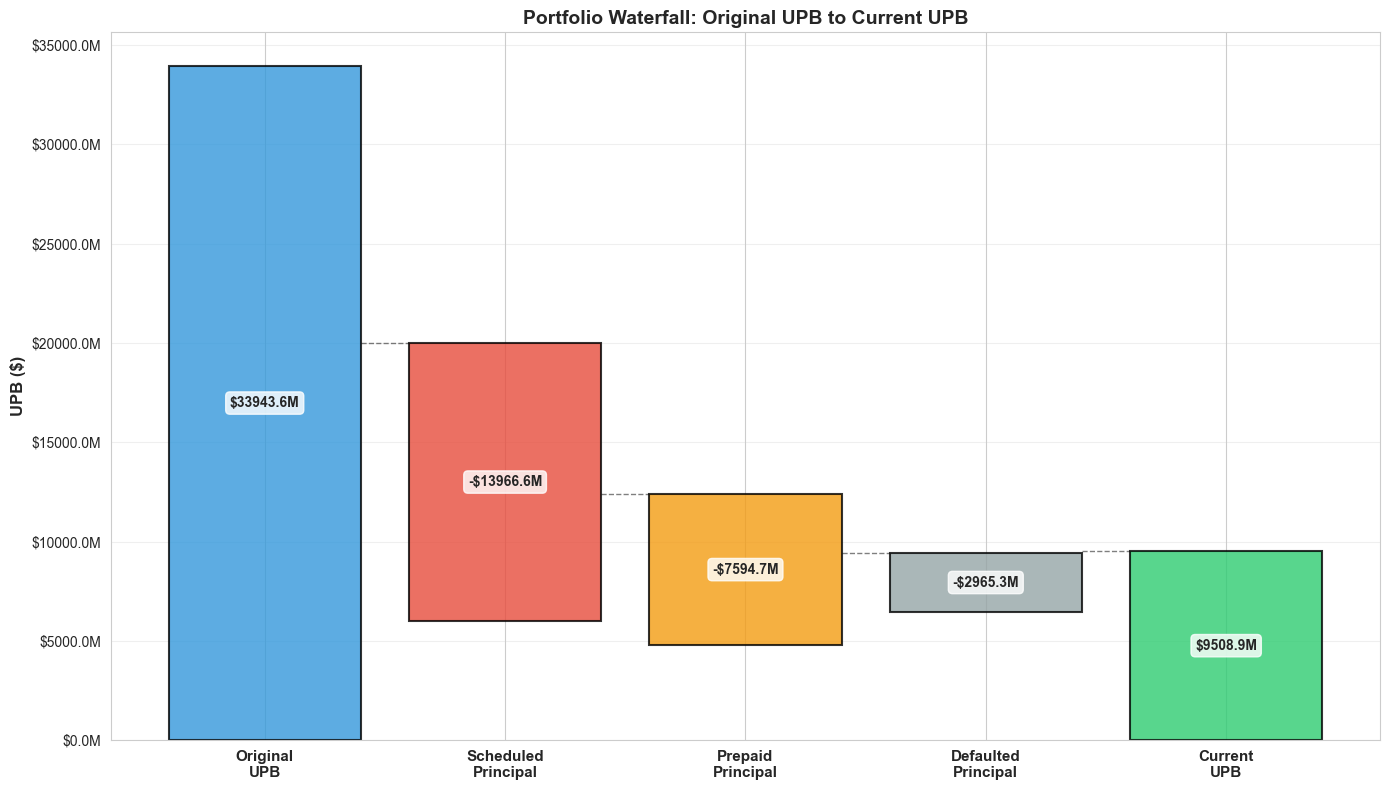

Saved: credit_quality.png


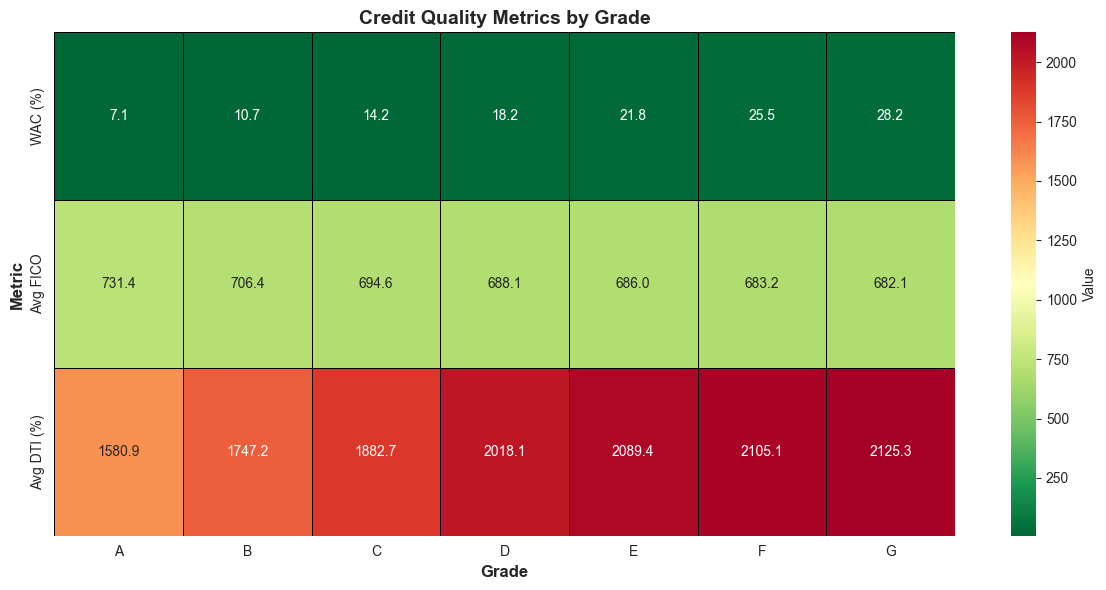

In [120]:
"""
Portfolio Visualization Functions
Create charts and plots for portfolio analytics using matplotlib and seaborn
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter, PercentFormatter
import warnings
warnings.filterwarnings('ignore')

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10


def plot_upb_composition(credit_metrics_df: pd.DataFrame,
                         strata_type: str,
                         figsize: tuple = (14, 6),
                         save_path: str = None):
    """
    Plot original vs current UPB composition by strata value.
    
    Shows % of total UPB for each strata value (e.g., grades A-G).
    
    Parameters:
    -----------
    credit_metrics_df : pd.DataFrame
        Output from calculate_credit_metrics()
    strata_type : str
        Strata type to plot (e.g., 'grade', 'term_months')
    figsize : tuple
        Figure size (width, height)
    save_path : str
        Path to save figure (optional)
    """
    
    # Filter to aggregate rows only (loan_status = 'ALL')
    df = credit_metrics_df[credit_metrics_df['loan_status'] == 'ALL'].copy()
    
    # Calculate percentages
    total_orig = df['orig_total_upb'].sum()
    total_curr = df['curr_total_upb'].sum()
    
    df['orig_pct'] = df['orig_total_upb'] / total_orig * 100
    df['curr_pct'] = df['curr_total_upb'] / total_curr * 100
    
    # Create figure
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
    
    # Plot 1: Original UPB %
    ax1.bar(df['strata_value'].astype(str), df['orig_pct'], 
            color='steelblue', alpha=0.8, edgecolor='black', linewidth=0.5)
    ax1.set_xlabel(strata_type.replace('_', ' ').title(), fontsize=12, fontweight='bold')
    ax1.set_ylabel('% of Total Original UPB', fontsize=12, fontweight='bold')
    ax1.set_title(f'Original UPB Distribution by {strata_type.replace("_", " ").title()}', 
                  fontsize=14, fontweight='bold')
    ax1.yaxis.set_major_formatter(PercentFormatter())
    ax1.grid(axis='y', alpha=0.3)
    
    # Add value labels
    for i, (val, pct) in enumerate(zip(df['strata_value'], df['orig_pct'])):
        ax1.text(i, pct + 0.5, f'{pct:.1f}%', ha='center', va='bottom', fontsize=9)
    
    # Plot 2: Current UPB %
    ax2.bar(df['strata_value'].astype(str), df['curr_pct'], 
            color='coral', alpha=0.8, edgecolor='black', linewidth=0.5)
    ax2.set_xlabel(strata_type.replace('_', ' ').title(), fontsize=12, fontweight='bold')
    ax2.set_ylabel('% of Total Current UPB', fontsize=12, fontweight='bold')
    ax2.set_title(f'Current UPB Distribution by {strata_type.replace("_", " ").title()}', 
                  fontsize=14, fontweight='bold')
    ax2.yaxis.set_major_formatter(PercentFormatter())
    ax2.grid(axis='y', alpha=0.3)
    
    # Add value labels
    for i, (val, pct) in enumerate(zip(df['strata_value'], df['curr_pct'])):
        ax2.text(i, pct + 0.5, f'{pct:.1f}%', ha='center', va='bottom', fontsize=9)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Saved: {save_path}")
    
    plt.show()


def plot_status_breakdown(credit_metrics_df: pd.DataFrame,
                          strata_type: str,
                          figsize: tuple = (14, 8),
                          save_path: str = None):
    """
    Plot stacked bar chart showing loan status breakdown within each strata.
    
    Parameters:
    -----------
    credit_metrics_df : pd.DataFrame
        Output from calculate_credit_metrics()
    strata_type : str
        Strata type to plot
    figsize : tuple
        Figure size
    save_path : str
        Path to save figure
    """
    
    # Filter to status rows only (exclude 'ALL')
    df = credit_metrics_df[credit_metrics_df['loan_status'] != 'ALL'].copy()
    
    # Pivot for stacked bar chart
    pivot_df = df.pivot_table(
        index='strata_value',
        columns='loan_status',
        values='orig_total_upb',
        fill_value=0
    )
    
    # Calculate percentages
    pivot_pct = pivot_df.div(pivot_df.sum(axis=1), axis=0) * 100
    
    # Define colors for each status
    status_colors = {
        'Fully Paid': '#2ecc71',
        'Current': '#3498db',
        'In Grace Period': '#f39c12',
        'Late (16-30 days)': '#e67e22',
        'Late (31-120 days)': '#e74c3c',
        'Charged Off': '#95a5a6',
        'Default': '#34495e'
    }
    
    # Get colors in column order
    colors = [status_colors.get(col, '#7f8c8d') for col in pivot_pct.columns]
    
    # Create stacked bar chart
    fig, ax = plt.subplots(figsize=figsize)
    
    pivot_pct.plot(kind='bar', stacked=True, ax=ax, color=colors, 
                   edgecolor='black', linewidth=0.5, alpha=0.85)
    
    ax.set_xlabel(strata_type.replace('_', ' ').title(), fontsize=12, fontweight='bold')
    ax.set_ylabel('% of Loans', fontsize=12, fontweight='bold')
    ax.set_title(f'Loan Status Breakdown by {strata_type.replace("_", " ").title()}', 
                 fontsize=14, fontweight='bold')
    ax.yaxis.set_major_formatter(PercentFormatter())
    ax.legend(title='Loan Status', bbox_to_anchor=(1.05, 1), loc='upper left')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    ax.grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Saved: {save_path}")
    
    plt.show()


def plot_vintage_performance(performance_df: pd.DataFrame,
                            figsize: tuple = (14, 10),
                            save_path: str = None):
    """
    Plot vintage performance curves (CDR and CPR over time).
    
    Parameters:
    -----------
    performance_df : pd.DataFrame
        Output from calculate_performance_metrics()
    figsize : tuple
        Figure size
    save_path : str
        Path to save figure
    """
    
    # Filter to aggregate rows only
    df = performance_df[performance_df['loan_status'] == 'ALL'].copy()
    
    # Create subplots
    fig, axes = plt.subplots(2, 2, figsize=figsize)
    
    # Plot 1: CDR by Count
    ax1 = axes[0, 0]
    ax1.plot(df['vintage'], df['cdr_count'] * 100, marker='o', linewidth=2, 
             markersize=8, color='#e74c3c', label='CDR (Count)')
    ax1.set_xlabel('Vintage', fontsize=11, fontweight='bold')
    ax1.set_ylabel('CDR (%)', fontsize=11, fontweight='bold')
    ax1.set_title('Cumulative Default Rate by Count', fontsize=12, fontweight='bold')
    ax1.grid(True, alpha=0.3)
    ax1.tick_params(axis='x', rotation=45)
    
    # Add value labels
    for x, y in zip(df['vintage'], df['cdr_count'] * 100):
        ax1.text(x, y + 0.5, f'{y:.1f}%', ha='center', va='bottom', fontsize=9)
    
    # Plot 2: CDR by Balance
    ax2 = axes[0, 1]
    ax2.plot(df['vintage'], df['cdr_balance'] * 100, marker='s', linewidth=2,
             markersize=8, color='#c0392b', label='CDR (Balance)')
    ax2.set_xlabel('Vintage', fontsize=11, fontweight='bold')
    ax2.set_ylabel('CDR (%)', fontsize=11, fontweight='bold')
    ax2.set_title('Cumulative Default Rate by Balance', fontsize=12, fontweight='bold')
    ax2.grid(True, alpha=0.3)
    ax2.tick_params(axis='x', rotation=45)
    
    # Add value labels
    for x, y in zip(df['vintage'], df['cdr_balance'] * 100):
        ax2.text(x, y + 0.5, f'{y:.1f}%', ha='center', va='bottom', fontsize=9)
    
    # Plot 3: CPR
    ax3 = axes[1, 0]
    ax3.plot(df['vintage'], df['pool_cpr'] * 100, marker='o', linewidth=2,
             markersize=8, color='#3498db', label='Pool CPR')
    ax3.set_xlabel('Vintage', fontsize=11, fontweight='bold')
    ax3.set_ylabel('CPR (%)', fontsize=11, fontweight='bold')
    ax3.set_title('Conditional Prepayment Rate (Active Loans)', fontsize=12, fontweight='bold')
    ax3.grid(True, alpha=0.3)
    ax3.tick_params(axis='x', rotation=45)
    
    # Add value labels
    for x, y in zip(df['vintage'], df['pool_cpr'] * 100):
        ax3.text(x, y + 1, f'{y:.1f}%', ha='center', va='bottom', fontsize=9)
    
    # Plot 4: Cumulative Prepayment Rate
    ax4 = axes[1, 1]
    ax4.plot(df['vintage'], df['cumulative_prepay_rate'] * 100, marker='s', linewidth=2,
             markersize=8, color='#2ecc71', label='Cumulative Prepay')
    ax4.set_xlabel('Vintage', fontsize=11, fontweight='bold')
    ax4.set_ylabel('Prepayment Rate (%)', fontsize=11, fontweight='bold')
    ax4.set_title('Cumulative Prepayment Rate (Life of Pool)', fontsize=12, fontweight='bold')
    ax4.grid(True, alpha=0.3)
    ax4.tick_params(axis='x', rotation=45)
    
    # Add value labels
    for x, y in zip(df['vintage'], df['cumulative_prepay_rate'] * 100):
        ax4.text(x, y + 1, f'{y:.1f}%', ha='center', va='bottom', fontsize=9)
    
    plt.suptitle('Portfolio Performance Metrics by Vintage', 
                 fontsize=16, fontweight='bold', y=1.00)
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Saved: {save_path}")
    
    plt.show()


def plot_portfolio_waterfall(df: pd.DataFrame,
                            figsize: tuple = (14, 8),
                            save_path: str = None):
    """
    Plot waterfall chart showing portfolio runoff.
    
    Original UPB → Scheduled Principal → Prepaid Principal → Defaulted → Current UPB
    
    Parameters:
    -----------
    df : pd.DataFrame
        Loan-level data with amortization columns
    figsize : tuple
        Figure size
    save_path : str
        Path to save figure
    """
    
    # Calculate aggregates
    original_upb = df['funded_amnt'].sum()
    current_upb = df['out_prncp'].sum()
    
    # Scheduled principal (as expected from original schedule)
    scheduled_principal = df['orig_exp_principal_paid'].sum()
    
    # Total principal received
    total_principal_received = df['total_rec_prncp'].sum()
    
    # Prepaid principal (excess over scheduled)
    prepaid_principal = (df['total_rec_prncp'] - df['orig_exp_principal_paid']).clip(lower=0).sum()
    
    # Defaulted principal
    defaulted = df[df['loan_status'].isin(['Charged Off', 'Default'])]
    defaulted_principal = (defaulted['funded_amnt'] - defaulted['total_rec_prncp']).sum()
    
    # Build waterfall
    categories = ['Original\nUPB', 'Scheduled\nPrincipal', 'Prepaid\nPrincipal', 
                  'Defaulted\nPrincipal', 'Current\nUPB']
    
    # Values for waterfall
    values = [
        original_upb,           # Starting point
        -scheduled_principal,   # Reduction from scheduled payments
        -prepaid_principal,     # Additional reduction from prepayments
        -defaulted_principal,   # Reduction from defaults
        current_upb            # Ending point
    ]
    
    # Calculate cumulative for positioning
    cumulative = [original_upb]
    for i in range(1, len(values) - 1):
        cumulative.append(cumulative[-1] + values[i])
    cumulative.append(current_upb)
    
    # Create figure
    fig, ax = plt.subplots(figsize=figsize)
    
    # Colors
    colors = ['#3498db', '#e74c3c', '#f39c12', '#95a5a6', '#2ecc71']
    
    # Plot bars
    x_pos = np.arange(len(categories))
    
    # Starting bar
    ax.bar(0, values[0], color=colors[0], edgecolor='black', linewidth=1.5, alpha=0.8)
    
    # Intermediate bars (show reduction)
    for i in range(1, len(values) - 1):
        bottom = cumulative[i]
        height = abs(values[i])
        ax.bar(i, height, bottom=bottom - height, color=colors[i], 
               edgecolor='black', linewidth=1.5, alpha=0.8)
    
    # Ending bar
    ax.bar(len(values) - 1, values[-1], color=colors[-1], 
           edgecolor='black', linewidth=1.5, alpha=0.8)
    
    # Add connector lines
    for i in range(len(cumulative) - 1):
        ax.plot([i + 0.4, i + 0.6], [cumulative[i + 1], cumulative[i + 1]], 
                'k--', linewidth=1, alpha=0.5)
    
    # Format y-axis as currency
    def currency_formatter(x, p):
        return f'${x/1e6:.1f}M'
    ax.yaxis.set_major_formatter(FuncFormatter(currency_formatter))
    
    # Labels
    ax.set_xticks(x_pos)
    ax.set_xticklabels(categories, fontsize=11, fontweight='bold')
    ax.set_ylabel('UPB ($)', fontsize=12, fontweight='bold')
    ax.set_title('Portfolio Waterfall: Original UPB to Current UPB', 
                 fontsize=14, fontweight='bold')
    ax.grid(axis='y', alpha=0.3)
    
    # Add value labels
    for i, (val, cat) in enumerate(zip(values, categories)):
        if i == 0 or i == len(values) - 1:
            # Starting and ending values
            y_pos = val / 2
            label = f'${val/1e6:.1f}M'
        else:
            # Reductions
            y_pos = cumulative[i] - abs(val) / 2
            label = f'-${abs(val)/1e6:.1f}M'
        
        ax.text(i, y_pos, label, ha='center', va='center', 
                fontsize=10, fontweight='bold', 
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Saved: {save_path}")
    
    plt.show()


def plot_credit_quality_heatmap(credit_metrics_df: pd.DataFrame,
                                strata_type: str,
                                metrics: list = ['orig_wac', 'orig_avg_fico', 'orig_avg_dti'],
                                figsize: tuple = (12, 6),
                                save_path: str = None):
    """
    Plot heatmap of credit quality metrics across strata.
    
    Parameters:
    -----------
    credit_metrics_df : pd.DataFrame
        Output from calculate_credit_metrics()
    strata_type : str
        Strata type to plot
    metrics : list
        List of metrics to include in heatmap
    figsize : tuple
        Figure size
    save_path : str
        Path to save figure
    """
    
    # Filter to aggregate rows
    df = credit_metrics_df[credit_metrics_df['loan_status'] == 'ALL'].copy()
    
    # Prepare data for heatmap
    heatmap_data = df[['strata_value'] + metrics].set_index('strata_value')
    
    # Rename columns for display
    column_names = {
        'orig_wac': 'WAC (%)',
        'curr_wac': 'Current WAC (%)',
        'orig_avg_fico': 'Avg FICO',
        'curr_avg_fico': 'Current FICO',
        'orig_avg_dti': 'Avg DTI (%)',
        'curr_avg_dti': 'Current DTI (%)',
        'orig_wam': 'WAM (months)',
        'curr_wam': 'Current WAM'
    }
    
    heatmap_data = heatmap_data.rename(columns=column_names)
    
    # Multiply percentage columns by 100
    for col in heatmap_data.columns:
        if 'WAC' in col or 'DTI' in col:
            heatmap_data[col] = heatmap_data[col] * 100
    
    # Create heatmap
    fig, ax = plt.subplots(figsize=figsize)
    
    sns.heatmap(heatmap_data.T, annot=True, fmt='.1f', cmap='RdYlGn_r',
                linewidths=0.5, linecolor='black', cbar_kws={'label': 'Value'},
                ax=ax)
    
    ax.set_xlabel(strata_type.replace('_', ' ').title(), fontsize=12, fontweight='bold')
    ax.set_ylabel('Metric', fontsize=12, fontweight='bold')
    ax.set_title(f'Credit Quality Metrics by {strata_type.replace("_", " ").title()}',
                 fontsize=14, fontweight='bold')
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Saved: {save_path}")
    
    plt.show()


if __name__ == "__main__":
    print("Portfolio Visualization Functions")
    print("="*80)

grade_metrics = calculate_credit_metrics(df_clean, strata_col='grade')
perf_metrics = calculate_performance_metrics(df_clean, vintage_col='issue_quarter')

# Create visualizations
plot_upb_composition(grade_metrics, strata_type='grade', save_path='upb_composition.png')
plot_status_breakdown(grade_metrics, strata_type='grade', save_path='status_breakdown.png')
plot_vintage_performance(perf_metrics, save_path='vintage_performance.png')
plot_portfolio_waterfall(df_clean, save_path='waterfall.png')
plot_credit_quality_heatmap(grade_metrics, strata_type='grade', save_path='credit_quality.png')


# OLD
 - DONT LOOK AT STUFF BENEATH HERE

#### Logic Check 1: if the total funded amount == the total principal received, the loan should not be considered 'current'
Purpose: Make sure the Current loan status is for loans that still have UPB outstanding

In [11]:
check1 = loan_df[ (loan_df['funded_amnt'] == loan_df["total_rec_prncp"]) & (loan_df['loan_status'] == "Current") ] 
check1

,id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,...,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,hardship_flag,disbursement_method,debt_settlement_flag,issue_month_year,issue_quarter,term_months,maturity_month
1108,68595815,35000.0,35000.0,35000.0,60 months,11.48,769.39,B,B5,Management and Program Analyst,...,NaN,NaN,NaN,N,Cash,N,Dec-2015,2015Q4,60,2020-12
2437,68385225,3700.0,3700.0,3700.0,36 months,10.78,120.75,B,B4,Layout fabricator,...,NaN,NaN,NaN,N,Cash,N,Dec-2015,2015Q4,36,2018-12
3210,68575022,15000.0,15000.0,15000.0,60 months,12.88,340.38,C,C2,Psychologist,...,NaN,NaN,NaN,N,Cash,N,Dec-2015,2015Q4,60,2020-12
4605,68353441,19175.0,19175.0,19175.0,60 months,16.59,472.34,D,D2,Accountant,...,NaN,NaN,NaN,N,Cash,N,Dec-2015,2015Q4,60,2020-12
7478,67206710,21000.0,21000.0,21000.0,60 months,11.99,467.03,C,C1,Administrator,...,NaN,NaN,NaN,N,Cash,N,Dec-2015,2015Q4,60,2020-12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2257790,90178250,8500.0,8500.0,8500.0,36 months,8.59,268.68,A,A5,driver,...,NaN,NaN,NaN,N,Cash,N,Oct-2016,2016Q4,36,2019-10
2258849,90986019,5125.0,5125.0,5125.0,36 months,8.59,162.00,A,A5,Pharmacy technician,...,NaN,NaN,NaN,N,Cash,N,Oct-2016,2016Q4,36,2019-10
2259403,90471276,17500.0,17500.0,17500.0,60 months,26.49,529.05,F,F2,Anemia Nurse,...,NaN,NaN,NaN,N,Cash,N,Oct-2016,2016Q4,60,2021-10
2259733,90905223,12000.0,12000.0,12000.0,36 months,14.49,413.00,C,C4,Associate,...,NaN,NaN,NaN,N,Cash,N,Oct-2016,2016Q4,36,2019-10


In [12]:
# Why might these loans be fully paid off but labeled current? 
# Maybe they were fully paid off in the most recent period but haven't been updatded yet
print("Latest payment data from all data:", loan_df['last_pymnt_d'].max())
print("\nValue counts of loans labeled current but no longer have an outstanding balance:\n", check1['last_pymnt_d'].value_counts())

Latest payment data from all data: 2019-03-01 00:00:00

Value counts of loans labeled current but no longer have an outstanding balance:
 last_pymnt_d
2019-03-01    4214
2019-02-01     322
2018-07-01       1
Name: count, dtype: int64


In [13]:
# See when the next payment was scheduled
for d in check1['last_pymnt_d'].unique():
    print(d.date())
    print(check1[ check1['last_pymnt_d'] == d ]['next_pymnt_d'].value_counts())
    print("\n")

2019-03-01
next_pymnt_d
2019-04-01    4188
2019-03-01      26
Name: count, dtype: int64


2019-02-01
next_pymnt_d
2019-03-01    226
2019-04-01     96
Name: count, dtype: int64


2018-07-01
next_pymnt_d
2018-08-01    1
Name: count, dtype: int64




I think for the subset of loans above, the ones with the next payment date of April 2019 are the loans where my logic checks out. For the other loans, not sure what is going on here. I am going to drop the other loans but keep the 4,188 loans where my logic seems to apply. This is keeping 92% of this sub population, and dropping only 0.015% of the entire loan population. 

In [14]:
# Relabel the above loans to fully paid
mask1 = (loan_df['funded_amnt'] == loan_df["total_rec_prncp"]) & (loan_df['loan_status'] == "Current") & (loan_df['last_pymnt_d'] == "2019-03-01") & (loan_df['next_pymnt_d'] == "2019-04-01")
loan_df.loc[mask1, "loan_status"] = "Fully Paid"

In [15]:
# Drop the loans that don't make sense according to logic check 1
mask2 = (loan_df['funded_amnt'] == loan_df["total_rec_prncp"]) & (loan_df['loan_status'] == "Current") & (loan_df['last_pymnt_d'] != "2019-03-01") # last payment isnt most recent
mask3 = (loan_df['funded_amnt'] == loan_df["total_rec_prncp"]) & (loan_df['loan_status'] == "Current") & (loan_df['last_pymnt_d'] == "2019-03-01") & (loan_df['next_pymnt_d'] != "2019-04-01") # last payment d is most recent but next payment isnt
loan_df = loan_df.loc[ ~mask2, :]
loan_df = loan_df.loc[ ~mask3, :]
loan_df.shape[0] # Started with 2260668

2257570

### Logic Check 2: Check if there are any loans that are labeled fully paid but have an outstanding balance
Purpose: Make sure the fully paid loan status is accurate

In [16]:
# No such loans
loan_df[ (loan_df['loan_status'] == "Fully Paid") & (loan_df['out_prncp'] > 0 ) ]

,id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,...,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,hardship_flag,disbursement_method,debt_settlement_flag,issue_month_year,issue_quarter,term_months,maturity_month


### Logic Check 3: Check late / defaulted loans for how their balances are tracked

In [17]:
check3 = loan_df[~loan_df['loan_status'].isin(['Fully Paid', 'Current'])]
print(check3['loan_status'].value_counts())
check3['loan_status'].value_counts().sum()  # 302,851 loans in total that are not current or fully paid off

loan_status
Charged Off           268559
Late (31-120 days)     21467
In Grace Period         8436
Late (16-30 days)       4349
Default                   40
Name: count, dtype: int64


np.int64(302851)

In [19]:
check3_2 = check3[check3['out_prncp'] == 0]
check3_2 # looks like upb is 0, but they didnt pay back all their principal and they may or may not have gotten recoveries

,id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,...,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,hardship_flag,disbursement_method,debt_settlement_flag,issue_month_year,issue_quarter,term_months,maturity_month
13,66624733,18000.0,18000.0,18000.0,60 months,19.48,471.70,E,E2,Software Manager,...,NaN,NaN,NaN,N,Cash,N,Dec-2015,2015Q4,60,2020-12
25,67849662,4225.0,4225.0,4225.0,36 months,14.85,146.16,C,C5,mechanic,...,NaN,NaN,NaN,N,Cash,N,Dec-2015,2015Q4,36,2018-12
30,67715283,16000.0,16000.0,16000.0,36 months,12.88,538.18,C,C2,"Owner, Fee Appraiser",...,NaN,NaN,NaN,N,Cash,N,Dec-2015,2015Q4,36,2018-12
31,68341789,24250.0,24250.0,24250.0,60 months,24.24,701.01,F,F3,hvac technician,...,NaN,NaN,NaN,N,Cash,N,Dec-2015,2015Q4,60,2020-12
33,68415473,25000.0,25000.0,25000.0,60 months,13.99,581.58,C,C4,Executive Assistant,...,NaN,NaN,NaN,N,Cash,N,Dec-2015,2015Q4,60,2020-12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2260673,88959570,32000.0,32000.0,32000.0,60 months,13.99,744.42,C,C3,Assistant Director,...,NaN,NaN,NaN,N,Cash,N,Oct-2016,2016Q4,60,2021-10
2260677,89968033,11200.0,11200.0,11200.0,60 months,13.49,257.66,C,C2,Sr. Photo Producer,...,NaN,NaN,NaN,N,Cash,N,Oct-2016,2016Q4,60,2021-10
2260685,89007204,36400.0,36400.0,36400.0,60 months,14.49,856.24,C,C4,NaN,...,NaN,NaN,NaN,N,Cash,N,Oct-2016,2016Q4,60,2021-10
2260691,89996426,32000.0,32000.0,32000.0,60 months,14.49,752.74,C,C4,Sales Manager,...,NaN,NaN,NaN,N,Cash,N,Oct-2016,2016Q4,60,2021-10


### Logic Check 4: Check if there are any loans where the funded amount == total principal recieved, but the outstanding principal is greater than 0
Purpose: Make sure the three columns that track UPB all tie out

In [20]:
loan_df[ (loan_df['funded_amnt'] == loan_df["total_rec_prncp"]) & (loan_df['out_prncp'] > 0 ) ]

,id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,...,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,hardship_flag,disbursement_method,debt_settlement_flag,issue_month_year,issue_quarter,term_months,maturity_month


### Logic Check 5: Check loans where total principal recieved == funded amount, but NOT labeled Fully Paid

In [21]:
check5 = loan_df[ (loan_df['funded_amnt'] == loan_df["total_rec_prncp"]) & (loan_df['loan_status'] != "Fully Paid") ] 
check5['loan_status'].value_counts() # 190 loans

loan_status
In Grace Period       107
Late (16-30 days)      35
Late (31-120 days)     26
Charged Off            22
Name: count, dtype: int64

In [22]:
check5['out_prncp'].sum() # no outstanding principal

np.float64(0.0)

In [23]:
check5['last_pymnt_d'].value_counts()#.sum() # mostly up to date loans

last_pymnt_d
2019-03-01    138
2019-02-01     28
2018-03-01      5
2018-07-01      3
2018-12-01      3
2017-11-01      2
2018-09-01      2
2018-11-01      2
2019-01-01      1
2018-04-01      1
2018-05-01      1
2017-03-01      1
2018-08-01      1
2017-12-01      1
2017-09-01      1
Name: count, dtype: int64

In [24]:
check5['next_pymnt_d'].value_counts() # mostly up to date loans
check5['next_pymnt_d'].isna().sum()

np.int64(22)

In [25]:
check5['recoveries'].value_counts() # mostly no recoveries

recoveries
0.00     186
38.73      1
9.11       1
37.67      1
19.21      1
Name: count, dtype: int64

<Axes: >

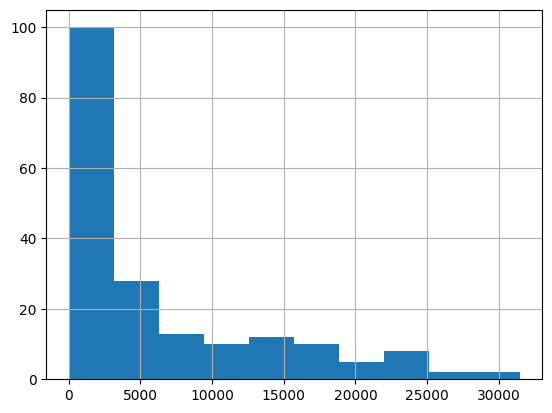

In [26]:
check5['last_pymnt_amnt'].hist()

In [27]:
# keep 130 loans, drop 60
check5[ (check5['last_pymnt_d'] == "2019-03-01") 
            & ( check5['next_pymnt_d'] == "2019-04-01" ) 
            & (check5['out_prncp'] == 0) 
            & (check5['recoveries'] == 0) 
            & (check5['loan_status'].isin(['In Grace Period', 'Late (16-30 days)', 'Late (31-120 days)']))
            ]

,id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,...,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,hardship_flag,disbursement_method,debt_settlement_flag,issue_month_year,issue_quarter,term_months,maturity_month
7746,68000218,30000.0,30000.0,30000.0,36 months,11.22,985.29,B,B5,Sales Manager,...,NaN,NaN,NaN,N,Cash,N,Dec-2015,2015Q4,36,2018-12
18278,67476710,35000.0,35000.0,35000.0,36 months,10.64,1139.90,B,B4,Program Manager,...,NaN,NaN,NaN,N,Cash,N,Dec-2015,2015Q4,36,2018-12
59601,65363176,32200.0,32200.0,32200.0,60 months,14.33,754.76,C,C5,Application Analyst,...,NaN,NaN,NaN,N,Cash,N,Nov-2015,2015Q4,60,2020-11
77975,63580208,16000.0,16000.0,16000.0,60 months,13.67,369.57,C,C4,Store Manager,...,NaN,NaN,NaN,N,Cash,N,Nov-2015,2015Q4,60,2020-11
78016,63247002,17925.0,17925.0,17925.0,60 months,18.99,464.89,E,E3,Financial Analyst,...,NaN,NaN,NaN,N,Cash,N,Nov-2015,2015Q4,60,2020-11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2143962,119819693,16000.0,16000.0,16000.0,36 months,7.21,495.58,A,A3,NaN,...,NaN,NaN,NaN,N,Cash,N,Oct-2017,2017Q4,36,2020-10
2162911,94606768,20000.0,20000.0,20000.0,60 months,12.74,452.41,C,C1,Director of Sales,...,NaN,NaN,NaN,N,Cash,N,Dec-2016,2016Q4,60,2021-12
2192577,94168472,10000.0,10000.0,10000.0,36 months,11.39,329.24,B,B3,Manager,...,NaN,NaN,NaN,N,Cash,N,Dec-2016,2016Q4,36,2019-12
2243294,91278575,25000.0,25000.0,25000.0,36 months,14.49,860.41,C,C4,Accountant,...,NaN,NaN,NaN,N,Cash,N,Oct-2016,2016Q4,36,2019-10


Loans that have the last and next paymdent dates equal to the most recent of the respective dates (March and April 2019), and have no recoveries, and have no outstanding principal should be labelled as fully paid. There are a couple reasons for this decision: 
 * Of the loans that are already labeled fully paid, I am not sure if they were considered delinquent ever because we do not have historical payment data and I am not sure if the delinquency columns in this dataset only apply to this individual loan or to other loans the borrower has taken out. 
 * Although buying individual loans is obviously not buying Agency MBS, in Agency MBS world loans are not bought out until D120. All the loans in late status are between D0 and D120 so in the securitized product world there is precedent for not marking loans non-performing or reperforming for at least 120 days.  
     
The small population of the other loans (60) will be dropped.

In [28]:
# need to run in order because the df is being replaced when each filtering happens
mask5_1 = ( (loan_df['funded_amnt'] == loan_df["total_rec_prncp"]) 
                 &  (loan_df['loan_status'] != "Fully Paid") 
                 &  (loan_df['last_pymnt_d'] != "2019-03-01") 
)
loan_df = loan_df.loc[~mask5_1, :]

mask5_2 = ( (loan_df['funded_amnt'] == loan_df["total_rec_prncp"]) 
                 &  (loan_df['loan_status'] != "Fully Paid") 
                 &  (loan_df['next_pymnt_d'] != "2019-04-01") 
)

loan_df = loan_df.loc[~mask5_2, :]

mask5_3 = ( (loan_df['funded_amnt'] == loan_df["total_rec_prncp"]) 
                 &  (loan_df['loan_status'] != "Fully Paid") 
                 &  (loan_df['recoveries'] != 0) 
)
loan_df = loan_df.loc[~mask5_3, :]
loan_df.shape[0]

2257510

In [31]:
# rename the other 30 loans to fully paid 
mask5_4 = ( (loan_df['funded_amnt'] == loan_df["total_rec_prncp"]) 
                 &  (loan_df['loan_status'] != "Fully Paid") 
                 & (loan_df['last_pymnt_d'] == "2019-03-01")
                 & (loan_df['next_pymnt_d'] == "2019-04-01")
                 &  (loan_df['recoveries'] == 0) 
                 & (loan_df['loan_status'].isin(['In Grace Period', 'Late (16-30 days)', 'Late (31-120 days)']))
)
loan_df.loc[mask5_4, 'loan_status'] = 'Fully Paid'

## Cleaning column values
 - Add value like loss amount (for charged off, outstanding principal - recoveries)
 - Create a single column for metrics like dti and annual income

In [34]:
# Adding a loss column
loan_df['upb_lost'] = np.where(loan_df['loan_status'] == "Charged Off", loan_df['funded_amnt'] - loan_df['total_rec_prncp'] - loan_df['recoveries'] , 0)
loan_df

,id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,...,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,hardship_flag,disbursement_method,debt_settlement_flag,issue_month_year,issue_quarter,term_months,maturity_month,upb_lost
0,68407277,3600.0,3600.0,3600.0,36 months,13.99,123.03,C,C4,leadman,...,NaN,NaN,N,Cash,N,Dec-2015,2015Q4,36,2018-12,0.00
1,68355089,24700.0,24700.0,24700.0,36 months,11.99,820.28,C,C1,Engineer,...,NaN,NaN,N,Cash,N,Dec-2015,2015Q4,36,2018-12,0.00
2,68341763,20000.0,20000.0,20000.0,60 months,10.78,432.66,B,B4,truck driver,...,NaN,NaN,N,Cash,N,Dec-2015,2015Q4,60,2020-12,0.00
3,66310712,35000.0,35000.0,35000.0,60 months,14.85,829.90,C,C5,Information Systems Officer,...,NaN,NaN,N,Cash,N,Dec-2015,2015Q4,60,2020-12,0.00
4,68476807,10400.0,10400.0,10400.0,60 months,22.45,289.91,F,F1,Contract Specialist,...,NaN,NaN,N,Cash,N,Dec-2015,2015Q4,60,2020-12,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2260694,89885898,24000.0,24000.0,24000.0,60 months,12.79,543.50,C,C1,Unit Operator,...,NaN,NaN,N,Cash,N,Oct-2016,2016Q4,60,2021-10,0.00
2260695,88977788,24000.0,24000.0,24000.0,60 months,10.49,515.74,B,B3,Database Administrator,...,NaN,NaN,N,Cash,N,Oct-2016,2016Q4,60,2021-10,0.00
2260696,88985880,40000.0,40000.0,40000.0,60 months,10.49,859.56,B,B3,Vice President,...,NaN,NaN,N,Cash,N,Oct-2016,2016Q4,60,2021-10,0.00
2260697,88224441,24000.0,24000.0,24000.0,60 months,14.49,564.56,C,C4,Program Manager,...,NaN,NaN,N,Cash,Y,Oct-2016,2016Q4,60,2021-10,20478.09


In [110]:
# There are two dti columns, for indivudal and joint
loan_df['application_type'].value_counts()

application_type
Individual    2137040
Joint App      120689
Name: count, dtype: int64

In [35]:
loan_df['dti_clean'] = np.where(loan_df['application_type'] == "Individual", loan_df['dti'], loan_df['dti_joint'])
loan_df['annual_inc_clean'] = np.where(loan_df['application_type'] == "Individual", loan_df['annual_inc'], loan_df['annual_inc_joint'])

In [36]:
loan_df['dti_clean'].describe()

count    2.257506e+06
mean     1.815986e+01
std      8.398324e+00
min     -1.000000e+00
25%      1.188000e+01
50%      1.768000e+01
75%      2.408000e+01
max      6.949000e+01
Name: dti_clean, dtype: float64

In [37]:
loan_df['annual_inc_clean'].describe()

count    2.257510e+06
mean     8.139450e+04
std      1.137598e+05
min      1.900000e+03
25%      4.800000e+04
50%      6.850000e+04
75%      9.800000e+04
max      1.100000e+08
Name: annual_inc_clean, dtype: float64

In [122]:
# There are 1.4k loans where the dti is <= 0. Using the total current balance adn the annual income columns i can estimate dti for this population
loan_df[loan_df['dti_clean'] <= 0]  # CANT DO THIS, DTI IS BASED ON THE MONTHLY PAYMENT

,id,purpose,issue_d,int_rate,term,addr_state,zip_code,loan_status,loan_amnt,funded_amnt,...,pymnt_plan,mths_since_last_delinq,open_acc,recoveries,issue_month_year,issue_quarter,term_months,maturity_month,dti_clean,annual_inc_clean
1167,68615828,home_improvement,2015-12-01,18.49,36 months,CA,945xx,Fully Paid,10850.0,10850.0,...,n,NaN,2.0,0.00,Dec-2015,2015Q4,36,2018-12,0.0,47000.0
3418,67605866,car,2015-12-01,10.78,36 months,CT,062xx,Fully Paid,4000.0,4000.0,...,n,NaN,5.0,0.00,Dec-2015,2015Q4,36,2018-12,0.0,36000.0
4350,68503950,home_improvement,2015-12-01,18.49,60 months,FL,320xx,Current,12000.0,12000.0,...,n,NaN,1.0,0.00,Dec-2015,2015Q4,60,2020-12,0.0,48000.0
4590,68353718,major_purchase,2015-12-01,8.49,36 months,GA,301xx,Fully Paid,5000.0,5000.0,...,n,NaN,2.0,0.00,Dec-2015,2015Q4,36,2018-12,0.0,50000.0
4779,66542505,other,2015-12-01,11.99,36 months,NY,117xx,Charged Off,4000.0,4000.0,...,n,21.0,7.0,0.00,Dec-2015,2015Q4,36,2018-12,0.0,94000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2253371,91279541,home_improvement,2016-10-01,26.49,60 months,MI,480xx,Fully Paid,12000.0,12000.0,...,n,19.0,5.0,0.00,Oct-2016,2016Q4,60,2021-10,0.0,38000.0
2255096,90926410,major_purchase,2016-10-01,13.49,36 months,NY,119xx,Charged Off,6925.0,6925.0,...,n,18.0,15.0,479.66,Oct-2016,2016Q4,36,2019-10,0.0,80000.0
2255200,91018039,debt_consolidation,2016-10-01,24.99,60 months,NY,119xx,Fully Paid,16550.0,16550.0,...,n,67.0,8.0,0.00,Oct-2016,2016Q4,60,2021-10,0.0,46000.0
2258284,90835542,home_improvement,2016-10-01,19.99,36 months,FL,324xx,Charged Off,10800.0,10800.0,...,n,NaN,3.0,23439.24,Oct-2016,2016Q4,36,2019-10,0.0,54559.0


In [128]:
mask3 = loan_df["dti"] <= 0 
loan_df.loc[mask3, 'dti_clean'] = loan_df.loc[mask3, 'tot_cur_bal'] / loan_df.loc[mask3, 'annual_inc_clean'] 
df3 = loan_df[loan_df['dti_clean'] <= 0]
df3

,id,purpose,issue_d,int_rate,term,addr_state,zip_code,loan_status,loan_amnt,funded_amnt,...,pymnt_plan,mths_since_last_delinq,open_acc,recoveries,issue_month_year,issue_quarter,term_months,maturity_month,dti_clean,annual_inc_clean
4350,68503950,home_improvement,2015-12-01,18.49,60 months,FL,320xx,Current,12000.0,12000.0,...,n,NaN,1.0,0.0,Dec-2015,2015Q4,60,2020-12,0.0,48000.0
4779,66542505,other,2015-12-01,11.99,36 months,NY,117xx,Charged Off,4000.0,4000.0,...,n,21.0,7.0,0.0,Dec-2015,2015Q4,36,2018-12,0.0,94000.0
29523,66490374,home_improvement,2015-12-01,7.89,36 months,CA,951xx,Fully Paid,20000.0,20000.0,...,n,NaN,7.0,0.0,Dec-2015,2015Q4,36,2018-12,0.0,52000.0
32894,66500892,other,2015-12-01,9.17,36 months,MN,553xx,Fully Paid,1800.0,1800.0,...,n,22.0,1.0,0.0,Dec-2015,2015Q4,36,2018-12,0.0,88000.0
37410,65854446,debt_consolidation,2015-12-01,11.99,60 months,NJ,080xx,Current,35000.0,35000.0,...,n,NaN,3.0,0.0,Dec-2015,2015Q4,60,2020-12,0.0,75000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2210770,92259202,home_improvement,2016-11-01,6.99,36 months,MI,481xx,Fully Paid,3000.0,3000.0,...,n,28.0,4.0,0.0,Nov-2016,2016Q4,36,2019-11,0.0,40000.0
2212746,93115203,vacation,2016-11-01,11.44,36 months,NC,276xx,Current,10000.0,10000.0,...,n,NaN,9.0,0.0,Nov-2016,2016Q4,36,2019-11,0.0,20000.0
2220721,91960285,major_purchase,2016-11-01,16.99,36 months,CA,940xx,Fully Paid,5000.0,5000.0,...,n,NaN,4.0,0.0,Nov-2016,2016Q4,36,2019-11,0.0,100000.0
2224191,92533501,home_improvement,2016-11-01,17.99,36 months,MI,490xx,Fully Paid,10000.0,10000.0,...,n,NaN,12.0,0.0,Nov-2016,2016Q4,36,2019-11,0.0,38000.0


In [129]:
loan_df['purpose'].value_counts()

purpose
debt_consolidation    1276662
credit_card            516599
home_improvement       150226
other                  139000
major_purchase          50318
medical                 27427
small_business          24528
car                     23947
vacation                15506
moving                  15357
house                   14091
wedding                  2299
renewable_energy         1442
educational               327
Name: count, dtype: int64

In [91]:
# The credit metrics should be done on each sub population. 
# Combining the various type of loan statuses does not provide as much insight as looking at the various credit metrics among each loan status type
curr_loans = loan_df[loan_df['loan_status'] == "Current"]
paid_loans = loan_df[loan_df['loan_status'] == "Fully Paid"]
charged_loans = loan_df[loan_df['loan_status'] == "Charged Off"]
late_loans = loan_df[loan_df['loan_status'].isin( ['In Grace Period', 'Late (16-30 days)', 'Late (31-120 days)'] )]
default_loans = loan_df[loan_df['loan_status'] == "Default"]

all_loans = {"Current": curr_loans, 
             "Fully Paid": paid_loans, 
             "Charged Off": charged_loans, 
             "Late": late_loans, 
             "Default": default_loans
             } 

for k, v in all_loans.items(): 
    print("Loan Status:", k, "\nNumber of Loans:", v.shape[0])



Loan Status: Current 
Number of Loans: 873780
Loan Status: Fully Paid 
Number of Loans: 1081288
Loan Status: Charged Off 
Number of Loans: 268537
Loan Status: Late 
Number of Loans: 34084
Loan Status: Default 
Number of Loans: 40


## Current Loans

In [93]:
curr_loans[curr_loans['out_prncp'] == 0]    # no current loans with 0 UPB

,id,purpose,issue_d,int_rate,term,addr_state,zip_code,loan_status,loan_amnt,funded_amnt,...,tot_cur_bal,mths_since_last_record,pymnt_plan,mths_since_last_delinq,open_acc,recoveries,issue_month_year,issue_quarter,term_months,maturity_month


In [95]:
curr_loans['last_pymnt_d'].value_counts()

last_pymnt_d
2019-03-01    821603
2019-02-01     52171
2018-07-01         2
2019-01-01         2
2018-10-01         1
2018-02-01         1
Name: count, dtype: int64

In [96]:
curr_loans['next_pymnt_d'].value_counts()

next_pymnt_d
2019-04-01    873663
2019-05-01        96
2019-03-01        17
2018-09-01         2
2018-12-01         1
2018-02-01         1
Name: count, dtype: int64

In [101]:
# Most current loans paid in march and are scheduled to pay in april. Lets look at the relative large amount that last paid in Feb to see if they are late
feb_curr = curr_loans[curr_loans['last_pymnt_d'] == "2019-02-01"]
feb_curr[feb_curr['last_pymnt_amnt'] != feb_curr['installment']]

,id,purpose,issue_d,int_rate,term,addr_state,zip_code,loan_status,loan_amnt,funded_amnt,...,tot_cur_bal,mths_since_last_record,pymnt_plan,mths_since_last_delinq,open_acc,recoveries,issue_month_year,issue_quarter,term_months,maturity_month
296,68374806,credit_card,2015-12-01,13.44,60 months,NY,140xx,Current,20000.0,20000.0,...,76322.0,NaN,n,37.0,22.0,0.0,Dec-2015,2015Q4,60,2020-12
705,68616377,credit_card,2015-12-01,19.48,60 months,OK,740xx,Current,24000.0,24000.0,...,267616.0,NaN,n,NaN,11.0,0.0,Dec-2015,2015Q4,60,2020-12
726,68386637,debt_consolidation,2015-12-01,14.85,36 months,TX,774xx,Current,3500.0,3500.0,...,32109.0,NaN,n,23.0,14.0,0.0,Dec-2015,2015Q4,36,2018-12
965,68514195,moving,2015-12-01,20.50,60 months,PA,156xx,Current,18000.0,18000.0,...,152370.0,NaN,n,12.0,7.0,0.0,Dec-2015,2015Q4,60,2020-12
1103,68356041,debt_consolidation,2015-12-01,14.85,60 months,NY,104xx,Current,12000.0,12000.0,...,8438.0,NaN,n,NaN,4.0,0.0,Dec-2015,2015Q4,60,2020-12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2238492,91655913,debt_consolidation,2016-10-01,17.99,60 months,FL,339xx,Current,14000.0,14000.0,...,82716.0,NaN,n,75.0,19.0,0.0,Oct-2016,2016Q4,60,2021-10
2239974,91163169,major_purchase,2016-10-01,11.39,36 months,CA,904xx,Current,10200.0,10200.0,...,39158.0,NaN,n,42.0,7.0,0.0,Oct-2016,2016Q4,36,2019-10
2248357,91061339,debt_consolidation,2016-10-01,12.79,36 months,MO,631xx,Current,21000.0,21000.0,...,138011.0,NaN,n,81.0,24.0,0.0,Oct-2016,2016Q4,36,2019-10
2249026,91300955,debt_consolidation,2016-10-01,7.59,36 months,MA,020xx,Current,40000.0,40000.0,...,952276.0,NaN,n,29.0,34.0,0.0,Oct-2016,2016Q4,36,2019-10


In [105]:
feb_curr[feb_curr['mths_since_last_delinq'] < 10]['mths_since_last_delinq'].value_counts()

mths_since_last_delinq
6.0    495
9.0    460
7.0    434
8.0    424
4.0    376
5.0    363
3.0    320
2.0    194
1.0    139
0.0     53
Name: count, dtype: int64

In [97]:
# some of the borrowers have been delinquent, however not sur if that is just this loan or on other accounts. Will count all current status as current rather than RPL
curr_loans['mths_since_last_delinq'].describe()

count    413435.000000
mean         34.999129
std          21.863716
min           0.000000
25%          17.000000
50%          32.000000
75%          51.000000
max         195.000000
Name: mths_since_last_delinq, dtype: float64

In [106]:
curr_loans['dti'].describe()

count    872485.000000
mean         19.620984
std          17.749318
min           0.000000
25%          12.050000
50%          18.180000
75%          25.160000
max         999.000000
Name: dti, dtype: float64

In [109]:
dti0 = curr_loans[curr_loans['dti'] == 0]
dti0

,id,purpose,issue_d,int_rate,term,addr_state,zip_code,loan_status,loan_amnt,funded_amnt,...,tot_cur_bal,mths_since_last_record,pymnt_plan,mths_since_last_delinq,open_acc,recoveries,issue_month_year,issue_quarter,term_months,maturity_month
4350,68503950,home_improvement,2015-12-01,18.49,60 months,FL,320xx,Current,12000.0,12000.0,...,0.0,NaN,n,NaN,1.0,0.0,Dec-2015,2015Q4,60,2020-12
37410,65854446,debt_consolidation,2015-12-01,11.99,60 months,NJ,080xx,Current,35000.0,35000.0,...,0.0,NaN,n,NaN,3.0,0.0,Dec-2015,2015Q4,60,2020-12
93065,63434561,major_purchase,2015-10-01,13.33,60 months,OH,438xx,Current,12000.0,12000.0,...,0.0,NaN,n,29.0,6.0,0.0,Oct-2015,2015Q4,60,2020-10
94945,63244119,major_purchase,2015-10-01,8.18,60 months,MO,639xx,Current,27000.0,27000.0,...,0.0,NaN,n,NaN,5.0,0.0,Oct-2015,2015Q4,60,2020-10
211287,55462200,major_purchase,2015-07-01,13.99,60 months,VA,227xx,Current,30000.0,30000.0,...,203221.0,NaN,n,19.0,4.0,0.0,Jul-2015,2015Q3,60,2020-07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2199289,93970637,other,2016-11-01,26.24,36 months,CA,952xx,Current,3200.0,3200.0,...,252293.0,NaN,n,NaN,5.0,0.0,Nov-2016,2016Q4,36,2019-11
2212746,93115203,vacation,2016-11-01,11.44,36 months,NC,276xx,Current,10000.0,10000.0,...,0.0,NaN,n,NaN,9.0,0.0,Nov-2016,2016Q4,36,2019-11
2235782,91949093,debt_consolidation,2016-10-01,13.99,60 months,AZ,852xx,Current,28000.0,28000.0,...,40797.0,84.0,n,NaN,9.0,0.0,Oct-2016,2016Q4,60,2021-10
2250211,91061942,major_purchase,2016-10-01,7.59,36 months,KS,662xx,Current,20000.0,20000.0,...,2122.0,NaN,n,43.0,5.0,0.0,Oct-2016,2016Q4,36,2019-10


## Performance Metrics
 - Using the loan data, I can create an amortization schedule and see what the total prepay over the life of the loan is. 
 - I can also see what the cpr of the last payment was

In [ ]:
import numpy as np
import pandas as pd

def add_expected_amort_asof(
    df: pd.DataFrame,
    *,
    principal_col: str = "funded_amnt",
    rate_col: str = "int_rate",          # annual percentage, e.g. 13.56
    term_col: str = "term_months",       # integer months
    issue_col: str = "issue_d",
    asof_col: str = "last_pymnt_d",
    out_prncp_col: str | None = "out_prncp",
    payment_col: str | None = None,      # e.g. "installment" if you want to include it
    prefix: str = "exp_",
    clip_k: bool = True,
) -> pd.DataFrame:
    """
    Closed-form amortization with aggressive penny-rounding applied at each intermediate step.
    NOTE: This is *not* the same as month-by-month posting, but it will eliminate most float dust.
    """
    out = df.copy()

    def r2(x):
        # works for numpy arrays/scalars; leaves NaN as NaN
        return np.round(x, 2)

    # --- Pull arrays ---
    P0 = pd.to_numeric(out[principal_col], errors="coerce").to_numpy(dtype="float64")
    N  = pd.to_numeric(out[term_col], errors="coerce").to_numpy(dtype="float64")
    apr = pd.to_numeric(out[rate_col], errors="coerce").to_numpy(dtype="float64") / 100.0

    # round inputs that represent money-like quantities
    P0 = r2(P0)

    # rates are not money, but to match “two-decimal throughout” we can optionally round APR/r
    # (this may actually worsen realism; keeping more precision is usually better)
    # If you truly want 2-decimal everywhere, uncomment the next line:
    # apr = r2(apr)

    r = apr / 12.0
    # If you truly want 2-decimal everywhere, uncomment:
    r = r2(r)

    # --- Month index k: issue month=0, first payment month=1 ---
    issue_dt = pd.to_datetime(out[issue_col], errors="coerce")
    asof_dt  = pd.to_datetime(out[asof_col],  errors="coerce")

    k = (
        (asof_dt.dt.year - issue_dt.dt.year) * 12
        + (asof_dt.dt.month - issue_dt.dt.month)
    ).to_numpy(dtype="float64")

    if clip_k:
        k = np.where(np.isnan(k) | np.isnan(N), np.nan, k)
        k = np.minimum(np.maximum(k, 0.0), N)

    # k is a count; keep as float for NaNs, but it's effectively integer months
    # If you want to force integer months:
    # k = np.floor(k)

    # --- Compute PMT (fully amortizing) ---
    pmt = np.full_like(P0, np.nan, dtype="float64")

    valid = (~np.isnan(P0)) & (~np.isnan(N)) & (N > 0) & (~np.isnan(r)) & (~np.isnan(k))
    zero_r = valid & (np.isclose(r, 0.0))
    pos_r  = valid & (~np.isclose(r, 0.0))

    # r==0: pmt = P0 / N
    pmt[zero_r] = r2(P0[zero_r] / N[zero_r])

    # r>0: PMT = P0 * r / (1 - (1+r)^-N)
    one_plus_r = 1.0 + r
    # If forcing two-decimal everywhere, round here too:
    # one_plus_r = r2(one_plus_r)

    pow_negN = np.full_like(P0, np.nan)
    pow_negN[pos_r] = np.power(one_plus_r[pos_r], -N[pos_r])
    # Optional rounding:
    # pow_negN = r2(pow_negN)

    denom = np.full_like(P0, np.nan)
    denom[pos_r] = 1.0 - pow_negN[pos_r]
    # Optional rounding:
    # denom = r2(denom)

    pmt[pos_r] = r2(P0[pos_r] * r[pos_r] / denom[pos_r])

    # --- Expected balance after k payments (UPB) ---
    upb = np.full_like(P0, np.nan, dtype="float64")

    # r==0: UPB = P0 - k*PMT
    upb[zero_r] = r2(P0[zero_r] - r2(k[zero_r] * pmt[zero_r]))

    # r>0: B_k = P0*(1+r)^k - PMT * (((1+r)^k - 1)/r)
    growth = np.full_like(P0, np.nan)
    growth[pos_r] = np.power(one_plus_r[pos_r], k[pos_r])
    # Optional rounding:
    # growth = r2(growth)

    term1 = np.full_like(P0, np.nan)
    term1[pos_r] = P0[pos_r] * growth[pos_r]
    # Optional rounding:
    # term1 = r2(term1)

    annuity = np.full_like(P0, np.nan)
    annuity[pos_r] = (growth[pos_r] - 1.0) / r[pos_r]
    # Optional rounding:
    # annuity = r2(annuity)

    term2 = np.full_like(P0, np.nan)
    term2[pos_r] = pmt[pos_r] * annuity[pos_r]
    # Optional rounding:
    # term2 = r2(term2)

    upb[pos_r] = r2(term1[pos_r] - term2[pos_r])

    # numeric safety
    upb = np.where(valid, np.maximum(upb, 0.0), np.nan)
    upb = r2(upb)

    # --- Cumulative principal paid through k ---
    cum_prin = np.where(valid, r2(P0 - upb), np.nan)
    cum_prin = r2(cum_prin)

    # --- Cumulative interest paid through k ---
    total_paid = np.where(valid, r2(k * pmt), np.nan)
    total_paid = r2(total_paid)

    cum_int = np.where(valid, r2(total_paid - cum_prin), np.nan)
    cum_int = r2(cum_int)

    # --- Scheduled interest/principal in the k-th payment ---
    int_in_k = np.where(valid, 0.0, np.nan)
    prin_in_k = np.where(valid, 0.0, np.nan)

    has_payment = valid & (k >= 1)

    if np.any(has_payment):
        km1 = np.where(has_payment, k - 1.0, 0.0)

        Bm1 = np.full_like(P0, np.nan, dtype="float64")

        # r==0: B_{k-1} = P0 - (k-1)*PMT
        m1_zero = has_payment & np.isclose(r, 0.0)
        Bm1[m1_zero] = r2(P0[m1_zero] - r2(km1[m1_zero] * pmt[m1_zero]))

        # r>0: closed form at (k-1)
        m1_pos = has_payment & (~np.isclose(r, 0.0))
        growth_m1 = np.power(one_plus_r[m1_pos], km1[m1_pos])
        # Optional rounding:
        # growth_m1 = r2(growth_m1)

        term1_m1 = P0[m1_pos] * growth_m1
        annuity_m1 = (growth_m1 - 1.0) / r[m1_pos]
        term2_m1 = pmt[m1_pos] * annuity_m1
        Bm1[m1_pos] = r2(term1_m1 - term2_m1)

        Bm1 = np.where(has_payment, np.maximum(Bm1, 0.0), Bm1)
        Bm1 = r2(Bm1)

        # interest = round(Bm1 * r, 2)
        int_k = r2(Bm1 * r)
        prin_k = r2(pmt - int_k)

        # safety clamp
        prin_k = np.minimum(prin_k, Bm1)
        prin_k = r2(prin_k)

        int_in_k = np.where(has_payment, np.maximum(int_k, 0.0), 0.0)
        prin_in_k = np.where(has_payment, np.maximum(prin_k, 0.0), 0.0)

    int_in_k = r2(int_in_k)
    prin_in_k = r2(prin_in_k)

    # --- write outputs ---
    out[f"{prefix}k_payments"] = k  # keep as float; or cast to Int64 if you want
    out[f"{prefix}pmt_calc"] = pmt
    out[f"{prefix}upb"] = upb
    out[f"{prefix}cum_prin_paid"] = cum_prin
    out[f"{prefix}cum_int_paid"] = cum_int
    out[f"{prefix}int_in_k"] = int_in_k
    out[f"{prefix}prin_in_k"] = prin_in_k

    if payment_col is not None and payment_col in out.columns:
        inst = pd.to_numeric(out[payment_col], errors="coerce").to_numpy(dtype="float64")
        inst = r2(inst)
        out[f"{prefix}pmt_diff_vs_{payment_col}"] = r2(inst - pmt)

    if out_prncp_col is not None and out_prncp_col in out.columns:
        actual = pd.to_numeric(out[out_prncp_col], errors="coerce").to_numpy(dtype="float64")
        actual = r2(actual)
        diff = r2(upb - actual)
        out[f"{prefix}upb_minus_actual"] = diff

    return out


test_df = loan_df[loan_df['loan_status'] == "Current"].iloc[:10]

test_df = add_expected_amort_asof(
    test_df,
    principal_col="funded_amnt",
    rate_col="int_rate",
    term_col="term_months",
    issue_col="issue_d",
    asof_col="last_pymnt_d",
    out_prncp_col="out_prncp",
    payment_col="installment",   # optional
    prefix="exp_",
)



In [55]:
test_df

,id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,...,exp_pmt_calc,exp_upb,exp_cum_prin_paid,exp_cum_int_paid,exp_int_in_k,exp_prin_in_k,exp_pmt_diff_vs_installment,exp_upb_minus_actual,exp_cum_prepay_to_date_signed,exp_cum_prepay_to_date_pos
3,66310712,35000.0,35000.0,35000.0,60 months,14.85,829.90,C,C5,Information Systems Officer,...,829.89,15898.13,19101.87,12433.95,204.48,625.41,0.01,0.48,0.48,0.48
10,68356421,22400.0,22400.0,22400.0,60 months,12.88,508.30,C,C2,Executive Director,...,508.29,9913.35,12486.65,6828.37,110.67,397.62,0.01,0.47,0.47,0.47
11,68426545,16000.0,16000.0,16000.0,60 months,12.88,363.07,C,C2,Senior Structural Designer,...,363.07,7080.70,8919.30,4877.36,79.05,284.02,0.00,0.00,0.00,0.00
18,68506798,23000.0,23000.0,23000.0,60 months,8.49,471.77,B,B1,Teacher,...,471.77,9580.20,13419.80,4507.46,70.62,401.15,0.00,0.00,0.00,0.00
34,68537655,16800.0,16800.0,16800.0,60 months,12.88,381.23,C,C2,CEO,...,381.22,7434.90,9365.10,5121.26,83.00,298.22,0.01,0.47,0.47,0.47
42,68615044,16000.0,16000.0,16000.0,60 months,13.99,372.21,C,C4,Registered Nurse,...,372.21,7186.06,8813.94,5330.04,87.10,285.11,0.00,0.00,0.00,0.00
48,68617034,14650.0,14650.0,14650.0,60 months,20.50,392.23,E,E4,Senior Service Specialist,...,392.22,6872.58,7777.42,7519.16,122.02,270.20,0.01,-269.67,-269.67,0.00
51,68516838,23850.0,23850.0,23850.0,60 months,17.27,596.21,D,D3,Teacher,...,596.20,10739.37,13110.63,10141.17,160.82,435.38,0.01,-434.88,-434.88,0.00
52,68476697,15700.0,15700.0,15700.0,60 months,16.59,386.74,D,D2,Teacher,...,386.73,7293.12,8406.88,6288.86,104.73,282.00,0.01,0.49,0.49,0.49
53,68566856,28800.0,28800.0,28800.0,60 months,11.99,640.50,C,C1,Office Manager,...,640.49,12593.73,16206.27,8132.35,130.92,509.57,0.01,0.46,0.46,0.46


## Part 1: Analyzing the Entire Dataset  
I had to do some reserach online to understand Lending Club's (LC) business model and their data.  
  
LC is a peer to peer lending platform. Borrowers apply for a a loan with a specific amount, term, and purpose, and provide additional information like credit scores, employment, etc.. Once the loan is approved by LC, LC assigns a grade (A-G) and an interest rate. At this point, the loan is still considered unfunded until lenders decide to invest in the loan (partial investment is allowed, lenders don't have to fund the entire loan). Once the loan is fully funded it is considered originated and LC begins servicing the loan and investors begin earning interest. All of the loans in the dataset above have been approved by LC and funded by borrowers.   
  
The dataset is not a time series dataset (I ascertained this by looking into the data a little bit), it is a snapshot of the status of all loans that had been accepted/funded between 2007 and 2018 as of 2018. 
  
I referred to various sources and other people's projects to understand the data better and reduce the amount of assumptions I have to make. 
 * LC's description of loan status - https://www.lendingclub.com/help/investing-faq/what-do-the-different-note-statuses-mean
 * An excel data dictionary containing descriptions of all 153 columns - https://github.com/Rohini2505/Lending-Club-Loan-Analysis
 * Kaggle user project - https://www.kaggle.com/code/braindeadcoder/understanding-lending-club-s-data-with-eda
 * Other Kaggle user project - https://www.kaggle.com/code/pavlofesenko/minimizing-risks-for-loan-investments/notebook

In [5]:
# 151 columns, 2.26 million rows
loan_df.shape

(2260668, 151)

## Understanding the entire dataset
As far as I can tell, part 1 of the coding project is asking me to look at the characteristics of the entire dataset, regardless of loan status. I think this makes sense given all the loans in the dataset were approved at some point and were fully funded.  
  
At first, I did have some pause as to whether or not I should be looking at ALL loans since some of them are non-investable (like fully paid or charged off loans) or have fundamentally different investment characteristics (non-peforming vs reperforming vs current). However, I will leave this stratafication to the later sections that involve making investment decisions rather than just exploratory data analysis. 

In [6]:
# Quick check to see how many null values are in each column
# After looking at the results, it appears the columns needed to compute the cashflow and scnenario analyses don't have missing data
# COME BACK AND CLEAN DATA MORE PROPERLY - do all the calculations and date/number transformations here
null_summary = (
    loan_df
    .isna()
    .agg(["sum", "mean"])
    .T
    .rename(columns={"sum": "null_count", "mean": "null_pct"})
)
null_summary["null_pct"] = (null_summary["null_pct"] * 100).round(2)
null_summary = null_summary.sort_values("null_count", ascending=False)
null_summary

,null_count,null_pct
member_id,2260668.0,100.00
orig_projected_additional_accrued_interest,2252017.0,99.62
hardship_reason,2249751.0,99.52
hardship_payoff_balance_amount,2249751.0,99.52
hardship_last_payment_amount,2249751.0,99.52
...,...,...
total_rec_int,0.0,0.00
total_rec_prncp,0.0,0.00
hardship_flag,0.0,0.00
disbursement_method,0.0,0.00


### Pool Stratas

In [7]:
specs = ["grade", "term", "purpose", "addr_state", "issue_quarter"]


def explore_categorical(df, col):
    total_rows = len(df)

    print(f"\n{'='*80}")
    print(f"STRATA: {col}")
    print(f"{'='*80}")

    null_count = df[col].isna().sum()
    null_pct = null_count / total_rows * 100

    print(f"Total rows: {total_rows}")
    print(f"Null count: {null_count}")
    print(f"Null %: {null_pct:.2f}%\n")

    vc = df[col].value_counts(dropna=False)
    vc_pct = vc / total_rows * 100

    summary = pd.DataFrame({"count": vc, "percent": vc_pct.round(2)})

    print(summary)

# Run exploration
print("POOL STRATIFICATIONS")
for col in specs:
    explore_categorical(loan_df, col)


C:\Users\gavro\AppData\Local\Temp\ipykernel_27008\382762158.py:9: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  loan_df["issue_d"] = pd.to_datetime(loan_df["issue_d"], errors="coerce")


POOL STRATIFICATIONS

STRATA: grade
Total rows: 2260668
Null count: 0
Null %: 0.00%

        count  percent
grade                 
B      663557    29.35
C      650053    28.75
A      433027    19.15
D      324424    14.35
E      135639     6.00
F       41800     1.85
G       12168     0.54

STRATA: term
Total rows: 2260668
Null count: 0
Null %: 0.00%

             count  percent
term                       
36 months  1609754    71.21
60 months   650914    28.79

STRATA: purpose
Total rows: 2260668
Null count: 0
Null %: 0.00%

                      count  percent
purpose                             
debt_consolidation  1277877    56.53
credit_card          516971    22.87
home_improvement     150457     6.66
other                139440     6.17
major_purchase        50445     2.23
medical               27488     1.22
small_business        24689     1.09
car                   24013     1.06
vacation              15525     0.69
moving                15403     0.68
house                 1

### Credit Metrics
 * WAC, WAM, WALA are point in time estimates since it is weighted by UPB and we should only care about the UPB of loans with outstanding principal from an investor perspective.
 * FICO, DTI, CDR, CPR, losses/recovery, and the transition matrix are historical data measure so we can look at all loans. 

In [8]:
# There are 3 different columns that indicate the original principal balance of the loans
# loan_amnt : the total amount applied for by the borrower
# funded_amnt : the total amount the borrower was lent 
# funded_amnt_inv : total amount lent to by the borrower by retail investors, excluding LC and instiutional capital

# I am making the assumption that as an institutional investor we would have access to the entire UPB, not just the UPB owned by retail.
# Thus, i will use the funded_amnt column as the original UPB and out_prncp as the total remaining UPB. 

loan_funded_mask = loan_df["loan_amnt"] != loan_df["funded_amnt"]

diff_rows = loan_df.loc[ loan_funded_mask, ["loan_amnt", "funded_amnt", "funded_amnt_inv"] ]
print("\n")
print(f"Number of rows where loan_amnt != funded_amnt: {loan_funded_mask.sum()}")
print(diff_rows.head())

funded_notfunded_mask = loan_df["funded_amnt"] != loan_df["funded_amnt_inv"]

unequal_rows = loan_df.loc[ funded_notfunded_mask, ["loan_amnt", "funded_amnt", "funded_amnt_inv"] ]

print(f"Number of rows where funded_amnt != funded_amnt_inv: {len(unequal_rows)}")
print(unequal_rows.head())



Number of rows where loan_amnt != funded_amnt: 2065
         loan_amnt  funded_amnt  funded_amnt_inv
684043     18000.0      10000.0          10000.0
684121     20000.0      10000.0          10000.0
684370     20000.0      10000.0          10000.0
1611940    17500.0       8950.0           8925.0
1611945    12500.0       8925.0           8925.0
Number of rows where funded_amnt != funded_amnt_inv: 151111
      loan_amnt  funded_amnt  funded_amnt_inv
1486    30000.0      30000.0          29950.0
1800    15000.0      15000.0          14925.0
1827     8400.0       8400.0           8375.0
1946    15000.0      15000.0          14950.0
2582    27000.0      27000.0          26975.0


In [12]:
# The data description says the data is through Q4 2018, but it looks like the maximum date from the relevant date columns is April 2019.
# Therefore, I will use April 2019 for the "as of date" and compute the months to maturity using that date. 


# ------------------------------------------------------------------------------
# DATA-DRIVEN AS-OF DATE
# We pick the max observed date across the "best available" date columns.
# Show which column contributed the max.
# ------------------------------------------------------------------------------
candidate_date_cols = [c for c in ["last_pymnt_d", "last_credit_pull_d", "issue_d"] if c in loan_df.columns]

# Parse candidates to datetime
for c in candidate_date_cols:
    loan_df[c] = pd.to_datetime(loan_df[c], errors="coerce")

if not candidate_date_cols:
    raise ValueError("No candidate date columns found (expected one of last_pymnt_d, last_credit_pull_d, issue_d).")

# Compute per-column maxes
col_maxes = loan_df[candidate_date_cols].max().sort_values(ascending=False)

# The chosen as-of date is the overall maximum across the candidate columns
asof_date = col_maxes.iloc[0]
asof_col = col_maxes.index[0]

print("Candidate date columns:", candidate_date_cols)
print("\nMax date by column:")
print(col_maxes)
print(f"\nMaximum next payment date: { pd.to_datetime(loan_df["next_pymnt_d"]).max() }")

print(f"\nChosen as-of date: {pd.Timestamp(asof_date).date() if pd.notna(asof_date) else None}")
print(f"Chosen as-of date comes from column: {asof_col}")

def months_between(start, end):
    """
    Whole-month difference between two timestamps, ignoring day-of-month.
    Example: 2018-10-15 -> 2019-01-01 = 3 months
    """
    start = pd.to_datetime(start)
    end = pd.to_datetime(end)
    return (end.dt.year - start.dt.year) * 12 + (end.dt.month - start.dt.month)

# --- Compute elapsed + remaining term (months) using the data-driven as-of date ---
asof_series = pd.Series(asof_date, index=loan_df.index)

loan_df["months_elapsed"] = months_between(loan_df["issue_d"], asof_series)

# Remaining months to maturity (floor at 0)
loan_df["rem_term_months"] = (loan_df["term_months"] - loan_df["months_elapsed"]).clip(lower=0)

# --- Exact maturity date (issue date + term months) ---
loan_df["maturity_d"] = loan_df["issue_d"] + loan_df["term_months"].apply( lambda m: pd.DateOffset(months=int(m)) if pd.notna(m) else pd.NaT )

# --- Quick sanity check ---
cols_show = ["issue_d", "term", "term_months", "months_elapsed", "rem_term_months", "maturity_d", "out_prncp"]
print("\nSample rows:")
display(loan_df[cols_show].head(10))


Candidate date columns: ['last_pymnt_d', 'last_credit_pull_d', 'issue_d']

Max date by column:
last_credit_pull_d   2019-04-01
last_pymnt_d         2019-03-01
issue_d              2018-12-01
dtype: datetime64[us]


C:\Users\gavro\AppData\Local\Temp\ipykernel_27008\3805012518.py:36: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  print(f"\nMaximum next payment date: { pd.to_datetime(loan_df["next_pymnt_d"]).max() }")



Maximum next payment date: 2019-05-01 00:00:00

Chosen as-of date: 2019-04-01
Chosen as-of date comes from column: last_credit_pull_d


C:\Users\gavro\AppData\Local\Temp\ipykernel_27008\3805012518.py:59: PerformanceWarning: Adding/subtracting object-dtype array to DatetimeArray not vectorized.
  loan_df["maturity_d"] = loan_df["issue_d"] + loan_df["term_months"].apply( lambda m: pd.DateOffset(months=int(m)) if pd.notna(m) else pd.NaT )



Sample rows:


,issue_d,term,term_months,months_elapsed,rem_term_months,maturity_d,out_prncp
0,2015-12-01,36 months,36.0,40,0.0,2018-12-01 00:00:00,0.00
1,2015-12-01,36 months,36.0,40,0.0,2018-12-01 00:00:00,0.00
2,2015-12-01,60 months,60.0,40,20.0,2020-12-01 00:00:00,0.00
3,2015-12-01,60 months,60.0,40,20.0,2020-12-01 00:00:00,15897.65
4,2015-12-01,60 months,60.0,40,20.0,2020-12-01 00:00:00,0.00
5,2015-12-01,36 months,36.0,40,0.0,2018-12-01 00:00:00,0.00
6,2015-12-01,36 months,36.0,40,0.0,2018-12-01 00:00:00,0.00
7,2015-12-01,36 months,36.0,40,0.0,2018-12-01 00:00:00,0.00
8,2015-12-01,36 months,36.0,40,0.0,2018-12-01 00:00:00,0.00
9,2015-12-01,36 months,36.0,40,0.0,2018-12-01 00:00:00,0.00


In [13]:
#### FICO AND DTI NEED TO LOOK AT IF IT IS JOINT OR NOT. ALSO MAY HAVE TO LOOK AT EFFECTIVE INT RATE
### ALSO NEED TO LOOK AT THE LAST FICO, NOT THE FICO AT ORIGINATION
# -----------------------------
# 0) Basic cleaning / parsing
# -----------------------------
loan_df["term_months"] = (
    loan_df["term"]
    .astype(str)
    .str.extract(r"(\d+)", expand=False)
    .astype(float)
)

loan_df["int_rate_num"] = (
    loan_df["int_rate"]
    .astype(str)
    .str.replace("%", "", regex=False)
    .str.strip()
)
loan_df["int_rate_num"] = pd.to_numeric(loan_df["int_rate_num"], errors="coerce") / 100.0

# -----------------------------
# 1) Data-driven as-of date
# -----------------------------
candidate_date_cols = [c for c in ["last_pymnt_d", "last_credit_pull_d", "issue_d"] if c in loan_df.columns]
for c in candidate_date_cols:
    loan_df[c] = pd.to_datetime(loan_df[c], errors="coerce")

col_maxes = loan_df[candidate_date_cols].max().sort_values(ascending=False)
asof_date = col_maxes.iloc[0]
asof_col = col_maxes.index[0]

asof_date = pd.Timestamp(asof_date).to_period("M").to_timestamp()

print("NOTE: All metrics below are computed ONLY for loans with outstanding principal (out_prncp > 0).")
print(f"As-of month: {asof_date.strftime('%b-%Y')} (derived from column: {asof_col})\n")

def months_between(start_dt, end_dt):
    return (end_dt.dt.year - start_dt.dt.year) * 12 + (end_dt.dt.month - start_dt.dt.month)

loan_df["loan_age_months"] = months_between(
    loan_df["issue_d"], pd.Series(asof_date, index=loan_df.index)
)

loan_df["rem_term_months"] = (loan_df["term_months"] - loan_df["loan_age_months"]).clip(lower=0)

# -----------------------------
# 2) Live portfolio filter
# -----------------------------
live_df = loan_df.loc[loan_df["out_prncp"] > 0].copy()

# -----------------------------
# 3) Weighted-average helper
# -----------------------------
def weighted_avg(values, weights):
    v = pd.to_numeric(values, errors="coerce")
    w = pd.to_numeric(weights, errors="coerce")
    mask = v.notna() & w.notna() & (w > 0)
    return (v[mask] * w[mask]).sum() / w[mask].sum()

w = live_df["out_prncp"]

# -----------------------------
# 4) Compute metrics
# -----------------------------
wac = weighted_avg(live_df["int_rate_num"], w)
wam_months = weighted_avg(live_df["rem_term_months"], w)
wala_months = weighted_avg(live_df["loan_age_months"], w)

live_df["fico_mid"] = (
    pd.to_numeric(live_df["fico_range_low"], errors="coerce") +
    pd.to_numeric(live_df["fico_range_high"], errors="coerce")
) / 2.0
avg_fico = weighted_avg(live_df["fico_mid"], w)

avg_dti = weighted_avg(live_df["dti"], w)

total_outstanding_mm = w.sum() / 1_000_000

# -----------------------------
# 5) Results table
# -----------------------------
results = pd.DataFrame(
    {
        "metric": [
            "As-of month",
            "Live loan count",
            "Total outstanding principal ($mm)",
            "WAC (%)",
            "WAM (months remaining)",
            "WALA (months)",
            "Average FICO (midpoint)",
            "Average DTI",
        ],
        "value": [
            asof_date.strftime("%b-%Y"),
            len(live_df),
            round(total_outstanding_mm, 2),
            round(wac * 100, 2),
            round(wam_months, 2),
            round(wala_months, 2),
            round(avg_fico, 1),
            round(avg_dti, 2),
        ],
    }
)

results


NOTE: All metrics below are computed ONLY for loans with outstanding principal (out_prncp > 0).
As-of month: Apr-2019 (derived from column: last_credit_pull_d)



,metric,value
0,As-of month,Apr-2019
1,Live loan count,907904
2,Total outstanding principal ($mm),9510.38
3,WAC (%),13.25
4,WAM (months remaining),33.3
5,WALA (months),15.0
6,Average FICO (midpoint),707.5
7,Average DTI,20.45


### Peformance Metrics
 * CDR is the number of loans that have defaulted (Default or Charged Off in loan_status) divded by the number of loans originated in that vintage
 

   issue_quarter  loan_count  default_count  avg_loan_age_months  \
0         2007Q2          24              0               142.00   
1         2007Q3         190             10               140.05   
2         2007Q4         389             35               136.83   
3         2008Q1        1013             96               133.90   
4         2008Q2         498             44               131.27   
5         2008Q3         298             28               128.28   
6         2008Q4         584             79               124.78   
7         2009Q1         895             93               121.94   
8         2009Q2        1098            125               118.93   
9         2009Q3        1364            144               115.93   
10        2009Q4        1924            232               112.97   
11        2010Q1        2172            208               109.92   
12        2010Q2        3006            373               106.94   
13        2010Q3        3568            460     

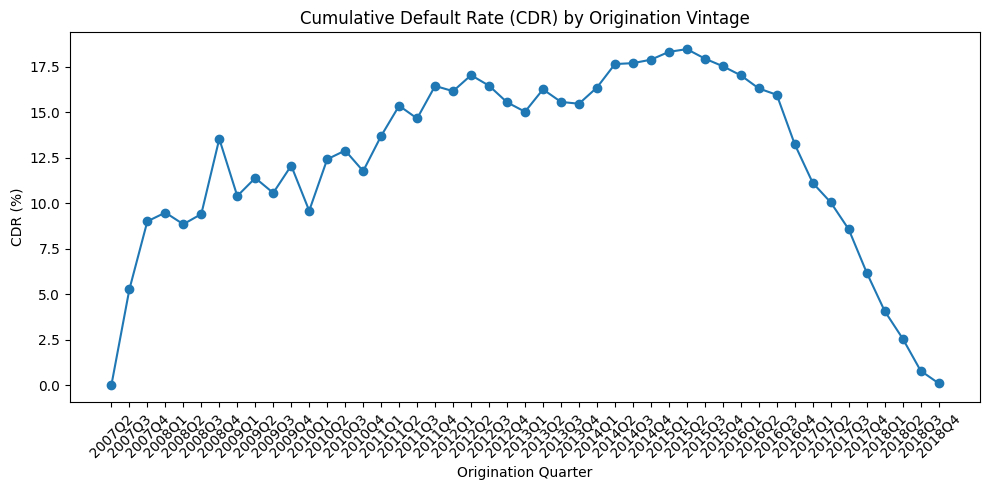

In [37]:
# -----------------------------
# CDR by quarter (count-based)
# -----------------------------
default_statuses = {"Charged Off", "Default"}

loan_df["loan_status_clean"] = loan_df["loan_status"].astype(str).str.strip()
loan_df["is_default"] = loan_df["loan_status_clean"].isin(default_statuses)

cdr_by_q = (
    loan_df
    .groupby("issue_quarter", dropna=False)
    .agg(
        loan_count=("loan_status_clean", "size"),
        default_count=("is_default", "sum"),
        avg_loan_age_months=("loan_age_months", "mean"),
        median_loan_age_months=("loan_age_months", "median"),
        min_loan_age_months=("loan_age_months", "min"),
        max_loan_age_months=("loan_age_months", "max"),
    )
    .reset_index()
)

cdr_by_q["CDR_pct"] = (cdr_by_q["default_count"] / cdr_by_q["loan_count"] * 100).round(2)

# Round seasoning diagnostics for readability
cdr_by_q["avg_loan_age_months"] = cdr_by_q["avg_loan_age_months"].round(2)
cdr_by_q["median_loan_age_months"] = cdr_by_q["median_loan_age_months"].round(2)
cdr_by_q["min_loan_age_months"] = cdr_by_q["min_loan_age_months"].round(0).astype("Int64")
cdr_by_q["max_loan_age_months"] = cdr_by_q["max_loan_age_months"].round(0).astype("Int64")

# Sort vintages chronologically (so 2018Q4 > 2018Q1)
cdr_by_q["issue_quarter_period"] = pd.PeriodIndex(cdr_by_q["issue_quarter"], freq="Q")
cdr_by_q = cdr_by_q.sort_values("issue_quarter_period").drop(columns=["issue_quarter_period"])

print(cdr_by_q)

plt.figure(figsize=(10, 5))
plt.plot(cdr_by_q["issue_quarter"], cdr_by_q["CDR_pct"], marker="o")

plt.title("Cumulative Default Rate (CDR) by Origination Vintage")
plt.xlabel("Origination Quarter")
plt.ylabel("CDR (%)")

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
## *** POSSIBLE ANALYTICS -- WHY IS DEFUALT RATE SO LOW FOR THE EARLY VINTAGES, WERE THE CREDIT STANDARDS TIGHTER OR BORROWERS WERE BETTER??b


In [40]:
def pool_cpr_time_series(
    loan_df: pd.DataFrame,
    *,
    issue_col: str = "issue_d",
    last_pymnt_col: str = "last_pymnt_d",
    funded_col: str = "funded_amnt",
    installment_col: str = "installment",
    last_pymnt_amt_col: str = "last_pymnt_amnt",
    int_rate_col: str = "int_rate_num",
    vintage_freq: str = "Q",              # "Q" for quarter, "M" for month
    enforce_post_vintage: bool = True,    # for quarterly vintage: last_pymnt_month >= quarter_end+1
    auto_detect_percent_units: bool = True,
) -> pd.DataFrame:
    """
    Pool-level CPR time series where pool = vintage and time = last_pymnt_month.

    For each (vintage, last_pymnt_month):
      pool_prepay = sum(unscheduled principal)
      pool_denom  = sum(BOM balance - scheduled principal)
      pool_smm    = pool_prepay / pool_denom
      pool_cpr    = 1 - (1 - pool_smm)^12
    """

    df = loan_df.copy()

    # ---------- helpers ----------
    def months_between(a: pd.Series, b: pd.Series) -> pd.Series:
        a = pd.to_datetime(a, errors="coerce")
        b = pd.to_datetime(b, errors="coerce")
        return (b.dt.year - a.dt.year) * 12 + (b.dt.month - a.dt.month)

    # ---------- numeric inputs ----------
    df["funded_amnt_num"]     = pd.to_numeric(df[funded_col], errors="coerce")
    df["installment_num"]     = pd.to_numeric(df[installment_col], errors="coerce")
    df["last_pymnt_amnt_num"] = pd.to_numeric(df[last_pymnt_amt_col], errors="coerce")
    df["int_rate_num"]        = pd.to_numeric(df[int_rate_col], errors="coerce")

    # rate normalization -> decimal
    if auto_detect_percent_units:
        med = df["int_rate_num"].median(skipna=True)
        if pd.notna(med) and med > 1:
            df["int_rate_num"] = df["int_rate_num"] / 100.0

    df["r_m"] = df["int_rate_num"] / 12.0

    # ---------- dates ----------
    df["issue_dt"]      = pd.to_datetime(df[issue_col], errors="coerce")
    df["last_pymnt_dt"] = pd.to_datetime(df[last_pymnt_col], errors="coerce")
    df["last_pymnt_month"] = df["last_pymnt_dt"].dt.to_period("M")

    # ---------- vintage ----------
    if vintage_freq.upper() == "Q":
        df["vintage"] = df["issue_dt"].dt.to_period("Q")
    elif vintage_freq.upper() == "M":
        df["vintage"] = df["issue_dt"].dt.to_period("M")
    else:
        raise ValueError("vintage_freq must be 'Q' or 'M'.")

    # Enforce: last payment month must be AFTER vintage end month
    if enforce_post_vintage and vintage_freq.upper() == "Q":
        vintage_end_month = df["vintage"].dt.asfreq("M", "end")   # e.g. 2018Q4 -> 2018-12
        first_allowed = vintage_end_month + 1                     # -> 2019-01
        df = df.loc[df["last_pymnt_month"] >= first_allowed].copy()

    # ---------- payment index (NO +1) ----------
    df["pmt_num"] = months_between(df["issue_dt"], df["last_pymnt_dt"]).clip(lower=0)
    n = (df["pmt_num"] - 1).clip(lower=0)  # payments before the month

    PV = df["funded_amnt_num"]
    P  = df["installment_num"]
    r  = df["r_m"]

    # ---------- loan-level BOM balance for that payment month ----------
    pow_term = (1 + r) ** n
    df["bom_balance"] = (PV * pow_term - P * (pow_term - 1) / r).clip(lower=0)

    # ---------- loan-level scheduled principal for that month ----------
    df["sched_interest"]  = df["bom_balance"] * r
    df["sched_principal"] = (P - df["sched_interest"]).clip(lower=0)
    df["sched_principal"] = np.minimum(df["sched_principal"], df["bom_balance"])

    # Denominator component per loan: BOM - scheduled principal
    df["loan_denom"] = (df["bom_balance"] - df["sched_principal"]).clip(lower=0)

    # ---------- loan-level unscheduled principal (curtailment) ----------
    # Approx actual principal paid = last payment cash - scheduled interest
    df["actual_principal_paid"] = (df["last_pymnt_amnt_num"] - df["sched_interest"]).clip(lower=0)
    df["actual_principal_paid"] = np.minimum(df["actual_principal_paid"], df["bom_balance"])

    # Unscheduled principal = max(actual_principal - scheduled_principal, 0)
    df["unsched_principal"] = (df["actual_principal_paid"] - df["sched_principal"]).clip(lower=0)
    df["unsched_principal"] = np.minimum(df["unsched_principal"], df["loan_denom"])

    # ---------- keep valid rows ----------
    keep = (
        df["vintage"].notna()
        & df["last_pymnt_month"].notna()
        & df["loan_denom"].notna()
        & df["unsched_principal"].notna()
    )
    d = df.loc[keep, ["vintage", "last_pymnt_month", "loan_denom", "unsched_principal"]].copy()

    # ---------- pool aggregation ----------
    grp = d.groupby(["vintage", "last_pymnt_month"], as_index=False).agg(
        pool_denom=("loan_denom", "sum"),
        pool_unsched_principal=("unsched_principal", "sum"),
    )

    grp["pool_smm"] = grp["pool_unsched_principal"] / grp["pool_denom"].replace(0, np.nan)
    grp["pool_smm"] = grp["pool_smm"].clip(lower=0, upper=1)
    grp["pool_cpr"] = 1 - (1 - grp["pool_smm"]) ** 12

    return grp.sort_values(["vintage", "last_pymnt_month"]).reset_index(drop=True)


# Example:
cpr_ts = pool_cpr_time_series(
    loan_df,
    vintage_freq="Q",
    enforce_post_vintage=True,
    int_rate_col="int_rate_num",
    auto_detect_percent_units=True
)

cpr_ts


,vintage,last_pymnt_month,pool_denom,pool_unsched_principal,pool_smm,pool_cpr
0,2007Q2,2008-01,4.523958e+03,0.000000e+00,0.000000,0.000000
1,2007Q2,2008-03,2.723097e+03,0.000000e+00,0.000000,0.000000
2,2007Q2,2008-05,5.642781e+03,0.000000e+00,0.000000,0.000000
3,2007Q2,2008-08,6.828314e+03,0.000000e+00,0.000000,0.000000
4,2007Q2,2009-08,1.506893e+03,1.506893e+03,1.000000,1.000000
...,...,...,...,...,...,...
2055,2018Q3,2019-02,1.282542e+08,1.710620e+07,0.133377,0.820543
2056,2018Q3,2019-03,1.538141e+09,1.125835e+07,0.007319,0.084382
2057,2018Q4,2019-01,2.254927e+07,1.465784e+07,0.650036,0.999997
2058,2018Q4,2019-02,1.511285e+08,1.526941e+07,0.101036,0.721447


In [ ]:
# if you are gonna do cpr for loans that are no longer outstanding, you need to further stratafiy based on fully paid 

In [48]:
loan_df[( loan_df['loan_status'] == "Fully Paid" ) ]['issue_quarter'].value_counts()

issue_quarter
2015Q4    92032
2016Q1    89143
2015Q3    78085
2015Q2    68257
2015Q1    61368
2014Q4    55141
2016Q2    46994
2016Q3    45085
2014Q3    44848
2016Q4    43631
2014Q2    42690
2014Q1    39262
2013Q4    37077
2017Q1    36123
2017Q2    33901
2017Q3    33356
2013Q3    31724
2017Q4    26772
2013Q2    25683
2013Q1    19296
2018Q1    18143
2012Q4    15804
2018Q2    15102
2012Q3    13479
2018Q3     9291
2012Q2     8668
2012Q1     6772
2011Q4     5529
2011Q3     5015
2018Q4     4908
2011Q2     4319
2011Q1     3561
2010Q4     3077
2010Q3     2824
2010Q2     2403
2010Q1     1745
2009Q4     1513
2009Q3     1087
2009Q2      840
2009Q1      682
2008Q1      485
2008Q4      424
2008Q2      248
2008Q3      158
2007Q4      134
2007Q3       71
2007Q2        1
Name: count, dtype: int64

In [50]:
ex = loan_df[(loan_df['issue_quarter'] == "2015Q4") & ( loan_df['loan_status'] == "Fully Paid" ) ]
ex

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,bom_balance,sched_interest,sched_principal,extra_payment,extra_principal_paid,smm_last_month,cpr_last_month,sched_eom_balance,actual_principal_paid,last_pymnt_month
0,68407277,NaN,3600.0,3600.0,3600.0,36 months,13.99,123.03,C,C4,...,0.000000,0.000000,0.000000,0.00,0.000000,NaN,NaN,0.000000,0.000000,2019-01
1,68355089,NaN,24700.0,24700.0,24700.0,36 months,11.99,820.28,C,C1,...,21774.694644,217.565491,602.714509,106.07,106.070000,0.00501,0.05849,21171.980135,708.784509,2016-06
2,68341763,NaN,20000.0,20000.0,20000.0,60 months,10.78,432.66,B,B4,...,15375.692739,138.124973,294.535027,15380.64,15081.157712,1.00000,1.00000,15081.157712,15375.692739,2017-06
4,68476807,NaN,10400.0,10400.0,10400.0,60 months,22.45,289.91,F,F1,...,9800.507436,183.351160,106.558840,9839.05,9693.948596,1.00000,1.00000,9693.948596,9800.507436,2016-07
5,68426831,NaN,11950.0,11950.0,11950.0,36 months,13.44,405.18,C,C3,...,7224.105535,80.909982,324.270018,7248.38,6899.835517,1.00000,1.00000,6899.835517,7224.105535,2017-05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149391,59422902,NaN,18200.0,18200.0,18200.0,36 months,7.26,564.13,A,A4,...,7550.700467,45.681738,518.448262,7045.02,7032.252205,1.00000,1.00000,7032.252205,7550.700467,2017-09
149798,59442250,NaN,17000.0,17000.0,17000.0,36 months,7.26,526.94,A,A4,...,523.528160,3.167345,523.528160,0.00,0.000000,NaN,NaN,0.000000,523.528160,2018-10
150449,59581951,NaN,8000.0,8000.0,8000.0,36 months,13.99,273.39,C,C4,...,4634.963806,54.035953,219.354047,4459.34,4415.609759,1.00000,1.00000,4415.609759,4634.963806,2017-04
150685,59581913,NaN,16000.0,16000.0,16000.0,36 months,7.89,500.58,A,A5,...,11927.142052,78.420959,422.159041,11570.55,11504.983011,1.00000,1.00000,11504.983011,11927.142052,2016-09


In [47]:
loan_df[( loan_df['loan_status'] == "Current" ) & ( loan_df['last_pymnt_month'] == "2019-03" )]['issue_quarter'].value_counts()

issue_quarter
2018Q4    113738
2018Q3    108406
2018Q2    102289
2018Q1     77739
2017Q4     77107
2017Q3     71030
2017Q2     54639
2017Q1     44242
2016Q4     41403
2016Q3     34326
2016Q2     31874
2016Q1     17135
2015Q4     13687
2015Q3     11166
2015Q2      8956
2015Q1      6813
2014Q4      5286
2014Q3      3138
2014Q2      2575
2014Q1       263
2013Q4         5
Name: count, dtype: int64

## Understanding loan status

In [6]:
loan_df['loan_status'].value_counts()

loan_status
Fully Paid                                             1076751
Current                                                 878317
Charged Off                                             268559
Late (31-120 days)                                       21467
In Grace Period                                           8436
Late (16-30 days)                                         4349
Does not meet the credit policy. Status:Fully Paid        1988
Does not meet the credit policy. Status:Charged Off        761
Default                                                     40
Name: count, dtype: int64

LC's description of loan status - https://www.lendingclub.com/help/investing-faq/what-do-the-different-note-statuses-mean
 - The "Does not meet the credit policy" loans are loans in the dataset but would no longer meet LC's credit critera. Anyway, they are paid off or defaulted. 
 - "Default" means the loan has not been current for more than 120 days, and LC will begin to charge off a loan.  
 - "Charged off" means the remaining balance of the loan has been written off as a loss.  
 - "In Grace Period" means the loan is within 1-15 days late of a payment. LC doesn't charge a fee if you pay within the grace period. 
 - "Late" loans have missed a payment and are late the number of specified days. 
 - "Fully Paid" means loan has been paid off in full, either through prepayment or at the end of the term. 
 - "Current" means the loans is up to date for all payments.

In [ ]:
creditpolicy_df = loan_df[loan_df['']]

In [7]:
loan_df.iloc[:500_000, :].to_csv("loan_snapshot.csv")

In [8]:
grace_df = loan_df[loan_df['loan_status'] == "In Grace Period"]
grace_df 

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
66,68615169,NaN,16000.0,16000.0,16000.0,60 months,8.49,328.19,B,B1,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
2121,68535626,NaN,30000.0,30000.0,30000.0,60 months,22.45,836.27,F,F1,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
3285,68364824,NaN,23825.0,23825.0,23825.0,60 months,10.78,515.41,B,B4,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
6353,67850012,NaN,12000.0,12000.0,12000.0,60 months,11.99,266.88,C,C1,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
7274,68242206,NaN,21000.0,21000.0,21000.0,60 months,15.77,508.12,D,D1,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2258995,90796053,NaN,17500.0,17500.0,17500.0,60 months,10.49,376.06,B,B3,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
2259876,90134762,NaN,27600.0,27600.0,27600.0,36 months,17.99,997.67,D,D2,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
2260102,90179895,NaN,11050.0,11050.0,11050.0,36 months,18.99,405.00,D,D3,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
2260139,90571568,NaN,4400.0,4400.0,4400.0,36 months,17.99,159.05,D,D2,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
curr_df = loan_df[loan_df['loan_status'] == "Current"]
curr_df

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
3,66310712,NaN,35000.0,35000.0,35000.0,60 months,14.85,829.90,C,C5,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
10,68356421,NaN,22400.0,22400.0,22400.0,60 months,12.88,508.30,C,C2,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
11,68426545,NaN,16000.0,16000.0,16000.0,60 months,12.88,363.07,C,C2,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
18,68506798,NaN,23000.0,23000.0,23000.0,60 months,8.49,471.77,B,B1,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
34,68537655,NaN,16800.0,16800.0,16800.0,60 months,12.88,381.23,C,C2,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2260693,89955820,NaN,24000.0,24000.0,24000.0,60 months,10.49,515.74,B,B3,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
2260694,89885898,NaN,24000.0,24000.0,24000.0,60 months,12.79,543.50,C,C1,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
2260695,88977788,NaN,24000.0,24000.0,24000.0,60 months,10.49,515.74,B,B3,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
2260696,88985880,NaN,40000.0,40000.0,40000.0,60 months,10.49,859.56,B,B3,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
